# GAN

1. Load libraries
2. MNIST dataset download 
3. Random sample $z$ from normal distribution
4. Generative model $G$
5. Disciminative model $D$
6. Train model $G$ and $D$
   1. Initialize model \\(G\\) and \\(D\\)
   2. Loss functions & Optimizers
   3. Train models
   4. Save model weights
7. Visualization (Interpolation)

## 1. Load libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [2]:
print('numpy: ' + np.__version__)
print('pandas: ' + pd.__version__)
print('matlotlib: ' + matplotlib.__version__)
print('torch: ' + torch.__version__)
print('torchvision: ' + torchvision.__version__)

numpy: 1.16.0
pandas: 0.25.3
matlotlib: 3.0.3
torch: 1.5.1
torchvision: 0.6.1


In [3]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print(device)

cuda


## 2. MNIST dataset download 


In [4]:
batch_size = 64

In [5]:
# standardizer
standardizer = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=0,
                                                        std=1)])

In [6]:
# MNIST dataset
train_data = dsets.MNIST(root='../data/', train=True, transform=standardizer, download=True)
test_data = dsets.MNIST(root='../data/', train=False, transform=standardizer, download=True)

In [7]:
# Data loader
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)

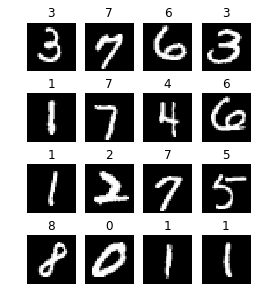

In [104]:
# visualize
mini_batch_img, mini_batch_lbl = next(iter(train_data_loader))

plt.figure(figsize=(4,5))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(mini_batch_img[i].squeeze(), cmap='gray')
    plt.title(mini_batch_lbl[i].numpy())
    plt.axis('off')
    
plt.savefig('../result/GAN/1-GAN/1-dataloader-example.png', dpi=300)

> 📌 **NOTE**  
>  
> MNIST 이미지를 문제없이 다운로드했다

## 3. Random sample $z$ from normal distribution

In [9]:
dim_noise = 100

In [10]:
# Random sampling from normal distribution
def random_sample_z_space(batch_size=1, dim_noise=100):
    return torch.randn(batch_size, dim_noise, device=device)

In [11]:
# Random sampling
z = random_sample_z_space(batch_size)

print("z\t:{}".format(z.shape))
print(z)

z	:torch.Size([64, 100])
tensor([[-0.3182, -1.7208,  0.5103,  ..., -0.8757, -0.3125,  0.3312],
        [ 0.4950, -1.2124, -0.9291,  ..., -0.4321, -0.5056,  1.8559],
        [-1.7881, -0.2417,  1.8614,  ..., -0.1981,  0.4994, -0.4451],
        ...,
        [ 1.2351,  0.0241, -0.8569,  ...,  0.5661, -0.6482,  0.6429],
        [-0.2499, -0.9189, -1.5429,  ...,  0.3856, -1.7420, -0.6433],
        [ 1.6969,  0.4347, -1.6991,  ..., -0.5768,  1.0312, -1.1297]],
       device='cuda:0')


> 📌 **NOTE**  
>  
> Random noise를 성공적으로 샘플링했다 !

## 4. Generative model $G$

In [12]:
dim_hidden = 256

sz_output = 28
dim_output = sz_output**2

num_channels = 1
img_shape = (num_channels, sz_output, sz_output)

In [13]:
# class Generator(nn.Module):
#     def __init__(self):
#         super(Generator, self).__init__()

#         def block(in_feat, out_feat, normalize=True):
#             layers = [nn.Linear(in_feat, out_feat)]
#             if normalize:
#                 layers.append(nn.BatchNorm1d(out_feat, 0.8))
#             layers.append(nn.LeakyReLU(0.2, inplace=True))
#             return layers

#         self.model = nn.Sequential(
#             *block(100, 128, normalize=False),
#             *block(128, 256),
#             *block(256, 512),
#             *block(512, 1024),
#             nn.Linear(1024, int(np.prod(img_shape))),
#             nn.Tanh()
#         )
#     def forward(self, z):
#         img = self.model(z)
#         img = img.view(img.size(0), *img_shape)
#         return img


In [14]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
                    nn.Linear(dim_noise, dim_hidden),
                    nn.ReLU(),
                    nn.Dropout(0.1),
                    nn.Linear(dim_hidden, dim_hidden),
                    nn.ReLU(),
                    nn.Dropout(0.1),
                    nn.Linear(dim_hidden, dim_output),
                    nn.Tanh()
        )
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img

In [15]:
G = Generator().to(device)

print("z\t:{}".format(z.shape))
print("G(z)\t:{}".format(G(z).size()))

z	:torch.Size([64, 100])
G(z)	:torch.Size([64, 1, 28, 28])


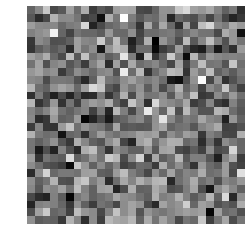

In [105]:
plt.imshow(G(z)[0].squeeze().cpu().detach(), cmap='gray');
plt.axis('off')
plt.savefig('../result/GAN/1-GAN/2-G(z).png', dpi=300)

> 📌 **NOTE**  
>  
> $G$가 학습이 되지 않은 상태라 의미없는 노이즈 데이터만 만들어낸다 !

## 5. Disciminative model $D$

In [17]:
# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()

#         self.model = nn.Sequential(
#             nn.Linear(int(np.prod(img_shape)), 512),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(512, 256),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(256, 1),
#             nn.Sigmoid(),
#         )

#     def forward(self, img):
#         img_flat = img.view(img.size(0), -1)
#         validity = self.model(img_flat)
#         return validity

In [18]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(dim_output, dim_hidden),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(dim_hidden, dim_hidden),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(dim_hidden, 1),
            nn.Sigmoid()    
        )
    
    def forward(self, img):
        flat_img = img.view(img.size(0), -1)
        check_validity = self.model(flat_img)
        
        return check_validity

In [19]:
D = Discriminator().to(device)

print("z\t:{}".format(z.shape))
print("G(z)\t:{}".format(G(z).size()))
print("D(G(z))\t:{}".format(D(G(z)).size()))

z	:torch.Size([64, 100])
G(z)	:torch.Size([64, 1, 28, 28])
D(G(z))	:torch.Size([64, 1])


> 📌 **NOTE**  
>  
> Generator $G$를 역순으로 뒤집은 형태인 Discriminator $D$를 정의한다.  
> $D$의 출력은 Fake와 Real을 구별하는 sigmoid function이다.

## 6. Train model $G$ and $D$

### 6-1. Initialize models

In [20]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

### 6-2. Loss function & optimizers

In [21]:
learning_rate = 0.0002

In [22]:
adversarial_loss = nn.BCELoss()

In [23]:
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate)

### 6-3. Train models

In [24]:
num_epochs = 200
interval_save_img = 400

In [25]:
Tensor = torch.cuda.FloatTensor if is_cuda else torch.FloatTensor

In [26]:
for idx_epoch in range(num_epochs):
    for idx_batch, (imgs, _) in enumerate(train_data_loader):
        # Ground truth variables indicating real/fake
        real_ground_truth = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake_ground_truth = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False) 
        
        # Real image
        real_imgs = Variable(imgs.type(Tensor))
                
        #####################
        # Train Generator
        
        optimizer_G.zero_grad()
        
        # Random sample noise
#         z = random_sample_z_space(imgs.size(0))
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], dim_noise))))
                
        # Generate image
        gen_imgs = generator(z)
        
        # Generator's loss: loss between D(G(z)) and real ground truth
        loss_G = adversarial_loss(discriminator(gen_imgs), real_ground_truth)
        
        loss_G.backward()
        optimizer_G.step()
        
        
        #####################
        # Train Discriminator
        
        optimizer_D.zero_grad()
        
        loss_real = adversarial_loss(discriminator(real_imgs), real_ground_truth)
        loss_fake = adversarial_loss(discriminator(gen_imgs.detach()), fake_ground_truth)
        loss_D = (loss_real+loss_fake)/2
        
        loss_D.backward()
        optimizer_D.step()
        
        
        #####################
        # Print progress
        if idx_batch % 10 == 0:
            print("[Epoch {}/{}] [Batch {}/{}] loss_G: {:.6f}, loss_D: {:.6f}".format(idx_epoch, num_epochs,
                                                                                      idx_batch, len(train_data_loader),
                                                                                      loss_G, loss_D))
                    
        batches_done = idx_epoch * len(train_data_loader) + idx_batch
        if batches_done % interval_save_img == 0:
            utils.save_image(gen_imgs.data[:25], "../result/GAN/1-GAN/4-{}.png".format(batches_done), nrow=5, normalize=True)

[Epoch 0/200] [Batch 0/938] loss_G: 0.683718, loss_D: 0.696356
[Epoch 0/200] [Batch 10/938] loss_G: 0.674789, loss_D: 0.604316
[Epoch 0/200] [Batch 20/938] loss_G: 0.620165, loss_D: 0.517185
[Epoch 0/200] [Batch 30/938] loss_G: 0.512904, loss_D: 0.544590
[Epoch 0/200] [Batch 40/938] loss_G: 0.814957, loss_D: 0.440064
[Epoch 0/200] [Batch 50/938] loss_G: 1.004035, loss_D: 0.536133
[Epoch 0/200] [Batch 60/938] loss_G: 0.994721, loss_D: 0.649995
[Epoch 0/200] [Batch 70/938] loss_G: 1.462310, loss_D: 0.395173
[Epoch 0/200] [Batch 80/938] loss_G: 2.140393, loss_D: 0.151049
[Epoch 0/200] [Batch 90/938] loss_G: 2.327324, loss_D: 0.108779
[Epoch 0/200] [Batch 100/938] loss_G: 2.321014, loss_D: 0.132675
[Epoch 0/200] [Batch 110/938] loss_G: 2.287968, loss_D: 0.161966
[Epoch 0/200] [Batch 120/938] loss_G: 2.441562, loss_D: 0.116379
[Epoch 0/200] [Batch 130/938] loss_G: 2.364642, loss_D: 0.117669
[Epoch 0/200] [Batch 140/938] loss_G: 2.711775, loss_D: 0.129386
[Epoch 0/200] [Batch 150/938] loss_G

[Epoch 1/200] [Batch 330/938] loss_G: 2.020194, loss_D: 0.278048
[Epoch 1/200] [Batch 340/938] loss_G: 1.925663, loss_D: 0.274203
[Epoch 1/200] [Batch 350/938] loss_G: 2.375228, loss_D: 0.139260
[Epoch 1/200] [Batch 360/938] loss_G: 2.306455, loss_D: 0.231728
[Epoch 1/200] [Batch 370/938] loss_G: 2.140430, loss_D: 0.257023
[Epoch 1/200] [Batch 380/938] loss_G: 2.419726, loss_D: 0.275377
[Epoch 1/200] [Batch 390/938] loss_G: 2.452874, loss_D: 0.140049
[Epoch 1/200] [Batch 400/938] loss_G: 2.630054, loss_D: 0.160317
[Epoch 1/200] [Batch 410/938] loss_G: 1.760442, loss_D: 0.363431
[Epoch 1/200] [Batch 420/938] loss_G: 1.660855, loss_D: 0.455470
[Epoch 1/200] [Batch 430/938] loss_G: 2.320894, loss_D: 0.243888
[Epoch 1/200] [Batch 440/938] loss_G: 2.483372, loss_D: 0.350809
[Epoch 1/200] [Batch 450/938] loss_G: 1.828489, loss_D: 0.330492
[Epoch 1/200] [Batch 460/938] loss_G: 1.686571, loss_D: 0.390465
[Epoch 1/200] [Batch 470/938] loss_G: 3.005343, loss_D: 0.142877
[Epoch 1/200] [Batch 480/

[Epoch 2/200] [Batch 670/938] loss_G: 2.644143, loss_D: 0.103282
[Epoch 2/200] [Batch 680/938] loss_G: 2.750593, loss_D: 0.185791
[Epoch 2/200] [Batch 690/938] loss_G: 3.261181, loss_D: 0.043747
[Epoch 2/200] [Batch 700/938] loss_G: 3.686024, loss_D: 0.094593
[Epoch 2/200] [Batch 710/938] loss_G: 3.019256, loss_D: 0.151297
[Epoch 2/200] [Batch 720/938] loss_G: 3.193425, loss_D: 0.186273
[Epoch 2/200] [Batch 730/938] loss_G: 3.564164, loss_D: 0.141160
[Epoch 2/200] [Batch 740/938] loss_G: 3.710384, loss_D: 0.053486
[Epoch 2/200] [Batch 750/938] loss_G: 4.192745, loss_D: 0.053502
[Epoch 2/200] [Batch 760/938] loss_G: 3.663553, loss_D: 0.052170
[Epoch 2/200] [Batch 770/938] loss_G: 3.357250, loss_D: 0.078695
[Epoch 2/200] [Batch 780/938] loss_G: 2.843921, loss_D: 0.088902
[Epoch 2/200] [Batch 790/938] loss_G: 2.975783, loss_D: 0.078420
[Epoch 2/200] [Batch 800/938] loss_G: 3.744084, loss_D: 0.084747
[Epoch 2/200] [Batch 810/938] loss_G: 2.588960, loss_D: 0.195570
[Epoch 2/200] [Batch 820/

[Epoch 4/200] [Batch 70/938] loss_G: 3.601062, loss_D: 0.079000
[Epoch 4/200] [Batch 80/938] loss_G: 3.048441, loss_D: 0.170620
[Epoch 4/200] [Batch 90/938] loss_G: 5.192246, loss_D: 0.035897
[Epoch 4/200] [Batch 100/938] loss_G: 4.673231, loss_D: 0.041926
[Epoch 4/200] [Batch 110/938] loss_G: 3.731694, loss_D: 0.039838
[Epoch 4/200] [Batch 120/938] loss_G: 3.208025, loss_D: 0.138208
[Epoch 4/200] [Batch 130/938] loss_G: 3.412352, loss_D: 0.118834
[Epoch 4/200] [Batch 140/938] loss_G: 3.905241, loss_D: 0.085386
[Epoch 4/200] [Batch 150/938] loss_G: 4.219119, loss_D: 0.074034
[Epoch 4/200] [Batch 160/938] loss_G: 3.771666, loss_D: 0.099274
[Epoch 4/200] [Batch 170/938] loss_G: 3.783530, loss_D: 0.186587
[Epoch 4/200] [Batch 180/938] loss_G: 3.547362, loss_D: 0.181992
[Epoch 4/200] [Batch 190/938] loss_G: 3.770017, loss_D: 0.108100
[Epoch 4/200] [Batch 200/938] loss_G: 3.910418, loss_D: 0.110374
[Epoch 4/200] [Batch 210/938] loss_G: 3.850103, loss_D: 0.159203
[Epoch 4/200] [Batch 220/938

[Epoch 5/200] [Batch 390/938] loss_G: 3.842458, loss_D: 0.077458
[Epoch 5/200] [Batch 400/938] loss_G: 4.516842, loss_D: 0.041502
[Epoch 5/200] [Batch 410/938] loss_G: 4.587695, loss_D: 0.046560
[Epoch 5/200] [Batch 420/938] loss_G: 4.467386, loss_D: 0.081908
[Epoch 5/200] [Batch 430/938] loss_G: 3.119454, loss_D: 0.101503
[Epoch 5/200] [Batch 440/938] loss_G: 3.861745, loss_D: 0.083118
[Epoch 5/200] [Batch 450/938] loss_G: 4.326084, loss_D: 0.104104
[Epoch 5/200] [Batch 460/938] loss_G: 4.026845, loss_D: 0.117096
[Epoch 5/200] [Batch 470/938] loss_G: 5.153755, loss_D: 0.053029
[Epoch 5/200] [Batch 480/938] loss_G: 4.414168, loss_D: 0.073768
[Epoch 5/200] [Batch 490/938] loss_G: 3.873950, loss_D: 0.058457
[Epoch 5/200] [Batch 500/938] loss_G: 4.212194, loss_D: 0.125696
[Epoch 5/200] [Batch 510/938] loss_G: 3.949207, loss_D: 0.067529
[Epoch 5/200] [Batch 520/938] loss_G: 4.529775, loss_D: 0.041879
[Epoch 5/200] [Batch 530/938] loss_G: 4.491733, loss_D: 0.053422
[Epoch 5/200] [Batch 540/

[Epoch 6/200] [Batch 720/938] loss_G: 3.894314, loss_D: 0.206778
[Epoch 6/200] [Batch 730/938] loss_G: 4.384395, loss_D: 0.066216
[Epoch 6/200] [Batch 740/938] loss_G: 4.189514, loss_D: 0.046031
[Epoch 6/200] [Batch 750/938] loss_G: 3.703839, loss_D: 0.080448
[Epoch 6/200] [Batch 760/938] loss_G: 3.966189, loss_D: 0.086788
[Epoch 6/200] [Batch 770/938] loss_G: 4.288933, loss_D: 0.071195
[Epoch 6/200] [Batch 780/938] loss_G: 3.618999, loss_D: 0.118945
[Epoch 6/200] [Batch 790/938] loss_G: 4.115332, loss_D: 0.047320
[Epoch 6/200] [Batch 800/938] loss_G: 4.000480, loss_D: 0.034159
[Epoch 6/200] [Batch 810/938] loss_G: 3.874892, loss_D: 0.079932
[Epoch 6/200] [Batch 820/938] loss_G: 3.410522, loss_D: 0.110686
[Epoch 6/200] [Batch 830/938] loss_G: 4.243672, loss_D: 0.069624
[Epoch 6/200] [Batch 840/938] loss_G: 4.730143, loss_D: 0.047431
[Epoch 6/200] [Batch 850/938] loss_G: 4.612368, loss_D: 0.129201
[Epoch 6/200] [Batch 860/938] loss_G: 4.097874, loss_D: 0.064098
[Epoch 6/200] [Batch 870/

[Epoch 8/200] [Batch 110/938] loss_G: 4.007702, loss_D: 0.171940
[Epoch 8/200] [Batch 120/938] loss_G: 4.621639, loss_D: 0.059447
[Epoch 8/200] [Batch 130/938] loss_G: 4.944177, loss_D: 0.081962
[Epoch 8/200] [Batch 140/938] loss_G: 4.012628, loss_D: 0.119776
[Epoch 8/200] [Batch 150/938] loss_G: 4.299732, loss_D: 0.051799
[Epoch 8/200] [Batch 160/938] loss_G: 3.930598, loss_D: 0.057457
[Epoch 8/200] [Batch 170/938] loss_G: 3.974014, loss_D: 0.118930
[Epoch 8/200] [Batch 180/938] loss_G: 4.444620, loss_D: 0.105868
[Epoch 8/200] [Batch 190/938] loss_G: 4.427369, loss_D: 0.092737
[Epoch 8/200] [Batch 200/938] loss_G: 4.659076, loss_D: 0.067965
[Epoch 8/200] [Batch 210/938] loss_G: 3.864879, loss_D: 0.135054
[Epoch 8/200] [Batch 220/938] loss_G: 4.567395, loss_D: 0.100793
[Epoch 8/200] [Batch 230/938] loss_G: 4.725262, loss_D: 0.050209
[Epoch 8/200] [Batch 240/938] loss_G: 5.327128, loss_D: 0.084870
[Epoch 8/200] [Batch 250/938] loss_G: 4.259110, loss_D: 0.120728
[Epoch 8/200] [Batch 260/

[Epoch 9/200] [Batch 440/938] loss_G: 4.210487, loss_D: 0.101845
[Epoch 9/200] [Batch 450/938] loss_G: 4.328856, loss_D: 0.055218
[Epoch 9/200] [Batch 460/938] loss_G: 4.629799, loss_D: 0.084363
[Epoch 9/200] [Batch 470/938] loss_G: 4.673168, loss_D: 0.082267
[Epoch 9/200] [Batch 480/938] loss_G: 4.295148, loss_D: 0.128669
[Epoch 9/200] [Batch 490/938] loss_G: 4.713391, loss_D: 0.052152
[Epoch 9/200] [Batch 500/938] loss_G: 4.921872, loss_D: 0.164737
[Epoch 9/200] [Batch 510/938] loss_G: 3.839081, loss_D: 0.070249
[Epoch 9/200] [Batch 520/938] loss_G: 4.341181, loss_D: 0.118450
[Epoch 9/200] [Batch 530/938] loss_G: 4.535260, loss_D: 0.053120
[Epoch 9/200] [Batch 540/938] loss_G: 3.996611, loss_D: 0.104877
[Epoch 9/200] [Batch 550/938] loss_G: 3.379588, loss_D: 0.132416
[Epoch 9/200] [Batch 560/938] loss_G: 3.833204, loss_D: 0.163151
[Epoch 9/200] [Batch 570/938] loss_G: 3.414525, loss_D: 0.095533
[Epoch 9/200] [Batch 580/938] loss_G: 4.459683, loss_D: 0.080764
[Epoch 9/200] [Batch 590/

[Epoch 10/200] [Batch 770/938] loss_G: 4.084138, loss_D: 0.061060
[Epoch 10/200] [Batch 780/938] loss_G: 4.240312, loss_D: 0.079446
[Epoch 10/200] [Batch 790/938] loss_G: 4.723854, loss_D: 0.096882
[Epoch 10/200] [Batch 800/938] loss_G: 4.086908, loss_D: 0.053959
[Epoch 10/200] [Batch 810/938] loss_G: 4.507470, loss_D: 0.070113
[Epoch 10/200] [Batch 820/938] loss_G: 3.697772, loss_D: 0.137741
[Epoch 10/200] [Batch 830/938] loss_G: 4.045848, loss_D: 0.100752
[Epoch 10/200] [Batch 840/938] loss_G: 4.922998, loss_D: 0.311082
[Epoch 10/200] [Batch 850/938] loss_G: 4.374313, loss_D: 0.095496
[Epoch 10/200] [Batch 860/938] loss_G: 3.691082, loss_D: 0.097261
[Epoch 10/200] [Batch 870/938] loss_G: 4.405246, loss_D: 0.138316
[Epoch 10/200] [Batch 880/938] loss_G: 4.137438, loss_D: 0.131007
[Epoch 10/200] [Batch 890/938] loss_G: 3.596334, loss_D: 0.114990
[Epoch 10/200] [Batch 900/938] loss_G: 4.567985, loss_D: 0.112605
[Epoch 10/200] [Batch 910/938] loss_G: 4.310379, loss_D: 0.062681
[Epoch 10/

[Epoch 12/200] [Batch 140/938] loss_G: 3.350327, loss_D: 0.203775
[Epoch 12/200] [Batch 150/938] loss_G: 3.591321, loss_D: 0.100042
[Epoch 12/200] [Batch 160/938] loss_G: 3.903654, loss_D: 0.207761
[Epoch 12/200] [Batch 170/938] loss_G: 4.674144, loss_D: 0.148674
[Epoch 12/200] [Batch 180/938] loss_G: 4.124494, loss_D: 0.104741
[Epoch 12/200] [Batch 190/938] loss_G: 3.335319, loss_D: 0.111910
[Epoch 12/200] [Batch 200/938] loss_G: 4.524511, loss_D: 0.195368
[Epoch 12/200] [Batch 210/938] loss_G: 3.628899, loss_D: 0.129493
[Epoch 12/200] [Batch 220/938] loss_G: 3.872733, loss_D: 0.217500
[Epoch 12/200] [Batch 230/938] loss_G: 3.779887, loss_D: 0.091322
[Epoch 12/200] [Batch 240/938] loss_G: 4.198842, loss_D: 0.095245
[Epoch 12/200] [Batch 250/938] loss_G: 5.111543, loss_D: 0.100208
[Epoch 12/200] [Batch 260/938] loss_G: 3.958228, loss_D: 0.078815
[Epoch 12/200] [Batch 270/938] loss_G: 4.113915, loss_D: 0.092697
[Epoch 12/200] [Batch 280/938] loss_G: 4.817684, loss_D: 0.081138
[Epoch 12/

[Epoch 13/200] [Batch 460/938] loss_G: 4.530436, loss_D: 0.087320
[Epoch 13/200] [Batch 470/938] loss_G: 4.353297, loss_D: 0.125546
[Epoch 13/200] [Batch 480/938] loss_G: 4.703059, loss_D: 0.097416
[Epoch 13/200] [Batch 490/938] loss_G: 4.540564, loss_D: 0.086318
[Epoch 13/200] [Batch 500/938] loss_G: 3.681551, loss_D: 0.114540
[Epoch 13/200] [Batch 510/938] loss_G: 3.740301, loss_D: 0.170533
[Epoch 13/200] [Batch 520/938] loss_G: 3.761839, loss_D: 0.086181
[Epoch 13/200] [Batch 530/938] loss_G: 3.728296, loss_D: 0.056628
[Epoch 13/200] [Batch 540/938] loss_G: 3.313395, loss_D: 0.096352
[Epoch 13/200] [Batch 550/938] loss_G: 3.695944, loss_D: 0.137050
[Epoch 13/200] [Batch 560/938] loss_G: 3.841375, loss_D: 0.126331
[Epoch 13/200] [Batch 570/938] loss_G: 3.768120, loss_D: 0.210768
[Epoch 13/200] [Batch 580/938] loss_G: 3.647026, loss_D: 0.057925
[Epoch 13/200] [Batch 590/938] loss_G: 3.773802, loss_D: 0.112512
[Epoch 13/200] [Batch 600/938] loss_G: 4.123393, loss_D: 0.194892
[Epoch 13/

[Epoch 14/200] [Batch 770/938] loss_G: 4.184202, loss_D: 0.100073
[Epoch 14/200] [Batch 780/938] loss_G: 4.203980, loss_D: 0.162918
[Epoch 14/200] [Batch 790/938] loss_G: 4.121017, loss_D: 0.140621
[Epoch 14/200] [Batch 800/938] loss_G: 3.134674, loss_D: 0.201324
[Epoch 14/200] [Batch 810/938] loss_G: 3.832624, loss_D: 0.257117
[Epoch 14/200] [Batch 820/938] loss_G: 4.490222, loss_D: 0.154228
[Epoch 14/200] [Batch 830/938] loss_G: 3.776445, loss_D: 0.092815
[Epoch 14/200] [Batch 840/938] loss_G: 3.971447, loss_D: 0.204607
[Epoch 14/200] [Batch 850/938] loss_G: 4.744212, loss_D: 0.100483
[Epoch 14/200] [Batch 860/938] loss_G: 3.739189, loss_D: 0.177658
[Epoch 14/200] [Batch 870/938] loss_G: 3.456127, loss_D: 0.185018
[Epoch 14/200] [Batch 880/938] loss_G: 3.654760, loss_D: 0.185430
[Epoch 14/200] [Batch 890/938] loss_G: 3.557564, loss_D: 0.122360
[Epoch 14/200] [Batch 900/938] loss_G: 4.098633, loss_D: 0.136725
[Epoch 14/200] [Batch 910/938] loss_G: 4.235595, loss_D: 0.086430
[Epoch 14/

[Epoch 16/200] [Batch 150/938] loss_G: 4.153309, loss_D: 0.143443
[Epoch 16/200] [Batch 160/938] loss_G: 3.299722, loss_D: 0.115452
[Epoch 16/200] [Batch 170/938] loss_G: 4.720846, loss_D: 0.141226
[Epoch 16/200] [Batch 180/938] loss_G: 4.777937, loss_D: 0.113077
[Epoch 16/200] [Batch 190/938] loss_G: 4.057212, loss_D: 0.118051
[Epoch 16/200] [Batch 200/938] loss_G: 4.596266, loss_D: 0.075279
[Epoch 16/200] [Batch 210/938] loss_G: 4.092980, loss_D: 0.096933
[Epoch 16/200] [Batch 220/938] loss_G: 4.089166, loss_D: 0.142836
[Epoch 16/200] [Batch 230/938] loss_G: 4.019273, loss_D: 0.173510
[Epoch 16/200] [Batch 240/938] loss_G: 4.725247, loss_D: 0.053020
[Epoch 16/200] [Batch 250/938] loss_G: 3.866400, loss_D: 0.107246
[Epoch 16/200] [Batch 260/938] loss_G: 4.064603, loss_D: 0.132707
[Epoch 16/200] [Batch 270/938] loss_G: 4.323129, loss_D: 0.091468
[Epoch 16/200] [Batch 280/938] loss_G: 3.545696, loss_D: 0.151904
[Epoch 16/200] [Batch 290/938] loss_G: 3.544988, loss_D: 0.161885
[Epoch 16/

[Epoch 17/200] [Batch 460/938] loss_G: 3.802079, loss_D: 0.190880
[Epoch 17/200] [Batch 470/938] loss_G: 4.152883, loss_D: 0.142173
[Epoch 17/200] [Batch 480/938] loss_G: 4.414654, loss_D: 0.077514
[Epoch 17/200] [Batch 490/938] loss_G: 3.674009, loss_D: 0.161045
[Epoch 17/200] [Batch 500/938] loss_G: 3.563250, loss_D: 0.113834
[Epoch 17/200] [Batch 510/938] loss_G: 3.709027, loss_D: 0.124685
[Epoch 17/200] [Batch 520/938] loss_G: 3.761069, loss_D: 0.074936
[Epoch 17/200] [Batch 530/938] loss_G: 3.795323, loss_D: 0.116324
[Epoch 17/200] [Batch 540/938] loss_G: 3.916155, loss_D: 0.141618
[Epoch 17/200] [Batch 550/938] loss_G: 3.467243, loss_D: 0.220507
[Epoch 17/200] [Batch 560/938] loss_G: 3.507877, loss_D: 0.138860
[Epoch 17/200] [Batch 570/938] loss_G: 3.832745, loss_D: 0.179206
[Epoch 17/200] [Batch 580/938] loss_G: 3.351775, loss_D: 0.210142
[Epoch 17/200] [Batch 590/938] loss_G: 3.091580, loss_D: 0.199592
[Epoch 17/200] [Batch 600/938] loss_G: 3.608711, loss_D: 0.125276
[Epoch 17/

[Epoch 18/200] [Batch 770/938] loss_G: 3.931636, loss_D: 0.200922
[Epoch 18/200] [Batch 780/938] loss_G: 3.129616, loss_D: 0.171609
[Epoch 18/200] [Batch 790/938] loss_G: 3.281999, loss_D: 0.221530
[Epoch 18/200] [Batch 800/938] loss_G: 4.266397, loss_D: 0.087399
[Epoch 18/200] [Batch 810/938] loss_G: 3.757385, loss_D: 0.168040
[Epoch 18/200] [Batch 820/938] loss_G: 3.789811, loss_D: 0.203614
[Epoch 18/200] [Batch 830/938] loss_G: 3.628823, loss_D: 0.237290
[Epoch 18/200] [Batch 840/938] loss_G: 3.750302, loss_D: 0.174521
[Epoch 18/200] [Batch 850/938] loss_G: 3.797146, loss_D: 0.159898
[Epoch 18/200] [Batch 860/938] loss_G: 3.930872, loss_D: 0.096761
[Epoch 18/200] [Batch 870/938] loss_G: 4.252918, loss_D: 0.058207
[Epoch 18/200] [Batch 880/938] loss_G: 4.125318, loss_D: 0.194926
[Epoch 18/200] [Batch 890/938] loss_G: 3.640683, loss_D: 0.260767
[Epoch 18/200] [Batch 900/938] loss_G: 3.236953, loss_D: 0.194154
[Epoch 18/200] [Batch 910/938] loss_G: 3.433996, loss_D: 0.143038
[Epoch 18/

[Epoch 20/200] [Batch 140/938] loss_G: 3.477538, loss_D: 0.169168
[Epoch 20/200] [Batch 150/938] loss_G: 3.135267, loss_D: 0.285987
[Epoch 20/200] [Batch 160/938] loss_G: 3.411040, loss_D: 0.169068
[Epoch 20/200] [Batch 170/938] loss_G: 3.897499, loss_D: 0.122015
[Epoch 20/200] [Batch 180/938] loss_G: 4.053060, loss_D: 0.181186
[Epoch 20/200] [Batch 190/938] loss_G: 3.943816, loss_D: 0.151251
[Epoch 20/200] [Batch 200/938] loss_G: 4.018503, loss_D: 0.180644
[Epoch 20/200] [Batch 210/938] loss_G: 4.088905, loss_D: 0.161788
[Epoch 20/200] [Batch 220/938] loss_G: 4.096750, loss_D: 0.225948
[Epoch 20/200] [Batch 230/938] loss_G: 3.671149, loss_D: 0.147036
[Epoch 20/200] [Batch 240/938] loss_G: 3.317431, loss_D: 0.123793
[Epoch 20/200] [Batch 250/938] loss_G: 3.870902, loss_D: 0.123574
[Epoch 20/200] [Batch 260/938] loss_G: 3.449975, loss_D: 0.193352
[Epoch 20/200] [Batch 270/938] loss_G: 2.656715, loss_D: 0.236250
[Epoch 20/200] [Batch 280/938] loss_G: 3.288978, loss_D: 0.151724
[Epoch 20/

[Epoch 21/200] [Batch 450/938] loss_G: 3.254866, loss_D: 0.260289
[Epoch 21/200] [Batch 460/938] loss_G: 3.397056, loss_D: 0.181898
[Epoch 21/200] [Batch 470/938] loss_G: 3.543317, loss_D: 0.244823
[Epoch 21/200] [Batch 480/938] loss_G: 2.827051, loss_D: 0.261922
[Epoch 21/200] [Batch 490/938] loss_G: 3.371068, loss_D: 0.246240
[Epoch 21/200] [Batch 500/938] loss_G: 3.426193, loss_D: 0.156270
[Epoch 21/200] [Batch 510/938] loss_G: 3.008962, loss_D: 0.173588
[Epoch 21/200] [Batch 520/938] loss_G: 3.427014, loss_D: 0.148669
[Epoch 21/200] [Batch 530/938] loss_G: 3.410791, loss_D: 0.162920
[Epoch 21/200] [Batch 540/938] loss_G: 3.465054, loss_D: 0.150063
[Epoch 21/200] [Batch 550/938] loss_G: 3.510225, loss_D: 0.148921
[Epoch 21/200] [Batch 560/938] loss_G: 3.393355, loss_D: 0.162558
[Epoch 21/200] [Batch 570/938] loss_G: 3.435977, loss_D: 0.207725
[Epoch 21/200] [Batch 580/938] loss_G: 2.918485, loss_D: 0.304933
[Epoch 21/200] [Batch 590/938] loss_G: 3.071678, loss_D: 0.178595
[Epoch 21/

[Epoch 22/200] [Batch 770/938] loss_G: 3.782088, loss_D: 0.164140
[Epoch 22/200] [Batch 780/938] loss_G: 2.537337, loss_D: 0.243664
[Epoch 22/200] [Batch 790/938] loss_G: 3.224246, loss_D: 0.167536
[Epoch 22/200] [Batch 800/938] loss_G: 3.678126, loss_D: 0.228003
[Epoch 22/200] [Batch 810/938] loss_G: 3.131526, loss_D: 0.154335
[Epoch 22/200] [Batch 820/938] loss_G: 3.028387, loss_D: 0.172514
[Epoch 22/200] [Batch 830/938] loss_G: 3.068406, loss_D: 0.182491
[Epoch 22/200] [Batch 840/938] loss_G: 3.031011, loss_D: 0.193540
[Epoch 22/200] [Batch 850/938] loss_G: 3.282004, loss_D: 0.214040
[Epoch 22/200] [Batch 860/938] loss_G: 2.794191, loss_D: 0.165823
[Epoch 22/200] [Batch 870/938] loss_G: 3.309574, loss_D: 0.216038
[Epoch 22/200] [Batch 880/938] loss_G: 3.541031, loss_D: 0.194241
[Epoch 22/200] [Batch 890/938] loss_G: 2.866721, loss_D: 0.271724
[Epoch 22/200] [Batch 900/938] loss_G: 3.195112, loss_D: 0.271193
[Epoch 22/200] [Batch 910/938] loss_G: 3.293019, loss_D: 0.201478
[Epoch 22/

[Epoch 24/200] [Batch 150/938] loss_G: 3.163888, loss_D: 0.180879
[Epoch 24/200] [Batch 160/938] loss_G: 3.205467, loss_D: 0.169929
[Epoch 24/200] [Batch 170/938] loss_G: 3.392800, loss_D: 0.189308
[Epoch 24/200] [Batch 180/938] loss_G: 3.188247, loss_D: 0.259659
[Epoch 24/200] [Batch 190/938] loss_G: 3.193135, loss_D: 0.219593
[Epoch 24/200] [Batch 200/938] loss_G: 3.271545, loss_D: 0.212561
[Epoch 24/200] [Batch 210/938] loss_G: 3.420757, loss_D: 0.101467
[Epoch 24/200] [Batch 220/938] loss_G: 3.354060, loss_D: 0.186208
[Epoch 24/200] [Batch 230/938] loss_G: 3.647651, loss_D: 0.177060
[Epoch 24/200] [Batch 240/938] loss_G: 3.629540, loss_D: 0.200172
[Epoch 24/200] [Batch 250/938] loss_G: 3.260055, loss_D: 0.157449
[Epoch 24/200] [Batch 260/938] loss_G: 2.837533, loss_D: 0.217130
[Epoch 24/200] [Batch 270/938] loss_G: 3.207714, loss_D: 0.201717
[Epoch 24/200] [Batch 280/938] loss_G: 2.710297, loss_D: 0.189300
[Epoch 24/200] [Batch 290/938] loss_G: 3.053362, loss_D: 0.238967
[Epoch 24/

[Epoch 25/200] [Batch 470/938] loss_G: 3.553357, loss_D: 0.219879
[Epoch 25/200] [Batch 480/938] loss_G: 3.684595, loss_D: 0.156231
[Epoch 25/200] [Batch 490/938] loss_G: 2.712743, loss_D: 0.154949
[Epoch 25/200] [Batch 500/938] loss_G: 3.200440, loss_D: 0.208798
[Epoch 25/200] [Batch 510/938] loss_G: 3.618430, loss_D: 0.164104
[Epoch 25/200] [Batch 520/938] loss_G: 2.820242, loss_D: 0.306950
[Epoch 25/200] [Batch 530/938] loss_G: 2.841547, loss_D: 0.265987
[Epoch 25/200] [Batch 540/938] loss_G: 3.118074, loss_D: 0.183615
[Epoch 25/200] [Batch 550/938] loss_G: 2.344270, loss_D: 0.251024
[Epoch 25/200] [Batch 560/938] loss_G: 3.025260, loss_D: 0.232475
[Epoch 25/200] [Batch 570/938] loss_G: 3.187537, loss_D: 0.183829
[Epoch 25/200] [Batch 580/938] loss_G: 3.673402, loss_D: 0.188197
[Epoch 25/200] [Batch 590/938] loss_G: 3.145072, loss_D: 0.172438
[Epoch 25/200] [Batch 600/938] loss_G: 3.169080, loss_D: 0.265717
[Epoch 25/200] [Batch 610/938] loss_G: 2.887109, loss_D: 0.240358
[Epoch 25/

[Epoch 26/200] [Batch 790/938] loss_G: 2.915374, loss_D: 0.177386
[Epoch 26/200] [Batch 800/938] loss_G: 2.534056, loss_D: 0.282840
[Epoch 26/200] [Batch 810/938] loss_G: 3.068956, loss_D: 0.137352
[Epoch 26/200] [Batch 820/938] loss_G: 3.262421, loss_D: 0.304807
[Epoch 26/200] [Batch 830/938] loss_G: 3.258895, loss_D: 0.179100
[Epoch 26/200] [Batch 840/938] loss_G: 2.563668, loss_D: 0.219878
[Epoch 26/200] [Batch 850/938] loss_G: 3.035392, loss_D: 0.209909
[Epoch 26/200] [Batch 860/938] loss_G: 2.781184, loss_D: 0.242073
[Epoch 26/200] [Batch 870/938] loss_G: 3.154361, loss_D: 0.181505
[Epoch 26/200] [Batch 880/938] loss_G: 2.766191, loss_D: 0.165573
[Epoch 26/200] [Batch 890/938] loss_G: 3.273209, loss_D: 0.266694
[Epoch 26/200] [Batch 900/938] loss_G: 2.829749, loss_D: 0.264467
[Epoch 26/200] [Batch 910/938] loss_G: 3.612828, loss_D: 0.174965
[Epoch 26/200] [Batch 920/938] loss_G: 3.004322, loss_D: 0.198178
[Epoch 26/200] [Batch 930/938] loss_G: 2.857482, loss_D: 0.205739
[Epoch 27/

[Epoch 28/200] [Batch 150/938] loss_G: 2.748533, loss_D: 0.223666
[Epoch 28/200] [Batch 160/938] loss_G: 2.295841, loss_D: 0.321524
[Epoch 28/200] [Batch 170/938] loss_G: 3.148097, loss_D: 0.242015
[Epoch 28/200] [Batch 180/938] loss_G: 2.644356, loss_D: 0.246337
[Epoch 28/200] [Batch 190/938] loss_G: 2.746782, loss_D: 0.204219
[Epoch 28/200] [Batch 200/938] loss_G: 2.908289, loss_D: 0.237572
[Epoch 28/200] [Batch 210/938] loss_G: 3.184562, loss_D: 0.246243
[Epoch 28/200] [Batch 220/938] loss_G: 2.932584, loss_D: 0.260997
[Epoch 28/200] [Batch 230/938] loss_G: 2.353722, loss_D: 0.322602
[Epoch 28/200] [Batch 240/938] loss_G: 2.569073, loss_D: 0.197314
[Epoch 28/200] [Batch 250/938] loss_G: 2.558690, loss_D: 0.244954
[Epoch 28/200] [Batch 260/938] loss_G: 2.935399, loss_D: 0.192873
[Epoch 28/200] [Batch 270/938] loss_G: 2.745722, loss_D: 0.235483
[Epoch 28/200] [Batch 280/938] loss_G: 2.662150, loss_D: 0.308062
[Epoch 28/200] [Batch 290/938] loss_G: 2.341698, loss_D: 0.280218
[Epoch 28/

[Epoch 29/200] [Batch 460/938] loss_G: 2.627713, loss_D: 0.289885
[Epoch 29/200] [Batch 470/938] loss_G: 3.558956, loss_D: 0.193529
[Epoch 29/200] [Batch 480/938] loss_G: 3.002120, loss_D: 0.186178
[Epoch 29/200] [Batch 490/938] loss_G: 2.726477, loss_D: 0.241011
[Epoch 29/200] [Batch 500/938] loss_G: 3.024873, loss_D: 0.190167
[Epoch 29/200] [Batch 510/938] loss_G: 2.577548, loss_D: 0.300578
[Epoch 29/200] [Batch 520/938] loss_G: 2.968440, loss_D: 0.224155
[Epoch 29/200] [Batch 530/938] loss_G: 2.698305, loss_D: 0.220802
[Epoch 29/200] [Batch 540/938] loss_G: 3.293560, loss_D: 0.260827
[Epoch 29/200] [Batch 550/938] loss_G: 2.684623, loss_D: 0.229398
[Epoch 29/200] [Batch 560/938] loss_G: 2.927305, loss_D: 0.244542
[Epoch 29/200] [Batch 570/938] loss_G: 3.082390, loss_D: 0.205880
[Epoch 29/200] [Batch 580/938] loss_G: 3.120757, loss_D: 0.217227
[Epoch 29/200] [Batch 590/938] loss_G: 2.835092, loss_D: 0.161728
[Epoch 29/200] [Batch 600/938] loss_G: 2.754769, loss_D: 0.182223
[Epoch 29/

[Epoch 30/200] [Batch 770/938] loss_G: 2.527690, loss_D: 0.273713
[Epoch 30/200] [Batch 780/938] loss_G: 2.835059, loss_D: 0.220025
[Epoch 30/200] [Batch 790/938] loss_G: 2.655597, loss_D: 0.218376
[Epoch 30/200] [Batch 800/938] loss_G: 2.834586, loss_D: 0.375366
[Epoch 30/200] [Batch 810/938] loss_G: 3.032706, loss_D: 0.240705
[Epoch 30/200] [Batch 820/938] loss_G: 3.226283, loss_D: 0.141317
[Epoch 30/200] [Batch 830/938] loss_G: 2.856019, loss_D: 0.155448
[Epoch 30/200] [Batch 840/938] loss_G: 2.658917, loss_D: 0.327738
[Epoch 30/200] [Batch 850/938] loss_G: 2.460585, loss_D: 0.327878
[Epoch 30/200] [Batch 860/938] loss_G: 3.302546, loss_D: 0.249079
[Epoch 30/200] [Batch 870/938] loss_G: 2.585501, loss_D: 0.179379
[Epoch 30/200] [Batch 880/938] loss_G: 2.646244, loss_D: 0.180901
[Epoch 30/200] [Batch 890/938] loss_G: 2.603447, loss_D: 0.208867
[Epoch 30/200] [Batch 900/938] loss_G: 2.797356, loss_D: 0.238010
[Epoch 30/200] [Batch 910/938] loss_G: 3.087286, loss_D: 0.148483
[Epoch 30/

[Epoch 32/200] [Batch 150/938] loss_G: 2.925403, loss_D: 0.139957
[Epoch 32/200] [Batch 160/938] loss_G: 2.801319, loss_D: 0.167915
[Epoch 32/200] [Batch 170/938] loss_G: 2.826536, loss_D: 0.254841
[Epoch 32/200] [Batch 180/938] loss_G: 2.556324, loss_D: 0.245851
[Epoch 32/200] [Batch 190/938] loss_G: 2.684803, loss_D: 0.258549
[Epoch 32/200] [Batch 200/938] loss_G: 2.802197, loss_D: 0.193531
[Epoch 32/200] [Batch 210/938] loss_G: 2.573351, loss_D: 0.314888
[Epoch 32/200] [Batch 220/938] loss_G: 2.996039, loss_D: 0.154520
[Epoch 32/200] [Batch 230/938] loss_G: 2.643986, loss_D: 0.164587
[Epoch 32/200] [Batch 240/938] loss_G: 2.794402, loss_D: 0.241931
[Epoch 32/200] [Batch 250/938] loss_G: 2.439889, loss_D: 0.298495
[Epoch 32/200] [Batch 260/938] loss_G: 3.017892, loss_D: 0.214443
[Epoch 32/200] [Batch 270/938] loss_G: 2.927761, loss_D: 0.238817
[Epoch 32/200] [Batch 280/938] loss_G: 2.414921, loss_D: 0.236529
[Epoch 32/200] [Batch 290/938] loss_G: 2.622998, loss_D: 0.246079
[Epoch 32/

[Epoch 33/200] [Batch 460/938] loss_G: 2.317158, loss_D: 0.271298
[Epoch 33/200] [Batch 470/938] loss_G: 2.755260, loss_D: 0.229332
[Epoch 33/200] [Batch 480/938] loss_G: 2.896756, loss_D: 0.177556
[Epoch 33/200] [Batch 490/938] loss_G: 3.237106, loss_D: 0.173405
[Epoch 33/200] [Batch 500/938] loss_G: 3.143956, loss_D: 0.228812
[Epoch 33/200] [Batch 510/938] loss_G: 2.725667, loss_D: 0.180809
[Epoch 33/200] [Batch 520/938] loss_G: 3.131960, loss_D: 0.212238
[Epoch 33/200] [Batch 530/938] loss_G: 2.731277, loss_D: 0.181173
[Epoch 33/200] [Batch 540/938] loss_G: 2.994507, loss_D: 0.186838
[Epoch 33/200] [Batch 550/938] loss_G: 2.421289, loss_D: 0.247263
[Epoch 33/200] [Batch 560/938] loss_G: 2.730783, loss_D: 0.275471
[Epoch 33/200] [Batch 570/938] loss_G: 2.717715, loss_D: 0.191302
[Epoch 33/200] [Batch 580/938] loss_G: 2.517495, loss_D: 0.217888
[Epoch 33/200] [Batch 590/938] loss_G: 2.871112, loss_D: 0.267225
[Epoch 33/200] [Batch 600/938] loss_G: 2.568758, loss_D: 0.313666
[Epoch 33/

[Epoch 34/200] [Batch 780/938] loss_G: 2.676486, loss_D: 0.210200
[Epoch 34/200] [Batch 790/938] loss_G: 2.463436, loss_D: 0.204731
[Epoch 34/200] [Batch 800/938] loss_G: 2.492912, loss_D: 0.273537
[Epoch 34/200] [Batch 810/938] loss_G: 2.511773, loss_D: 0.225649
[Epoch 34/200] [Batch 820/938] loss_G: 2.582704, loss_D: 0.277434
[Epoch 34/200] [Batch 830/938] loss_G: 2.529335, loss_D: 0.198080
[Epoch 34/200] [Batch 840/938] loss_G: 2.278398, loss_D: 0.315172
[Epoch 34/200] [Batch 850/938] loss_G: 2.676563, loss_D: 0.235278
[Epoch 34/200] [Batch 860/938] loss_G: 2.685179, loss_D: 0.216932
[Epoch 34/200] [Batch 870/938] loss_G: 2.582068, loss_D: 0.181213
[Epoch 34/200] [Batch 880/938] loss_G: 2.757614, loss_D: 0.188249
[Epoch 34/200] [Batch 890/938] loss_G: 2.483466, loss_D: 0.320040
[Epoch 34/200] [Batch 900/938] loss_G: 2.565458, loss_D: 0.162541
[Epoch 34/200] [Batch 910/938] loss_G: 2.511847, loss_D: 0.225124
[Epoch 34/200] [Batch 920/938] loss_G: 2.921714, loss_D: 0.240676
[Epoch 34/

[Epoch 36/200] [Batch 150/938] loss_G: 2.686544, loss_D: 0.252497
[Epoch 36/200] [Batch 160/938] loss_G: 2.397257, loss_D: 0.265533
[Epoch 36/200] [Batch 170/938] loss_G: 2.800379, loss_D: 0.235718
[Epoch 36/200] [Batch 180/938] loss_G: 2.501925, loss_D: 0.293553
[Epoch 36/200] [Batch 190/938] loss_G: 2.448155, loss_D: 0.207915
[Epoch 36/200] [Batch 200/938] loss_G: 2.507419, loss_D: 0.356441
[Epoch 36/200] [Batch 210/938] loss_G: 2.036206, loss_D: 0.241294
[Epoch 36/200] [Batch 220/938] loss_G: 2.590175, loss_D: 0.329781
[Epoch 36/200] [Batch 230/938] loss_G: 2.821570, loss_D: 0.324110
[Epoch 36/200] [Batch 240/938] loss_G: 2.573799, loss_D: 0.304469
[Epoch 36/200] [Batch 250/938] loss_G: 2.859697, loss_D: 0.213370
[Epoch 36/200] [Batch 260/938] loss_G: 2.367641, loss_D: 0.254550
[Epoch 36/200] [Batch 270/938] loss_G: 2.351463, loss_D: 0.228262
[Epoch 36/200] [Batch 280/938] loss_G: 2.481036, loss_D: 0.216880
[Epoch 36/200] [Batch 290/938] loss_G: 2.777157, loss_D: 0.193053
[Epoch 36/

[Epoch 37/200] [Batch 460/938] loss_G: 2.721802, loss_D: 0.359538
[Epoch 37/200] [Batch 470/938] loss_G: 2.651651, loss_D: 0.269380
[Epoch 37/200] [Batch 480/938] loss_G: 2.442097, loss_D: 0.277048
[Epoch 37/200] [Batch 490/938] loss_G: 2.554589, loss_D: 0.250543
[Epoch 37/200] [Batch 500/938] loss_G: 2.938012, loss_D: 0.287950
[Epoch 37/200] [Batch 510/938] loss_G: 2.948942, loss_D: 0.183667
[Epoch 37/200] [Batch 520/938] loss_G: 2.643715, loss_D: 0.233688
[Epoch 37/200] [Batch 530/938] loss_G: 2.898401, loss_D: 0.286627
[Epoch 37/200] [Batch 540/938] loss_G: 2.887231, loss_D: 0.225497
[Epoch 37/200] [Batch 550/938] loss_G: 2.806679, loss_D: 0.245322
[Epoch 37/200] [Batch 560/938] loss_G: 2.877526, loss_D: 0.133191
[Epoch 37/200] [Batch 570/938] loss_G: 2.528756, loss_D: 0.238014
[Epoch 37/200] [Batch 580/938] loss_G: 2.069751, loss_D: 0.282141
[Epoch 37/200] [Batch 590/938] loss_G: 2.709064, loss_D: 0.225040
[Epoch 37/200] [Batch 600/938] loss_G: 2.860110, loss_D: 0.248181
[Epoch 37/

[Epoch 38/200] [Batch 780/938] loss_G: 2.895980, loss_D: 0.251522
[Epoch 38/200] [Batch 790/938] loss_G: 2.459040, loss_D: 0.212523
[Epoch 38/200] [Batch 800/938] loss_G: 2.950991, loss_D: 0.329127
[Epoch 38/200] [Batch 810/938] loss_G: 2.679066, loss_D: 0.348010
[Epoch 38/200] [Batch 820/938] loss_G: 2.683614, loss_D: 0.364541
[Epoch 38/200] [Batch 830/938] loss_G: 3.409369, loss_D: 0.188874
[Epoch 38/200] [Batch 840/938] loss_G: 2.610685, loss_D: 0.207207
[Epoch 38/200] [Batch 850/938] loss_G: 2.839977, loss_D: 0.264073
[Epoch 38/200] [Batch 860/938] loss_G: 2.765032, loss_D: 0.204322
[Epoch 38/200] [Batch 870/938] loss_G: 2.570085, loss_D: 0.291369
[Epoch 38/200] [Batch 880/938] loss_G: 2.628937, loss_D: 0.185159
[Epoch 38/200] [Batch 890/938] loss_G: 3.035974, loss_D: 0.259635
[Epoch 38/200] [Batch 900/938] loss_G: 2.800040, loss_D: 0.198230
[Epoch 38/200] [Batch 910/938] loss_G: 2.817527, loss_D: 0.195253
[Epoch 38/200] [Batch 920/938] loss_G: 2.163257, loss_D: 0.341598
[Epoch 38/

[Epoch 40/200] [Batch 150/938] loss_G: 2.966887, loss_D: 0.161430
[Epoch 40/200] [Batch 160/938] loss_G: 2.430051, loss_D: 0.282072
[Epoch 40/200] [Batch 170/938] loss_G: 2.597975, loss_D: 0.206522
[Epoch 40/200] [Batch 180/938] loss_G: 2.753675, loss_D: 0.290228
[Epoch 40/200] [Batch 190/938] loss_G: 3.092645, loss_D: 0.146814
[Epoch 40/200] [Batch 200/938] loss_G: 2.978350, loss_D: 0.225122
[Epoch 40/200] [Batch 210/938] loss_G: 2.900235, loss_D: 0.207163
[Epoch 40/200] [Batch 220/938] loss_G: 2.353932, loss_D: 0.222183
[Epoch 40/200] [Batch 230/938] loss_G: 2.514705, loss_D: 0.284832
[Epoch 40/200] [Batch 240/938] loss_G: 2.889993, loss_D: 0.212498
[Epoch 40/200] [Batch 250/938] loss_G: 3.192811, loss_D: 0.168268
[Epoch 40/200] [Batch 260/938] loss_G: 2.667226, loss_D: 0.236779
[Epoch 40/200] [Batch 270/938] loss_G: 2.566757, loss_D: 0.195087
[Epoch 40/200] [Batch 280/938] loss_G: 2.616083, loss_D: 0.182657
[Epoch 40/200] [Batch 290/938] loss_G: 2.260487, loss_D: 0.221974
[Epoch 40/

[Epoch 41/200] [Batch 450/938] loss_G: 2.772327, loss_D: 0.273945
[Epoch 41/200] [Batch 460/938] loss_G: 3.056582, loss_D: 0.192671
[Epoch 41/200] [Batch 470/938] loss_G: 2.842668, loss_D: 0.168402
[Epoch 41/200] [Batch 480/938] loss_G: 3.088208, loss_D: 0.109913
[Epoch 41/200] [Batch 490/938] loss_G: 2.789269, loss_D: 0.186388
[Epoch 41/200] [Batch 500/938] loss_G: 2.910290, loss_D: 0.208796
[Epoch 41/200] [Batch 510/938] loss_G: 2.605013, loss_D: 0.277770
[Epoch 41/200] [Batch 520/938] loss_G: 3.216395, loss_D: 0.225479
[Epoch 41/200] [Batch 530/938] loss_G: 2.370950, loss_D: 0.215290
[Epoch 41/200] [Batch 540/938] loss_G: 2.355207, loss_D: 0.236309
[Epoch 41/200] [Batch 550/938] loss_G: 3.052815, loss_D: 0.387284
[Epoch 41/200] [Batch 560/938] loss_G: 2.397005, loss_D: 0.241052
[Epoch 41/200] [Batch 570/938] loss_G: 3.400435, loss_D: 0.151075
[Epoch 41/200] [Batch 580/938] loss_G: 2.570992, loss_D: 0.264577
[Epoch 41/200] [Batch 590/938] loss_G: 2.628506, loss_D: 0.274779
[Epoch 41/

[Epoch 42/200] [Batch 760/938] loss_G: 2.858001, loss_D: 0.210605
[Epoch 42/200] [Batch 770/938] loss_G: 2.510348, loss_D: 0.302672
[Epoch 42/200] [Batch 780/938] loss_G: 2.823065, loss_D: 0.276393
[Epoch 42/200] [Batch 790/938] loss_G: 2.051834, loss_D: 0.278174
[Epoch 42/200] [Batch 800/938] loss_G: 3.219998, loss_D: 0.248397
[Epoch 42/200] [Batch 810/938] loss_G: 2.135252, loss_D: 0.361285
[Epoch 42/200] [Batch 820/938] loss_G: 2.461481, loss_D: 0.297071
[Epoch 42/200] [Batch 830/938] loss_G: 2.831064, loss_D: 0.173691
[Epoch 42/200] [Batch 840/938] loss_G: 2.642066, loss_D: 0.203171
[Epoch 42/200] [Batch 850/938] loss_G: 2.358410, loss_D: 0.219699
[Epoch 42/200] [Batch 860/938] loss_G: 2.631019, loss_D: 0.219192
[Epoch 42/200] [Batch 870/938] loss_G: 2.690803, loss_D: 0.275132
[Epoch 42/200] [Batch 880/938] loss_G: 2.623370, loss_D: 0.258509
[Epoch 42/200] [Batch 890/938] loss_G: 2.478351, loss_D: 0.318571
[Epoch 42/200] [Batch 900/938] loss_G: 2.705905, loss_D: 0.226734
[Epoch 42/

[Epoch 44/200] [Batch 140/938] loss_G: 2.587782, loss_D: 0.211370
[Epoch 44/200] [Batch 150/938] loss_G: 2.578367, loss_D: 0.223991
[Epoch 44/200] [Batch 160/938] loss_G: 2.959040, loss_D: 0.228320
[Epoch 44/200] [Batch 170/938] loss_G: 2.452665, loss_D: 0.373235
[Epoch 44/200] [Batch 180/938] loss_G: 2.622456, loss_D: 0.309270
[Epoch 44/200] [Batch 190/938] loss_G: 2.523554, loss_D: 0.289834
[Epoch 44/200] [Batch 200/938] loss_G: 3.111114, loss_D: 0.285423
[Epoch 44/200] [Batch 210/938] loss_G: 2.509195, loss_D: 0.313608
[Epoch 44/200] [Batch 220/938] loss_G: 2.507475, loss_D: 0.232521
[Epoch 44/200] [Batch 230/938] loss_G: 2.639519, loss_D: 0.190525
[Epoch 44/200] [Batch 240/938] loss_G: 2.946257, loss_D: 0.196791
[Epoch 44/200] [Batch 250/938] loss_G: 2.914620, loss_D: 0.236830
[Epoch 44/200] [Batch 260/938] loss_G: 2.712726, loss_D: 0.214503
[Epoch 44/200] [Batch 270/938] loss_G: 2.954132, loss_D: 0.182706
[Epoch 44/200] [Batch 280/938] loss_G: 2.768169, loss_D: 0.250938
[Epoch 44/

[Epoch 45/200] [Batch 460/938] loss_G: 2.524708, loss_D: 0.264878
[Epoch 45/200] [Batch 470/938] loss_G: 2.457988, loss_D: 0.228365
[Epoch 45/200] [Batch 480/938] loss_G: 2.620099, loss_D: 0.157428
[Epoch 45/200] [Batch 490/938] loss_G: 2.326632, loss_D: 0.239187
[Epoch 45/200] [Batch 500/938] loss_G: 2.776795, loss_D: 0.199285
[Epoch 45/200] [Batch 510/938] loss_G: 2.750920, loss_D: 0.221845
[Epoch 45/200] [Batch 520/938] loss_G: 2.602321, loss_D: 0.292528
[Epoch 45/200] [Batch 530/938] loss_G: 2.830069, loss_D: 0.193220
[Epoch 45/200] [Batch 540/938] loss_G: 2.675224, loss_D: 0.189630
[Epoch 45/200] [Batch 550/938] loss_G: 3.062443, loss_D: 0.165006
[Epoch 45/200] [Batch 560/938] loss_G: 2.371498, loss_D: 0.211430
[Epoch 45/200] [Batch 570/938] loss_G: 2.992721, loss_D: 0.281408
[Epoch 45/200] [Batch 580/938] loss_G: 2.640002, loss_D: 0.226356
[Epoch 45/200] [Batch 590/938] loss_G: 2.718758, loss_D: 0.295101
[Epoch 45/200] [Batch 600/938] loss_G: 2.487280, loss_D: 0.258627
[Epoch 45/

[Epoch 46/200] [Batch 780/938] loss_G: 2.772754, loss_D: 0.205509
[Epoch 46/200] [Batch 790/938] loss_G: 2.710302, loss_D: 0.265599
[Epoch 46/200] [Batch 800/938] loss_G: 2.469561, loss_D: 0.290451
[Epoch 46/200] [Batch 810/938] loss_G: 2.945345, loss_D: 0.267262
[Epoch 46/200] [Batch 820/938] loss_G: 2.449940, loss_D: 0.238520
[Epoch 46/200] [Batch 830/938] loss_G: 2.642153, loss_D: 0.242401
[Epoch 46/200] [Batch 840/938] loss_G: 2.778497, loss_D: 0.170309
[Epoch 46/200] [Batch 850/938] loss_G: 2.978249, loss_D: 0.174616
[Epoch 46/200] [Batch 860/938] loss_G: 2.868576, loss_D: 0.247223
[Epoch 46/200] [Batch 870/938] loss_G: 2.883824, loss_D: 0.229204
[Epoch 46/200] [Batch 880/938] loss_G: 2.635539, loss_D: 0.159868
[Epoch 46/200] [Batch 890/938] loss_G: 2.720565, loss_D: 0.191877
[Epoch 46/200] [Batch 900/938] loss_G: 2.719769, loss_D: 0.180448
[Epoch 46/200] [Batch 910/938] loss_G: 2.657613, loss_D: 0.279169
[Epoch 46/200] [Batch 920/938] loss_G: 2.438317, loss_D: 0.224500
[Epoch 46/

[Epoch 48/200] [Batch 150/938] loss_G: 2.664372, loss_D: 0.168682
[Epoch 48/200] [Batch 160/938] loss_G: 2.401378, loss_D: 0.252263
[Epoch 48/200] [Batch 170/938] loss_G: 2.686144, loss_D: 0.248336
[Epoch 48/200] [Batch 180/938] loss_G: 2.339721, loss_D: 0.246681
[Epoch 48/200] [Batch 190/938] loss_G: 2.917212, loss_D: 0.295018
[Epoch 48/200] [Batch 200/938] loss_G: 2.623089, loss_D: 0.183249
[Epoch 48/200] [Batch 210/938] loss_G: 2.543669, loss_D: 0.247510
[Epoch 48/200] [Batch 220/938] loss_G: 2.949126, loss_D: 0.191476
[Epoch 48/200] [Batch 230/938] loss_G: 2.519926, loss_D: 0.168646
[Epoch 48/200] [Batch 240/938] loss_G: 2.549115, loss_D: 0.205786
[Epoch 48/200] [Batch 250/938] loss_G: 2.195827, loss_D: 0.235794
[Epoch 48/200] [Batch 260/938] loss_G: 2.764948, loss_D: 0.244107
[Epoch 48/200] [Batch 270/938] loss_G: 2.447537, loss_D: 0.241959
[Epoch 48/200] [Batch 280/938] loss_G: 2.486515, loss_D: 0.295227
[Epoch 48/200] [Batch 290/938] loss_G: 2.706742, loss_D: 0.202713
[Epoch 48/

[Epoch 49/200] [Batch 450/938] loss_G: 2.807999, loss_D: 0.138218
[Epoch 49/200] [Batch 460/938] loss_G: 2.854302, loss_D: 0.363013
[Epoch 49/200] [Batch 470/938] loss_G: 2.857556, loss_D: 0.241758
[Epoch 49/200] [Batch 480/938] loss_G: 2.589518, loss_D: 0.159004
[Epoch 49/200] [Batch 490/938] loss_G: 2.470772, loss_D: 0.316486
[Epoch 49/200] [Batch 500/938] loss_G: 2.653674, loss_D: 0.284147
[Epoch 49/200] [Batch 510/938] loss_G: 3.146258, loss_D: 0.181775
[Epoch 49/200] [Batch 520/938] loss_G: 2.366115, loss_D: 0.255488
[Epoch 49/200] [Batch 530/938] loss_G: 2.897908, loss_D: 0.241528
[Epoch 49/200] [Batch 540/938] loss_G: 2.751724, loss_D: 0.270307
[Epoch 49/200] [Batch 550/938] loss_G: 2.729876, loss_D: 0.219009
[Epoch 49/200] [Batch 560/938] loss_G: 3.122802, loss_D: 0.216924
[Epoch 49/200] [Batch 570/938] loss_G: 2.771283, loss_D: 0.223875
[Epoch 49/200] [Batch 580/938] loss_G: 2.546557, loss_D: 0.243741
[Epoch 49/200] [Batch 590/938] loss_G: 2.523178, loss_D: 0.288056
[Epoch 49/

[Epoch 50/200] [Batch 770/938] loss_G: 2.362025, loss_D: 0.249173
[Epoch 50/200] [Batch 780/938] loss_G: 2.838730, loss_D: 0.223556
[Epoch 50/200] [Batch 790/938] loss_G: 2.741769, loss_D: 0.260243
[Epoch 50/200] [Batch 800/938] loss_G: 2.789641, loss_D: 0.342097
[Epoch 50/200] [Batch 810/938] loss_G: 2.903910, loss_D: 0.225256
[Epoch 50/200] [Batch 820/938] loss_G: 2.761029, loss_D: 0.152833
[Epoch 50/200] [Batch 830/938] loss_G: 2.430757, loss_D: 0.232972
[Epoch 50/200] [Batch 840/938] loss_G: 2.547880, loss_D: 0.290671
[Epoch 50/200] [Batch 850/938] loss_G: 2.206297, loss_D: 0.227151
[Epoch 50/200] [Batch 860/938] loss_G: 2.479418, loss_D: 0.315694
[Epoch 50/200] [Batch 870/938] loss_G: 3.343211, loss_D: 0.265544
[Epoch 50/200] [Batch 880/938] loss_G: 3.211113, loss_D: 0.159473
[Epoch 50/200] [Batch 890/938] loss_G: 2.780016, loss_D: 0.194208
[Epoch 50/200] [Batch 900/938] loss_G: 2.571035, loss_D: 0.203472
[Epoch 50/200] [Batch 910/938] loss_G: 2.211319, loss_D: 0.265232
[Epoch 50/

[Epoch 52/200] [Batch 150/938] loss_G: 2.907311, loss_D: 0.216007
[Epoch 52/200] [Batch 160/938] loss_G: 2.637236, loss_D: 0.287461
[Epoch 52/200] [Batch 170/938] loss_G: 2.544741, loss_D: 0.196172
[Epoch 52/200] [Batch 180/938] loss_G: 2.468002, loss_D: 0.331241
[Epoch 52/200] [Batch 190/938] loss_G: 2.836036, loss_D: 0.157965
[Epoch 52/200] [Batch 200/938] loss_G: 2.592569, loss_D: 0.192792
[Epoch 52/200] [Batch 210/938] loss_G: 2.690790, loss_D: 0.221553
[Epoch 52/200] [Batch 220/938] loss_G: 3.041942, loss_D: 0.317876
[Epoch 52/200] [Batch 230/938] loss_G: 2.737962, loss_D: 0.325222
[Epoch 52/200] [Batch 240/938] loss_G: 2.934289, loss_D: 0.207607
[Epoch 52/200] [Batch 250/938] loss_G: 3.213874, loss_D: 0.225160
[Epoch 52/200] [Batch 260/938] loss_G: 2.479337, loss_D: 0.166754
[Epoch 52/200] [Batch 270/938] loss_G: 2.890788, loss_D: 0.265683
[Epoch 52/200] [Batch 280/938] loss_G: 2.893543, loss_D: 0.204030
[Epoch 52/200] [Batch 290/938] loss_G: 2.766189, loss_D: 0.286391
[Epoch 52/

[Epoch 53/200] [Batch 460/938] loss_G: 2.680360, loss_D: 0.302488
[Epoch 53/200] [Batch 470/938] loss_G: 2.741510, loss_D: 0.269712
[Epoch 53/200] [Batch 480/938] loss_G: 2.690144, loss_D: 0.151207
[Epoch 53/200] [Batch 490/938] loss_G: 2.510491, loss_D: 0.187068
[Epoch 53/200] [Batch 500/938] loss_G: 2.577234, loss_D: 0.277366
[Epoch 53/200] [Batch 510/938] loss_G: 2.170424, loss_D: 0.358723
[Epoch 53/200] [Batch 520/938] loss_G: 2.863464, loss_D: 0.280621
[Epoch 53/200] [Batch 530/938] loss_G: 2.360864, loss_D: 0.270764
[Epoch 53/200] [Batch 540/938] loss_G: 2.472685, loss_D: 0.223786
[Epoch 53/200] [Batch 550/938] loss_G: 2.712875, loss_D: 0.226843
[Epoch 53/200] [Batch 560/938] loss_G: 2.674537, loss_D: 0.203136
[Epoch 53/200] [Batch 570/938] loss_G: 2.706969, loss_D: 0.210027
[Epoch 53/200] [Batch 580/938] loss_G: 2.867821, loss_D: 0.239720
[Epoch 53/200] [Batch 590/938] loss_G: 2.543270, loss_D: 0.224900
[Epoch 53/200] [Batch 600/938] loss_G: 2.754328, loss_D: 0.247218
[Epoch 53/

[Epoch 54/200] [Batch 770/938] loss_G: 2.576199, loss_D: 0.219212
[Epoch 54/200] [Batch 780/938] loss_G: 2.480273, loss_D: 0.217300
[Epoch 54/200] [Batch 790/938] loss_G: 2.342659, loss_D: 0.304289
[Epoch 54/200] [Batch 800/938] loss_G: 2.644583, loss_D: 0.260749
[Epoch 54/200] [Batch 810/938] loss_G: 2.579787, loss_D: 0.225998
[Epoch 54/200] [Batch 820/938] loss_G: 2.656249, loss_D: 0.252334
[Epoch 54/200] [Batch 830/938] loss_G: 2.524757, loss_D: 0.210340
[Epoch 54/200] [Batch 840/938] loss_G: 2.563843, loss_D: 0.259804
[Epoch 54/200] [Batch 850/938] loss_G: 2.403238, loss_D: 0.192139
[Epoch 54/200] [Batch 860/938] loss_G: 2.591897, loss_D: 0.205647
[Epoch 54/200] [Batch 870/938] loss_G: 2.764099, loss_D: 0.214778
[Epoch 54/200] [Batch 880/938] loss_G: 2.565482, loss_D: 0.239496
[Epoch 54/200] [Batch 890/938] loss_G: 2.713836, loss_D: 0.231187
[Epoch 54/200] [Batch 900/938] loss_G: 2.565101, loss_D: 0.334534
[Epoch 54/200] [Batch 910/938] loss_G: 2.532517, loss_D: 0.260385
[Epoch 54/

[Epoch 56/200] [Batch 150/938] loss_G: 2.667697, loss_D: 0.214060
[Epoch 56/200] [Batch 160/938] loss_G: 2.394461, loss_D: 0.296528
[Epoch 56/200] [Batch 170/938] loss_G: 2.413459, loss_D: 0.264526
[Epoch 56/200] [Batch 180/938] loss_G: 2.537825, loss_D: 0.207194
[Epoch 56/200] [Batch 190/938] loss_G: 2.630429, loss_D: 0.234884
[Epoch 56/200] [Batch 200/938] loss_G: 2.275810, loss_D: 0.257678
[Epoch 56/200] [Batch 210/938] loss_G: 2.634860, loss_D: 0.235537
[Epoch 56/200] [Batch 220/938] loss_G: 2.721488, loss_D: 0.209011
[Epoch 56/200] [Batch 230/938] loss_G: 2.954195, loss_D: 0.183638
[Epoch 56/200] [Batch 240/938] loss_G: 2.696894, loss_D: 0.254963
[Epoch 56/200] [Batch 250/938] loss_G: 2.635717, loss_D: 0.284450
[Epoch 56/200] [Batch 260/938] loss_G: 3.112620, loss_D: 0.184301
[Epoch 56/200] [Batch 270/938] loss_G: 2.311208, loss_D: 0.302824
[Epoch 56/200] [Batch 280/938] loss_G: 2.607036, loss_D: 0.242396
[Epoch 56/200] [Batch 290/938] loss_G: 2.469074, loss_D: 0.248382
[Epoch 56/

[Epoch 57/200] [Batch 470/938] loss_G: 2.524168, loss_D: 0.221509
[Epoch 57/200] [Batch 480/938] loss_G: 2.415474, loss_D: 0.300893
[Epoch 57/200] [Batch 490/938] loss_G: 2.603935, loss_D: 0.221008
[Epoch 57/200] [Batch 500/938] loss_G: 2.660717, loss_D: 0.244164
[Epoch 57/200] [Batch 510/938] loss_G: 2.843532, loss_D: 0.196146
[Epoch 57/200] [Batch 520/938] loss_G: 2.450048, loss_D: 0.235389
[Epoch 57/200] [Batch 530/938] loss_G: 2.733704, loss_D: 0.361387
[Epoch 57/200] [Batch 540/938] loss_G: 2.455066, loss_D: 0.301539
[Epoch 57/200] [Batch 550/938] loss_G: 2.295591, loss_D: 0.244336
[Epoch 57/200] [Batch 560/938] loss_G: 2.856287, loss_D: 0.208606
[Epoch 57/200] [Batch 570/938] loss_G: 2.607748, loss_D: 0.291827
[Epoch 57/200] [Batch 580/938] loss_G: 2.862431, loss_D: 0.169097
[Epoch 57/200] [Batch 590/938] loss_G: 2.828424, loss_D: 0.176358
[Epoch 57/200] [Batch 600/938] loss_G: 2.612671, loss_D: 0.202845
[Epoch 57/200] [Batch 610/938] loss_G: 2.423030, loss_D: 0.224538
[Epoch 57/

[Epoch 58/200] [Batch 780/938] loss_G: 2.256721, loss_D: 0.235270
[Epoch 58/200] [Batch 790/938] loss_G: 2.335446, loss_D: 0.222456
[Epoch 58/200] [Batch 800/938] loss_G: 2.452948, loss_D: 0.275017
[Epoch 58/200] [Batch 810/938] loss_G: 3.482194, loss_D: 0.200518
[Epoch 58/200] [Batch 820/938] loss_G: 2.774192, loss_D: 0.175228
[Epoch 58/200] [Batch 830/938] loss_G: 2.700113, loss_D: 0.264905
[Epoch 58/200] [Batch 840/938] loss_G: 2.446052, loss_D: 0.270055
[Epoch 58/200] [Batch 850/938] loss_G: 2.374052, loss_D: 0.278358
[Epoch 58/200] [Batch 860/938] loss_G: 2.669229, loss_D: 0.232931
[Epoch 58/200] [Batch 870/938] loss_G: 2.649069, loss_D: 0.218159
[Epoch 58/200] [Batch 880/938] loss_G: 2.569388, loss_D: 0.195153
[Epoch 58/200] [Batch 890/938] loss_G: 2.853562, loss_D: 0.195066
[Epoch 58/200] [Batch 900/938] loss_G: 3.100708, loss_D: 0.248995
[Epoch 58/200] [Batch 910/938] loss_G: 2.638626, loss_D: 0.273490
[Epoch 58/200] [Batch 920/938] loss_G: 2.596707, loss_D: 0.178708
[Epoch 58/

[Epoch 60/200] [Batch 150/938] loss_G: 2.642401, loss_D: 0.212547
[Epoch 60/200] [Batch 160/938] loss_G: 2.906414, loss_D: 0.287983
[Epoch 60/200] [Batch 170/938] loss_G: 2.483571, loss_D: 0.241589
[Epoch 60/200] [Batch 180/938] loss_G: 2.949445, loss_D: 0.262612
[Epoch 60/200] [Batch 190/938] loss_G: 2.762685, loss_D: 0.150378
[Epoch 60/200] [Batch 200/938] loss_G: 2.794888, loss_D: 0.222000
[Epoch 60/200] [Batch 210/938] loss_G: 2.539072, loss_D: 0.255797
[Epoch 60/200] [Batch 220/938] loss_G: 2.744605, loss_D: 0.364377
[Epoch 60/200] [Batch 230/938] loss_G: 2.692836, loss_D: 0.279599
[Epoch 60/200] [Batch 240/938] loss_G: 2.913959, loss_D: 0.165585
[Epoch 60/200] [Batch 250/938] loss_G: 2.949285, loss_D: 0.337175
[Epoch 60/200] [Batch 260/938] loss_G: 2.499682, loss_D: 0.278398
[Epoch 60/200] [Batch 270/938] loss_G: 2.876660, loss_D: 0.199625
[Epoch 60/200] [Batch 280/938] loss_G: 2.732108, loss_D: 0.201009
[Epoch 60/200] [Batch 290/938] loss_G: 2.831685, loss_D: 0.170983
[Epoch 60/

[Epoch 61/200] [Batch 460/938] loss_G: 2.578712, loss_D: 0.230738
[Epoch 61/200] [Batch 470/938] loss_G: 2.472668, loss_D: 0.217663
[Epoch 61/200] [Batch 480/938] loss_G: 2.505348, loss_D: 0.266691
[Epoch 61/200] [Batch 490/938] loss_G: 2.360208, loss_D: 0.284899
[Epoch 61/200] [Batch 500/938] loss_G: 2.511524, loss_D: 0.213054
[Epoch 61/200] [Batch 510/938] loss_G: 2.365773, loss_D: 0.255514
[Epoch 61/200] [Batch 520/938] loss_G: 2.749490, loss_D: 0.199446
[Epoch 61/200] [Batch 530/938] loss_G: 2.221082, loss_D: 0.363722
[Epoch 61/200] [Batch 540/938] loss_G: 2.607143, loss_D: 0.222651
[Epoch 61/200] [Batch 550/938] loss_G: 3.069769, loss_D: 0.243185
[Epoch 61/200] [Batch 560/938] loss_G: 2.674383, loss_D: 0.212032
[Epoch 61/200] [Batch 570/938] loss_G: 2.295971, loss_D: 0.233367
[Epoch 61/200] [Batch 580/938] loss_G: 2.495274, loss_D: 0.274130
[Epoch 61/200] [Batch 590/938] loss_G: 2.191563, loss_D: 0.267825
[Epoch 61/200] [Batch 600/938] loss_G: 2.511485, loss_D: 0.233828
[Epoch 61/

[Epoch 62/200] [Batch 780/938] loss_G: 2.709036, loss_D: 0.279799
[Epoch 62/200] [Batch 790/938] loss_G: 2.580374, loss_D: 0.224160
[Epoch 62/200] [Batch 800/938] loss_G: 2.894600, loss_D: 0.284371
[Epoch 62/200] [Batch 810/938] loss_G: 2.683363, loss_D: 0.274882
[Epoch 62/200] [Batch 820/938] loss_G: 2.715466, loss_D: 0.216055
[Epoch 62/200] [Batch 830/938] loss_G: 2.612058, loss_D: 0.194420
[Epoch 62/200] [Batch 840/938] loss_G: 2.378191, loss_D: 0.366488
[Epoch 62/200] [Batch 850/938] loss_G: 2.793562, loss_D: 0.265655
[Epoch 62/200] [Batch 860/938] loss_G: 2.511087, loss_D: 0.269065
[Epoch 62/200] [Batch 870/938] loss_G: 2.634655, loss_D: 0.242677
[Epoch 62/200] [Batch 880/938] loss_G: 2.679403, loss_D: 0.183024
[Epoch 62/200] [Batch 890/938] loss_G: 2.663100, loss_D: 0.280005
[Epoch 62/200] [Batch 900/938] loss_G: 2.766812, loss_D: 0.256420
[Epoch 62/200] [Batch 910/938] loss_G: 2.805816, loss_D: 0.172729
[Epoch 62/200] [Batch 920/938] loss_G: 2.973848, loss_D: 0.191258
[Epoch 62/

[Epoch 64/200] [Batch 150/938] loss_G: 3.049831, loss_D: 0.267615
[Epoch 64/200] [Batch 160/938] loss_G: 2.712484, loss_D: 0.176130
[Epoch 64/200] [Batch 170/938] loss_G: 3.081032, loss_D: 0.215013
[Epoch 64/200] [Batch 180/938] loss_G: 2.438162, loss_D: 0.218182
[Epoch 64/200] [Batch 190/938] loss_G: 2.787063, loss_D: 0.252737
[Epoch 64/200] [Batch 200/938] loss_G: 2.724104, loss_D: 0.269266
[Epoch 64/200] [Batch 210/938] loss_G: 2.801016, loss_D: 0.282507
[Epoch 64/200] [Batch 220/938] loss_G: 3.035881, loss_D: 0.286996
[Epoch 64/200] [Batch 230/938] loss_G: 2.642615, loss_D: 0.228968
[Epoch 64/200] [Batch 240/938] loss_G: 2.835583, loss_D: 0.217581
[Epoch 64/200] [Batch 250/938] loss_G: 2.452535, loss_D: 0.236528
[Epoch 64/200] [Batch 260/938] loss_G: 2.655779, loss_D: 0.149438
[Epoch 64/200] [Batch 270/938] loss_G: 2.576676, loss_D: 0.194796
[Epoch 64/200] [Batch 280/938] loss_G: 2.524991, loss_D: 0.334133
[Epoch 64/200] [Batch 290/938] loss_G: 2.596298, loss_D: 0.225627
[Epoch 64/

[Epoch 65/200] [Batch 460/938] loss_G: 2.694682, loss_D: 0.198862
[Epoch 65/200] [Batch 470/938] loss_G: 2.785774, loss_D: 0.180527
[Epoch 65/200] [Batch 480/938] loss_G: 2.787506, loss_D: 0.197484
[Epoch 65/200] [Batch 490/938] loss_G: 2.799929, loss_D: 0.222413
[Epoch 65/200] [Batch 500/938] loss_G: 2.891307, loss_D: 0.263296
[Epoch 65/200] [Batch 510/938] loss_G: 3.078645, loss_D: 0.240962
[Epoch 65/200] [Batch 520/938] loss_G: 2.848129, loss_D: 0.201193
[Epoch 65/200] [Batch 530/938] loss_G: 3.144751, loss_D: 0.272321
[Epoch 65/200] [Batch 540/938] loss_G: 2.602914, loss_D: 0.210339
[Epoch 65/200] [Batch 550/938] loss_G: 2.761877, loss_D: 0.152518
[Epoch 65/200] [Batch 560/938] loss_G: 2.916375, loss_D: 0.254228
[Epoch 65/200] [Batch 570/938] loss_G: 2.409410, loss_D: 0.253144
[Epoch 65/200] [Batch 580/938] loss_G: 2.918925, loss_D: 0.183677
[Epoch 65/200] [Batch 590/938] loss_G: 2.454074, loss_D: 0.275141
[Epoch 65/200] [Batch 600/938] loss_G: 2.842490, loss_D: 0.290263
[Epoch 65/

[Epoch 66/200] [Batch 780/938] loss_G: 2.592616, loss_D: 0.274965
[Epoch 66/200] [Batch 790/938] loss_G: 2.697010, loss_D: 0.350137
[Epoch 66/200] [Batch 800/938] loss_G: 2.763983, loss_D: 0.225228
[Epoch 66/200] [Batch 810/938] loss_G: 3.060524, loss_D: 0.225298
[Epoch 66/200] [Batch 820/938] loss_G: 2.661406, loss_D: 0.226678
[Epoch 66/200] [Batch 830/938] loss_G: 2.704523, loss_D: 0.232638
[Epoch 66/200] [Batch 840/938] loss_G: 2.885865, loss_D: 0.212853
[Epoch 66/200] [Batch 850/938] loss_G: 2.588655, loss_D: 0.338271
[Epoch 66/200] [Batch 860/938] loss_G: 2.489531, loss_D: 0.216246
[Epoch 66/200] [Batch 870/938] loss_G: 2.850629, loss_D: 0.233878
[Epoch 66/200] [Batch 880/938] loss_G: 2.794483, loss_D: 0.281907
[Epoch 66/200] [Batch 890/938] loss_G: 2.641812, loss_D: 0.289064
[Epoch 66/200] [Batch 900/938] loss_G: 2.606600, loss_D: 0.228258
[Epoch 66/200] [Batch 910/938] loss_G: 2.672105, loss_D: 0.265953
[Epoch 66/200] [Batch 920/938] loss_G: 2.696033, loss_D: 0.227392
[Epoch 66/

[Epoch 68/200] [Batch 150/938] loss_G: 2.801205, loss_D: 0.192293
[Epoch 68/200] [Batch 160/938] loss_G: 2.918819, loss_D: 0.196571
[Epoch 68/200] [Batch 170/938] loss_G: 2.601557, loss_D: 0.306222
[Epoch 68/200] [Batch 180/938] loss_G: 2.805593, loss_D: 0.217305
[Epoch 68/200] [Batch 190/938] loss_G: 2.766723, loss_D: 0.231067
[Epoch 68/200] [Batch 200/938] loss_G: 2.609735, loss_D: 0.225796
[Epoch 68/200] [Batch 210/938] loss_G: 3.044036, loss_D: 0.227131
[Epoch 68/200] [Batch 220/938] loss_G: 2.701910, loss_D: 0.285482
[Epoch 68/200] [Batch 230/938] loss_G: 2.954232, loss_D: 0.176520
[Epoch 68/200] [Batch 240/938] loss_G: 3.134701, loss_D: 0.166247
[Epoch 68/200] [Batch 250/938] loss_G: 2.952649, loss_D: 0.273377
[Epoch 68/200] [Batch 260/938] loss_G: 2.814671, loss_D: 0.212173
[Epoch 68/200] [Batch 270/938] loss_G: 2.373791, loss_D: 0.263121
[Epoch 68/200] [Batch 280/938] loss_G: 2.568059, loss_D: 0.250517
[Epoch 68/200] [Batch 290/938] loss_G: 3.085750, loss_D: 0.250628
[Epoch 68/

[Epoch 69/200] [Batch 470/938] loss_G: 2.863276, loss_D: 0.220931
[Epoch 69/200] [Batch 480/938] loss_G: 2.587205, loss_D: 0.256137
[Epoch 69/200] [Batch 490/938] loss_G: 2.996888, loss_D: 0.226247
[Epoch 69/200] [Batch 500/938] loss_G: 2.635106, loss_D: 0.264553
[Epoch 69/200] [Batch 510/938] loss_G: 2.667656, loss_D: 0.247495
[Epoch 69/200] [Batch 520/938] loss_G: 2.945670, loss_D: 0.164638
[Epoch 69/200] [Batch 530/938] loss_G: 2.720878, loss_D: 0.220523
[Epoch 69/200] [Batch 540/938] loss_G: 2.740749, loss_D: 0.311763
[Epoch 69/200] [Batch 550/938] loss_G: 2.506084, loss_D: 0.198785
[Epoch 69/200] [Batch 560/938] loss_G: 2.764254, loss_D: 0.229953
[Epoch 69/200] [Batch 570/938] loss_G: 2.831591, loss_D: 0.235372
[Epoch 69/200] [Batch 580/938] loss_G: 2.561291, loss_D: 0.318274
[Epoch 69/200] [Batch 590/938] loss_G: 2.707191, loss_D: 0.196614
[Epoch 69/200] [Batch 600/938] loss_G: 2.666529, loss_D: 0.250826
[Epoch 69/200] [Batch 610/938] loss_G: 2.414504, loss_D: 0.191107
[Epoch 69/

[Epoch 70/200] [Batch 790/938] loss_G: 2.638500, loss_D: 0.327255
[Epoch 70/200] [Batch 800/938] loss_G: 2.726898, loss_D: 0.152132
[Epoch 70/200] [Batch 810/938] loss_G: 2.931750, loss_D: 0.200412
[Epoch 70/200] [Batch 820/938] loss_G: 2.575485, loss_D: 0.225917
[Epoch 70/200] [Batch 830/938] loss_G: 2.663819, loss_D: 0.281023
[Epoch 70/200] [Batch 840/938] loss_G: 3.028409, loss_D: 0.205077
[Epoch 70/200] [Batch 850/938] loss_G: 2.872140, loss_D: 0.275060
[Epoch 70/200] [Batch 860/938] loss_G: 2.605643, loss_D: 0.240355
[Epoch 70/200] [Batch 870/938] loss_G: 2.916822, loss_D: 0.200745
[Epoch 70/200] [Batch 880/938] loss_G: 2.832176, loss_D: 0.160253
[Epoch 70/200] [Batch 890/938] loss_G: 2.639839, loss_D: 0.247799
[Epoch 70/200] [Batch 900/938] loss_G: 2.739565, loss_D: 0.230320
[Epoch 70/200] [Batch 910/938] loss_G: 2.908690, loss_D: 0.312957
[Epoch 70/200] [Batch 920/938] loss_G: 2.701355, loss_D: 0.202715
[Epoch 70/200] [Batch 930/938] loss_G: 2.686644, loss_D: 0.159245
[Epoch 71/

[Epoch 72/200] [Batch 160/938] loss_G: 2.645051, loss_D: 0.204959
[Epoch 72/200] [Batch 170/938] loss_G: 3.015798, loss_D: 0.210081
[Epoch 72/200] [Batch 180/938] loss_G: 2.583440, loss_D: 0.222143
[Epoch 72/200] [Batch 190/938] loss_G: 2.543036, loss_D: 0.229215
[Epoch 72/200] [Batch 200/938] loss_G: 2.747738, loss_D: 0.258866
[Epoch 72/200] [Batch 210/938] loss_G: 2.347328, loss_D: 0.247796
[Epoch 72/200] [Batch 220/938] loss_G: 3.074006, loss_D: 0.282850
[Epoch 72/200] [Batch 230/938] loss_G: 2.331147, loss_D: 0.263767
[Epoch 72/200] [Batch 240/938] loss_G: 2.877677, loss_D: 0.288945
[Epoch 72/200] [Batch 250/938] loss_G: 2.926921, loss_D: 0.201612
[Epoch 72/200] [Batch 260/938] loss_G: 2.768790, loss_D: 0.139625
[Epoch 72/200] [Batch 270/938] loss_G: 2.757419, loss_D: 0.250120
[Epoch 72/200] [Batch 280/938] loss_G: 2.184783, loss_D: 0.233945
[Epoch 72/200] [Batch 290/938] loss_G: 3.335922, loss_D: 0.191836
[Epoch 72/200] [Batch 300/938] loss_G: 2.328933, loss_D: 0.248576
[Epoch 72/

[Epoch 73/200] [Batch 480/938] loss_G: 2.949302, loss_D: 0.205930
[Epoch 73/200] [Batch 490/938] loss_G: 2.867786, loss_D: 0.305943
[Epoch 73/200] [Batch 500/938] loss_G: 2.563479, loss_D: 0.264264
[Epoch 73/200] [Batch 510/938] loss_G: 3.148979, loss_D: 0.229718
[Epoch 73/200] [Batch 520/938] loss_G: 2.956062, loss_D: 0.258343
[Epoch 73/200] [Batch 530/938] loss_G: 2.909790, loss_D: 0.236693
[Epoch 73/200] [Batch 540/938] loss_G: 2.747850, loss_D: 0.229640
[Epoch 73/200] [Batch 550/938] loss_G: 2.447257, loss_D: 0.273435
[Epoch 73/200] [Batch 560/938] loss_G: 3.014320, loss_D: 0.338889
[Epoch 73/200] [Batch 570/938] loss_G: 2.832012, loss_D: 0.169877
[Epoch 73/200] [Batch 580/938] loss_G: 3.037781, loss_D: 0.190180
[Epoch 73/200] [Batch 590/938] loss_G: 2.831699, loss_D: 0.166900
[Epoch 73/200] [Batch 600/938] loss_G: 2.891735, loss_D: 0.204420
[Epoch 73/200] [Batch 610/938] loss_G: 2.495492, loss_D: 0.261405
[Epoch 73/200] [Batch 620/938] loss_G: 3.234239, loss_D: 0.218372
[Epoch 73/

[Epoch 74/200] [Batch 800/938] loss_G: 2.460332, loss_D: 0.229575
[Epoch 74/200] [Batch 810/938] loss_G: 2.421393, loss_D: 0.267894
[Epoch 74/200] [Batch 820/938] loss_G: 2.793099, loss_D: 0.244575
[Epoch 74/200] [Batch 830/938] loss_G: 2.981244, loss_D: 0.270014
[Epoch 74/200] [Batch 840/938] loss_G: 3.124688, loss_D: 0.180444
[Epoch 74/200] [Batch 850/938] loss_G: 2.906263, loss_D: 0.199636
[Epoch 74/200] [Batch 860/938] loss_G: 3.029012, loss_D: 0.170343
[Epoch 74/200] [Batch 870/938] loss_G: 3.020028, loss_D: 0.235522
[Epoch 74/200] [Batch 880/938] loss_G: 3.030380, loss_D: 0.333721
[Epoch 74/200] [Batch 890/938] loss_G: 2.638200, loss_D: 0.197319
[Epoch 74/200] [Batch 900/938] loss_G: 2.957030, loss_D: 0.273253
[Epoch 74/200] [Batch 910/938] loss_G: 2.636762, loss_D: 0.236970
[Epoch 74/200] [Batch 920/938] loss_G: 2.923916, loss_D: 0.168738
[Epoch 74/200] [Batch 930/938] loss_G: 2.753166, loss_D: 0.185817
[Epoch 75/200] [Batch 0/938] loss_G: 2.543319, loss_D: 0.270515
[Epoch 75/20

[Epoch 76/200] [Batch 170/938] loss_G: 2.735490, loss_D: 0.187933
[Epoch 76/200] [Batch 180/938] loss_G: 2.980931, loss_D: 0.179288
[Epoch 76/200] [Batch 190/938] loss_G: 2.809320, loss_D: 0.188178
[Epoch 76/200] [Batch 200/938] loss_G: 2.406498, loss_D: 0.301885
[Epoch 76/200] [Batch 210/938] loss_G: 3.264049, loss_D: 0.155728
[Epoch 76/200] [Batch 220/938] loss_G: 2.924148, loss_D: 0.185928
[Epoch 76/200] [Batch 230/938] loss_G: 2.862964, loss_D: 0.220058
[Epoch 76/200] [Batch 240/938] loss_G: 3.283824, loss_D: 0.210481
[Epoch 76/200] [Batch 250/938] loss_G: 2.606236, loss_D: 0.190353
[Epoch 76/200] [Batch 260/938] loss_G: 2.894191, loss_D: 0.208096
[Epoch 76/200] [Batch 270/938] loss_G: 2.866228, loss_D: 0.162742
[Epoch 76/200] [Batch 280/938] loss_G: 2.396479, loss_D: 0.313710
[Epoch 76/200] [Batch 290/938] loss_G: 2.937345, loss_D: 0.178189
[Epoch 76/200] [Batch 300/938] loss_G: 2.450500, loss_D: 0.206843
[Epoch 76/200] [Batch 310/938] loss_G: 2.759748, loss_D: 0.196577
[Epoch 76/

[Epoch 77/200] [Batch 490/938] loss_G: 2.757868, loss_D: 0.208613
[Epoch 77/200] [Batch 500/938] loss_G: 2.657631, loss_D: 0.235971
[Epoch 77/200] [Batch 510/938] loss_G: 3.276339, loss_D: 0.149915
[Epoch 77/200] [Batch 520/938] loss_G: 2.824499, loss_D: 0.294049
[Epoch 77/200] [Batch 530/938] loss_G: 2.808218, loss_D: 0.191221
[Epoch 77/200] [Batch 540/938] loss_G: 2.785410, loss_D: 0.207300
[Epoch 77/200] [Batch 550/938] loss_G: 2.897405, loss_D: 0.206250
[Epoch 77/200] [Batch 560/938] loss_G: 2.745190, loss_D: 0.244060
[Epoch 77/200] [Batch 570/938] loss_G: 3.155878, loss_D: 0.176514
[Epoch 77/200] [Batch 580/938] loss_G: 3.063144, loss_D: 0.206937
[Epoch 77/200] [Batch 590/938] loss_G: 3.095725, loss_D: 0.184853
[Epoch 77/200] [Batch 600/938] loss_G: 3.099429, loss_D: 0.183933
[Epoch 77/200] [Batch 610/938] loss_G: 2.822738, loss_D: 0.221238
[Epoch 77/200] [Batch 620/938] loss_G: 2.855827, loss_D: 0.272788
[Epoch 77/200] [Batch 630/938] loss_G: 2.986329, loss_D: 0.219875
[Epoch 77/

[Epoch 78/200] [Batch 800/938] loss_G: 2.580377, loss_D: 0.248908
[Epoch 78/200] [Batch 810/938] loss_G: 2.985677, loss_D: 0.145226
[Epoch 78/200] [Batch 820/938] loss_G: 3.037477, loss_D: 0.210810
[Epoch 78/200] [Batch 830/938] loss_G: 2.944768, loss_D: 0.148060
[Epoch 78/200] [Batch 840/938] loss_G: 2.903936, loss_D: 0.207266
[Epoch 78/200] [Batch 850/938] loss_G: 2.721928, loss_D: 0.238900
[Epoch 78/200] [Batch 860/938] loss_G: 3.036577, loss_D: 0.180824
[Epoch 78/200] [Batch 870/938] loss_G: 2.975245, loss_D: 0.254442
[Epoch 78/200] [Batch 880/938] loss_G: 2.840625, loss_D: 0.172678
[Epoch 78/200] [Batch 890/938] loss_G: 2.725080, loss_D: 0.240449
[Epoch 78/200] [Batch 900/938] loss_G: 2.984309, loss_D: 0.182567
[Epoch 78/200] [Batch 910/938] loss_G: 2.621243, loss_D: 0.201265
[Epoch 78/200] [Batch 920/938] loss_G: 2.840601, loss_D: 0.241895
[Epoch 78/200] [Batch 930/938] loss_G: 2.838094, loss_D: 0.232636
[Epoch 79/200] [Batch 0/938] loss_G: 3.106115, loss_D: 0.217861
[Epoch 79/20

[Epoch 80/200] [Batch 170/938] loss_G: 2.944288, loss_D: 0.258518
[Epoch 80/200] [Batch 180/938] loss_G: 2.885399, loss_D: 0.166862
[Epoch 80/200] [Batch 190/938] loss_G: 2.564599, loss_D: 0.263591
[Epoch 80/200] [Batch 200/938] loss_G: 2.905758, loss_D: 0.268351
[Epoch 80/200] [Batch 210/938] loss_G: 2.912283, loss_D: 0.230060
[Epoch 80/200] [Batch 220/938] loss_G: 2.807710, loss_D: 0.234437
[Epoch 80/200] [Batch 230/938] loss_G: 3.119192, loss_D: 0.187460
[Epoch 80/200] [Batch 240/938] loss_G: 2.630072, loss_D: 0.277826
[Epoch 80/200] [Batch 250/938] loss_G: 2.632379, loss_D: 0.210946
[Epoch 80/200] [Batch 260/938] loss_G: 2.836498, loss_D: 0.268518
[Epoch 80/200] [Batch 270/938] loss_G: 2.778296, loss_D: 0.171423
[Epoch 80/200] [Batch 280/938] loss_G: 3.039693, loss_D: 0.205241
[Epoch 80/200] [Batch 290/938] loss_G: 2.890301, loss_D: 0.217827
[Epoch 80/200] [Batch 300/938] loss_G: 3.137768, loss_D: 0.185936
[Epoch 80/200] [Batch 310/938] loss_G: 2.979447, loss_D: 0.213136
[Epoch 80/

[Epoch 81/200] [Batch 490/938] loss_G: 2.913993, loss_D: 0.314489
[Epoch 81/200] [Batch 500/938] loss_G: 2.757477, loss_D: 0.181321
[Epoch 81/200] [Batch 510/938] loss_G: 2.857866, loss_D: 0.193366
[Epoch 81/200] [Batch 520/938] loss_G: 2.741998, loss_D: 0.227305
[Epoch 81/200] [Batch 530/938] loss_G: 3.169709, loss_D: 0.196539
[Epoch 81/200] [Batch 540/938] loss_G: 2.887855, loss_D: 0.263351
[Epoch 81/200] [Batch 550/938] loss_G: 3.079391, loss_D: 0.141680
[Epoch 81/200] [Batch 560/938] loss_G: 3.367676, loss_D: 0.202234
[Epoch 81/200] [Batch 570/938] loss_G: 2.839847, loss_D: 0.121253
[Epoch 81/200] [Batch 580/938] loss_G: 2.890530, loss_D: 0.165096
[Epoch 81/200] [Batch 590/938] loss_G: 3.132334, loss_D: 0.246262
[Epoch 81/200] [Batch 600/938] loss_G: 2.772604, loss_D: 0.213984
[Epoch 81/200] [Batch 610/938] loss_G: 2.811746, loss_D: 0.221835
[Epoch 81/200] [Batch 620/938] loss_G: 2.826314, loss_D: 0.238147
[Epoch 81/200] [Batch 630/938] loss_G: 2.494370, loss_D: 0.157970
[Epoch 81/

[Epoch 82/200] [Batch 810/938] loss_G: 2.813612, loss_D: 0.182930
[Epoch 82/200] [Batch 820/938] loss_G: 3.107347, loss_D: 0.201424
[Epoch 82/200] [Batch 830/938] loss_G: 2.700869, loss_D: 0.268268
[Epoch 82/200] [Batch 840/938] loss_G: 2.899705, loss_D: 0.215464
[Epoch 82/200] [Batch 850/938] loss_G: 3.001254, loss_D: 0.213486
[Epoch 82/200] [Batch 860/938] loss_G: 2.997710, loss_D: 0.258541
[Epoch 82/200] [Batch 870/938] loss_G: 2.860678, loss_D: 0.168285
[Epoch 82/200] [Batch 880/938] loss_G: 3.142917, loss_D: 0.258665
[Epoch 82/200] [Batch 890/938] loss_G: 2.876882, loss_D: 0.260064
[Epoch 82/200] [Batch 900/938] loss_G: 3.022232, loss_D: 0.231344
[Epoch 82/200] [Batch 910/938] loss_G: 2.679807, loss_D: 0.164581
[Epoch 82/200] [Batch 920/938] loss_G: 2.810668, loss_D: 0.193950
[Epoch 82/200] [Batch 930/938] loss_G: 2.501438, loss_D: 0.240840
[Epoch 83/200] [Batch 0/938] loss_G: 3.230611, loss_D: 0.223850
[Epoch 83/200] [Batch 10/938] loss_G: 2.871049, loss_D: 0.245772
[Epoch 83/200

[Epoch 84/200] [Batch 180/938] loss_G: 2.854759, loss_D: 0.245364
[Epoch 84/200] [Batch 190/938] loss_G: 2.962093, loss_D: 0.295252
[Epoch 84/200] [Batch 200/938] loss_G: 3.065142, loss_D: 0.260683
[Epoch 84/200] [Batch 210/938] loss_G: 3.247742, loss_D: 0.220913
[Epoch 84/200] [Batch 220/938] loss_G: 2.733052, loss_D: 0.223516
[Epoch 84/200] [Batch 230/938] loss_G: 3.088260, loss_D: 0.186533
[Epoch 84/200] [Batch 240/938] loss_G: 2.937649, loss_D: 0.320382
[Epoch 84/200] [Batch 250/938] loss_G: 2.908765, loss_D: 0.170114
[Epoch 84/200] [Batch 260/938] loss_G: 2.843573, loss_D: 0.234856
[Epoch 84/200] [Batch 270/938] loss_G: 3.072217, loss_D: 0.178319
[Epoch 84/200] [Batch 280/938] loss_G: 2.982550, loss_D: 0.226488
[Epoch 84/200] [Batch 290/938] loss_G: 3.211159, loss_D: 0.193221
[Epoch 84/200] [Batch 300/938] loss_G: 2.716370, loss_D: 0.161716
[Epoch 84/200] [Batch 310/938] loss_G: 3.026856, loss_D: 0.189728
[Epoch 84/200] [Batch 320/938] loss_G: 3.056197, loss_D: 0.237524
[Epoch 84/

[Epoch 85/200] [Batch 500/938] loss_G: 3.137565, loss_D: 0.179452
[Epoch 85/200] [Batch 510/938] loss_G: 2.618768, loss_D: 0.170944
[Epoch 85/200] [Batch 520/938] loss_G: 2.955677, loss_D: 0.144080
[Epoch 85/200] [Batch 530/938] loss_G: 2.628517, loss_D: 0.223991
[Epoch 85/200] [Batch 540/938] loss_G: 2.659757, loss_D: 0.112602
[Epoch 85/200] [Batch 550/938] loss_G: 2.975496, loss_D: 0.192896
[Epoch 85/200] [Batch 560/938] loss_G: 3.045838, loss_D: 0.287089
[Epoch 85/200] [Batch 570/938] loss_G: 2.990276, loss_D: 0.163567
[Epoch 85/200] [Batch 580/938] loss_G: 2.835227, loss_D: 0.204044
[Epoch 85/200] [Batch 590/938] loss_G: 3.268529, loss_D: 0.163487
[Epoch 85/200] [Batch 600/938] loss_G: 2.856131, loss_D: 0.186017
[Epoch 85/200] [Batch 610/938] loss_G: 2.831374, loss_D: 0.306391
[Epoch 85/200] [Batch 620/938] loss_G: 2.959482, loss_D: 0.207710
[Epoch 85/200] [Batch 630/938] loss_G: 2.772305, loss_D: 0.184549
[Epoch 85/200] [Batch 640/938] loss_G: 2.756680, loss_D: 0.239479
[Epoch 85/

[Epoch 86/200] [Batch 820/938] loss_G: 2.623957, loss_D: 0.219695
[Epoch 86/200] [Batch 830/938] loss_G: 2.893079, loss_D: 0.252512
[Epoch 86/200] [Batch 840/938] loss_G: 3.204060, loss_D: 0.148673
[Epoch 86/200] [Batch 850/938] loss_G: 2.824267, loss_D: 0.177875
[Epoch 86/200] [Batch 860/938] loss_G: 2.968848, loss_D: 0.286510
[Epoch 86/200] [Batch 870/938] loss_G: 2.390181, loss_D: 0.277657
[Epoch 86/200] [Batch 880/938] loss_G: 3.143329, loss_D: 0.270242
[Epoch 86/200] [Batch 890/938] loss_G: 2.635594, loss_D: 0.272628
[Epoch 86/200] [Batch 900/938] loss_G: 2.915945, loss_D: 0.227004
[Epoch 86/200] [Batch 910/938] loss_G: 2.474751, loss_D: 0.251281
[Epoch 86/200] [Batch 920/938] loss_G: 3.261711, loss_D: 0.333527
[Epoch 86/200] [Batch 930/938] loss_G: 2.832692, loss_D: 0.218924
[Epoch 87/200] [Batch 0/938] loss_G: 2.837734, loss_D: 0.174959
[Epoch 87/200] [Batch 10/938] loss_G: 2.831841, loss_D: 0.161577
[Epoch 87/200] [Batch 20/938] loss_G: 3.041009, loss_D: 0.186252
[Epoch 87/200]

[Epoch 88/200] [Batch 190/938] loss_G: 2.473041, loss_D: 0.252281
[Epoch 88/200] [Batch 200/938] loss_G: 2.891183, loss_D: 0.226456
[Epoch 88/200] [Batch 210/938] loss_G: 3.262960, loss_D: 0.168687
[Epoch 88/200] [Batch 220/938] loss_G: 3.215930, loss_D: 0.233041
[Epoch 88/200] [Batch 230/938] loss_G: 3.188822, loss_D: 0.187718
[Epoch 88/200] [Batch 240/938] loss_G: 3.031446, loss_D: 0.210896
[Epoch 88/200] [Batch 250/938] loss_G: 2.949263, loss_D: 0.193148
[Epoch 88/200] [Batch 260/938] loss_G: 2.833358, loss_D: 0.190266
[Epoch 88/200] [Batch 270/938] loss_G: 2.787791, loss_D: 0.140517
[Epoch 88/200] [Batch 280/938] loss_G: 2.567755, loss_D: 0.244425
[Epoch 88/200] [Batch 290/938] loss_G: 3.294226, loss_D: 0.295091
[Epoch 88/200] [Batch 300/938] loss_G: 2.718552, loss_D: 0.225379
[Epoch 88/200] [Batch 310/938] loss_G: 2.844797, loss_D: 0.229360
[Epoch 88/200] [Batch 320/938] loss_G: 3.284482, loss_D: 0.252796
[Epoch 88/200] [Batch 330/938] loss_G: 2.626312, loss_D: 0.276633
[Epoch 88/

[Epoch 89/200] [Batch 510/938] loss_G: 3.159594, loss_D: 0.144314
[Epoch 89/200] [Batch 520/938] loss_G: 3.116515, loss_D: 0.217078
[Epoch 89/200] [Batch 530/938] loss_G: 2.651113, loss_D: 0.257639
[Epoch 89/200] [Batch 540/938] loss_G: 2.948714, loss_D: 0.196363
[Epoch 89/200] [Batch 550/938] loss_G: 3.085700, loss_D: 0.152325
[Epoch 89/200] [Batch 560/938] loss_G: 3.288813, loss_D: 0.140192
[Epoch 89/200] [Batch 570/938] loss_G: 2.481616, loss_D: 0.291311
[Epoch 89/200] [Batch 580/938] loss_G: 3.284526, loss_D: 0.204842
[Epoch 89/200] [Batch 590/938] loss_G: 2.714511, loss_D: 0.205094
[Epoch 89/200] [Batch 600/938] loss_G: 3.020295, loss_D: 0.243633
[Epoch 89/200] [Batch 610/938] loss_G: 2.628867, loss_D: 0.252793
[Epoch 89/200] [Batch 620/938] loss_G: 3.160389, loss_D: 0.158117
[Epoch 89/200] [Batch 630/938] loss_G: 2.919843, loss_D: 0.262001
[Epoch 89/200] [Batch 640/938] loss_G: 3.095681, loss_D: 0.210010
[Epoch 89/200] [Batch 650/938] loss_G: 2.997589, loss_D: 0.193957
[Epoch 89/

[Epoch 90/200] [Batch 830/938] loss_G: 3.303122, loss_D: 0.190908
[Epoch 90/200] [Batch 840/938] loss_G: 3.051940, loss_D: 0.180458
[Epoch 90/200] [Batch 850/938] loss_G: 2.863283, loss_D: 0.142697
[Epoch 90/200] [Batch 860/938] loss_G: 2.775934, loss_D: 0.268129
[Epoch 90/200] [Batch 870/938] loss_G: 3.227094, loss_D: 0.224650
[Epoch 90/200] [Batch 880/938] loss_G: 2.432418, loss_D: 0.296094
[Epoch 90/200] [Batch 890/938] loss_G: 3.041400, loss_D: 0.203289
[Epoch 90/200] [Batch 900/938] loss_G: 3.145751, loss_D: 0.214716
[Epoch 90/200] [Batch 910/938] loss_G: 3.163735, loss_D: 0.206696
[Epoch 90/200] [Batch 920/938] loss_G: 2.856092, loss_D: 0.233285
[Epoch 90/200] [Batch 930/938] loss_G: 2.604983, loss_D: 0.354392
[Epoch 91/200] [Batch 0/938] loss_G: 2.795851, loss_D: 0.266227
[Epoch 91/200] [Batch 10/938] loss_G: 2.968780, loss_D: 0.213131
[Epoch 91/200] [Batch 20/938] loss_G: 2.749504, loss_D: 0.173050
[Epoch 91/200] [Batch 30/938] loss_G: 2.866540, loss_D: 0.213688
[Epoch 91/200] 

[Epoch 92/200] [Batch 210/938] loss_G: 2.809400, loss_D: 0.226328
[Epoch 92/200] [Batch 220/938] loss_G: 2.768430, loss_D: 0.210379
[Epoch 92/200] [Batch 230/938] loss_G: 3.363856, loss_D: 0.222601
[Epoch 92/200] [Batch 240/938] loss_G: 2.912302, loss_D: 0.146302
[Epoch 92/200] [Batch 250/938] loss_G: 2.955130, loss_D: 0.142362
[Epoch 92/200] [Batch 260/938] loss_G: 3.176902, loss_D: 0.224355
[Epoch 92/200] [Batch 270/938] loss_G: 3.057083, loss_D: 0.184956
[Epoch 92/200] [Batch 280/938] loss_G: 2.739184, loss_D: 0.188892
[Epoch 92/200] [Batch 290/938] loss_G: 3.126488, loss_D: 0.079722
[Epoch 92/200] [Batch 300/938] loss_G: 2.603962, loss_D: 0.283983
[Epoch 92/200] [Batch 310/938] loss_G: 3.546422, loss_D: 0.275336
[Epoch 92/200] [Batch 320/938] loss_G: 3.291173, loss_D: 0.192340
[Epoch 92/200] [Batch 330/938] loss_G: 2.977086, loss_D: 0.221104
[Epoch 92/200] [Batch 340/938] loss_G: 3.180079, loss_D: 0.170964
[Epoch 92/200] [Batch 350/938] loss_G: 2.722034, loss_D: 0.187678
[Epoch 92/

[Epoch 93/200] [Batch 530/938] loss_G: 2.719338, loss_D: 0.237070
[Epoch 93/200] [Batch 540/938] loss_G: 3.056721, loss_D: 0.231968
[Epoch 93/200] [Batch 550/938] loss_G: 2.970997, loss_D: 0.217862
[Epoch 93/200] [Batch 560/938] loss_G: 2.817216, loss_D: 0.188721
[Epoch 93/200] [Batch 570/938] loss_G: 2.585111, loss_D: 0.181041
[Epoch 93/200] [Batch 580/938] loss_G: 3.098554, loss_D: 0.163783
[Epoch 93/200] [Batch 590/938] loss_G: 2.988272, loss_D: 0.236045
[Epoch 93/200] [Batch 600/938] loss_G: 2.659600, loss_D: 0.214576
[Epoch 93/200] [Batch 610/938] loss_G: 2.961609, loss_D: 0.213748
[Epoch 93/200] [Batch 620/938] loss_G: 3.118910, loss_D: 0.204884
[Epoch 93/200] [Batch 630/938] loss_G: 3.248003, loss_D: 0.126396
[Epoch 93/200] [Batch 640/938] loss_G: 2.751146, loss_D: 0.321376
[Epoch 93/200] [Batch 650/938] loss_G: 2.945452, loss_D: 0.180124
[Epoch 93/200] [Batch 660/938] loss_G: 2.840890, loss_D: 0.215103
[Epoch 93/200] [Batch 670/938] loss_G: 2.754349, loss_D: 0.165523
[Epoch 93/

[Epoch 94/200] [Batch 840/938] loss_G: 2.834533, loss_D: 0.255277
[Epoch 94/200] [Batch 850/938] loss_G: 2.811610, loss_D: 0.237093
[Epoch 94/200] [Batch 860/938] loss_G: 2.550638, loss_D: 0.209144
[Epoch 94/200] [Batch 870/938] loss_G: 2.777277, loss_D: 0.263071
[Epoch 94/200] [Batch 880/938] loss_G: 3.012308, loss_D: 0.280340
[Epoch 94/200] [Batch 890/938] loss_G: 2.994385, loss_D: 0.202531
[Epoch 94/200] [Batch 900/938] loss_G: 2.529657, loss_D: 0.331403
[Epoch 94/200] [Batch 910/938] loss_G: 3.182694, loss_D: 0.200961
[Epoch 94/200] [Batch 920/938] loss_G: 2.801300, loss_D: 0.125239
[Epoch 94/200] [Batch 930/938] loss_G: 3.119235, loss_D: 0.173805
[Epoch 95/200] [Batch 0/938] loss_G: 3.019890, loss_D: 0.142963
[Epoch 95/200] [Batch 10/938] loss_G: 2.689601, loss_D: 0.189003
[Epoch 95/200] [Batch 20/938] loss_G: 3.221209, loss_D: 0.173567
[Epoch 95/200] [Batch 30/938] loss_G: 2.687695, loss_D: 0.171377
[Epoch 95/200] [Batch 40/938] loss_G: 3.021359, loss_D: 0.201000
[Epoch 95/200] [

[Epoch 96/200] [Batch 210/938] loss_G: 3.041149, loss_D: 0.268633
[Epoch 96/200] [Batch 220/938] loss_G: 2.966080, loss_D: 0.212022
[Epoch 96/200] [Batch 230/938] loss_G: 2.685570, loss_D: 0.244063
[Epoch 96/200] [Batch 240/938] loss_G: 3.114769, loss_D: 0.223816
[Epoch 96/200] [Batch 250/938] loss_G: 3.084994, loss_D: 0.189529
[Epoch 96/200] [Batch 260/938] loss_G: 3.265447, loss_D: 0.240734
[Epoch 96/200] [Batch 270/938] loss_G: 3.366098, loss_D: 0.213104
[Epoch 96/200] [Batch 280/938] loss_G: 2.773523, loss_D: 0.244717
[Epoch 96/200] [Batch 290/938] loss_G: 2.855728, loss_D: 0.171864
[Epoch 96/200] [Batch 300/938] loss_G: 2.863943, loss_D: 0.196691
[Epoch 96/200] [Batch 310/938] loss_G: 2.979081, loss_D: 0.149876
[Epoch 96/200] [Batch 320/938] loss_G: 3.133028, loss_D: 0.204812
[Epoch 96/200] [Batch 330/938] loss_G: 3.112253, loss_D: 0.203839
[Epoch 96/200] [Batch 340/938] loss_G: 2.902835, loss_D: 0.204075
[Epoch 96/200] [Batch 350/938] loss_G: 3.123948, loss_D: 0.178849
[Epoch 96/

[Epoch 97/200] [Batch 520/938] loss_G: 2.887634, loss_D: 0.180297
[Epoch 97/200] [Batch 530/938] loss_G: 3.149999, loss_D: 0.201438
[Epoch 97/200] [Batch 540/938] loss_G: 2.896268, loss_D: 0.174060
[Epoch 97/200] [Batch 550/938] loss_G: 2.577885, loss_D: 0.329295
[Epoch 97/200] [Batch 560/938] loss_G: 3.128282, loss_D: 0.187057
[Epoch 97/200] [Batch 570/938] loss_G: 3.182209, loss_D: 0.143623
[Epoch 97/200] [Batch 580/938] loss_G: 2.922564, loss_D: 0.176927
[Epoch 97/200] [Batch 590/938] loss_G: 2.927682, loss_D: 0.262423
[Epoch 97/200] [Batch 600/938] loss_G: 3.184446, loss_D: 0.202176
[Epoch 97/200] [Batch 610/938] loss_G: 2.891176, loss_D: 0.309902
[Epoch 97/200] [Batch 620/938] loss_G: 3.417396, loss_D: 0.175445
[Epoch 97/200] [Batch 630/938] loss_G: 2.644963, loss_D: 0.293379
[Epoch 97/200] [Batch 640/938] loss_G: 3.085102, loss_D: 0.185204
[Epoch 97/200] [Batch 650/938] loss_G: 3.122219, loss_D: 0.187737
[Epoch 97/200] [Batch 660/938] loss_G: 3.240111, loss_D: 0.204475
[Epoch 97/

[Epoch 98/200] [Batch 840/938] loss_G: 3.046263, loss_D: 0.163582
[Epoch 98/200] [Batch 850/938] loss_G: 3.150295, loss_D: 0.219136
[Epoch 98/200] [Batch 860/938] loss_G: 2.800140, loss_D: 0.268517
[Epoch 98/200] [Batch 870/938] loss_G: 3.236000, loss_D: 0.154320
[Epoch 98/200] [Batch 880/938] loss_G: 2.694006, loss_D: 0.246438
[Epoch 98/200] [Batch 890/938] loss_G: 2.683969, loss_D: 0.235526
[Epoch 98/200] [Batch 900/938] loss_G: 3.296646, loss_D: 0.323992
[Epoch 98/200] [Batch 910/938] loss_G: 2.880332, loss_D: 0.152735
[Epoch 98/200] [Batch 920/938] loss_G: 2.891894, loss_D: 0.261729
[Epoch 98/200] [Batch 930/938] loss_G: 3.308108, loss_D: 0.113743
[Epoch 99/200] [Batch 0/938] loss_G: 3.320996, loss_D: 0.185540
[Epoch 99/200] [Batch 10/938] loss_G: 2.739701, loss_D: 0.197982
[Epoch 99/200] [Batch 20/938] loss_G: 3.070068, loss_D: 0.266854
[Epoch 99/200] [Batch 30/938] loss_G: 3.193561, loss_D: 0.179903
[Epoch 99/200] [Batch 40/938] loss_G: 3.247951, loss_D: 0.219048
[Epoch 99/200] [

[Epoch 100/200] [Batch 210/938] loss_G: 3.062533, loss_D: 0.176336
[Epoch 100/200] [Batch 220/938] loss_G: 3.448200, loss_D: 0.113604
[Epoch 100/200] [Batch 230/938] loss_G: 3.077699, loss_D: 0.191477
[Epoch 100/200] [Batch 240/938] loss_G: 3.212300, loss_D: 0.220685
[Epoch 100/200] [Batch 250/938] loss_G: 3.167696, loss_D: 0.217007
[Epoch 100/200] [Batch 260/938] loss_G: 3.056154, loss_D: 0.284557
[Epoch 100/200] [Batch 270/938] loss_G: 3.784550, loss_D: 0.184385
[Epoch 100/200] [Batch 280/938] loss_G: 3.117059, loss_D: 0.211688
[Epoch 100/200] [Batch 290/938] loss_G: 3.103697, loss_D: 0.208052
[Epoch 100/200] [Batch 300/938] loss_G: 3.284038, loss_D: 0.141371
[Epoch 100/200] [Batch 310/938] loss_G: 3.240715, loss_D: 0.189621
[Epoch 100/200] [Batch 320/938] loss_G: 3.061438, loss_D: 0.307967
[Epoch 100/200] [Batch 330/938] loss_G: 2.738675, loss_D: 0.235473
[Epoch 100/200] [Batch 340/938] loss_G: 2.815831, loss_D: 0.255457
[Epoch 100/200] [Batch 350/938] loss_G: 2.912532, loss_D: 0.23

[Epoch 101/200] [Batch 510/938] loss_G: 2.783853, loss_D: 0.248734
[Epoch 101/200] [Batch 520/938] loss_G: 2.985388, loss_D: 0.250751
[Epoch 101/200] [Batch 530/938] loss_G: 3.239265, loss_D: 0.103301
[Epoch 101/200] [Batch 540/938] loss_G: 3.001784, loss_D: 0.180384
[Epoch 101/200] [Batch 550/938] loss_G: 3.039433, loss_D: 0.230771
[Epoch 101/200] [Batch 560/938] loss_G: 2.855211, loss_D: 0.242406
[Epoch 101/200] [Batch 570/938] loss_G: 3.141496, loss_D: 0.124386
[Epoch 101/200] [Batch 580/938] loss_G: 2.804319, loss_D: 0.189492
[Epoch 101/200] [Batch 590/938] loss_G: 3.219457, loss_D: 0.155288
[Epoch 101/200] [Batch 600/938] loss_G: 3.119745, loss_D: 0.272993
[Epoch 101/200] [Batch 610/938] loss_G: 2.990841, loss_D: 0.297110
[Epoch 101/200] [Batch 620/938] loss_G: 2.898198, loss_D: 0.177860
[Epoch 101/200] [Batch 630/938] loss_G: 3.015803, loss_D: 0.248557
[Epoch 101/200] [Batch 640/938] loss_G: 3.177085, loss_D: 0.203637
[Epoch 101/200] [Batch 650/938] loss_G: 2.655063, loss_D: 0.23

[Epoch 102/200] [Batch 810/938] loss_G: 2.981621, loss_D: 0.173300
[Epoch 102/200] [Batch 820/938] loss_G: 3.390988, loss_D: 0.194387
[Epoch 102/200] [Batch 830/938] loss_G: 2.934750, loss_D: 0.132929
[Epoch 102/200] [Batch 840/938] loss_G: 3.023348, loss_D: 0.208760
[Epoch 102/200] [Batch 850/938] loss_G: 3.114887, loss_D: 0.175404
[Epoch 102/200] [Batch 860/938] loss_G: 2.648197, loss_D: 0.243852
[Epoch 102/200] [Batch 870/938] loss_G: 3.295939, loss_D: 0.147296
[Epoch 102/200] [Batch 880/938] loss_G: 2.812083, loss_D: 0.138479
[Epoch 102/200] [Batch 890/938] loss_G: 2.645372, loss_D: 0.216777
[Epoch 102/200] [Batch 900/938] loss_G: 2.866934, loss_D: 0.258279
[Epoch 102/200] [Batch 910/938] loss_G: 3.195733, loss_D: 0.134445
[Epoch 102/200] [Batch 920/938] loss_G: 3.272328, loss_D: 0.157093
[Epoch 102/200] [Batch 930/938] loss_G: 2.839067, loss_D: 0.263499
[Epoch 103/200] [Batch 0/938] loss_G: 3.038630, loss_D: 0.165977
[Epoch 103/200] [Batch 10/938] loss_G: 3.184850, loss_D: 0.19769

[Epoch 104/200] [Batch 170/938] loss_G: 2.988770, loss_D: 0.123647
[Epoch 104/200] [Batch 180/938] loss_G: 3.119409, loss_D: 0.255549
[Epoch 104/200] [Batch 190/938] loss_G: 3.071031, loss_D: 0.156487
[Epoch 104/200] [Batch 200/938] loss_G: 2.991598, loss_D: 0.177268
[Epoch 104/200] [Batch 210/938] loss_G: 2.935938, loss_D: 0.201311
[Epoch 104/200] [Batch 220/938] loss_G: 2.866624, loss_D: 0.235805
[Epoch 104/200] [Batch 230/938] loss_G: 3.037322, loss_D: 0.170004
[Epoch 104/200] [Batch 240/938] loss_G: 2.847626, loss_D: 0.251175
[Epoch 104/200] [Batch 250/938] loss_G: 3.326931, loss_D: 0.220541
[Epoch 104/200] [Batch 260/938] loss_G: 2.859092, loss_D: 0.200840
[Epoch 104/200] [Batch 270/938] loss_G: 3.027131, loss_D: 0.224747
[Epoch 104/200] [Batch 280/938] loss_G: 3.104267, loss_D: 0.132091
[Epoch 104/200] [Batch 290/938] loss_G: 2.950730, loss_D: 0.252328
[Epoch 104/200] [Batch 300/938] loss_G: 3.224794, loss_D: 0.160354
[Epoch 104/200] [Batch 310/938] loss_G: 3.360292, loss_D: 0.22

[Epoch 105/200] [Batch 460/938] loss_G: 3.093560, loss_D: 0.268297
[Epoch 105/200] [Batch 470/938] loss_G: 3.010680, loss_D: 0.221413
[Epoch 105/200] [Batch 480/938] loss_G: 3.379810, loss_D: 0.176116
[Epoch 105/200] [Batch 490/938] loss_G: 2.975366, loss_D: 0.136161
[Epoch 105/200] [Batch 500/938] loss_G: 2.972338, loss_D: 0.204230
[Epoch 105/200] [Batch 510/938] loss_G: 3.199574, loss_D: 0.175325
[Epoch 105/200] [Batch 520/938] loss_G: 3.133915, loss_D: 0.179152
[Epoch 105/200] [Batch 530/938] loss_G: 3.147285, loss_D: 0.197914
[Epoch 105/200] [Batch 540/938] loss_G: 3.618590, loss_D: 0.189125
[Epoch 105/200] [Batch 550/938] loss_G: 3.262569, loss_D: 0.221095
[Epoch 105/200] [Batch 560/938] loss_G: 3.243710, loss_D: 0.180198
[Epoch 105/200] [Batch 570/938] loss_G: 2.901261, loss_D: 0.165561
[Epoch 105/200] [Batch 580/938] loss_G: 3.098976, loss_D: 0.285482
[Epoch 105/200] [Batch 590/938] loss_G: 2.642598, loss_D: 0.327943
[Epoch 105/200] [Batch 600/938] loss_G: 2.948124, loss_D: 0.24

[Epoch 106/200] [Batch 750/938] loss_G: 3.334231, loss_D: 0.190528
[Epoch 106/200] [Batch 760/938] loss_G: 3.115411, loss_D: 0.219463
[Epoch 106/200] [Batch 770/938] loss_G: 2.704793, loss_D: 0.213664
[Epoch 106/200] [Batch 780/938] loss_G: 2.652696, loss_D: 0.189241
[Epoch 106/200] [Batch 790/938] loss_G: 2.924517, loss_D: 0.220503
[Epoch 106/200] [Batch 800/938] loss_G: 2.946716, loss_D: 0.167185
[Epoch 106/200] [Batch 810/938] loss_G: 2.890636, loss_D: 0.216696
[Epoch 106/200] [Batch 820/938] loss_G: 3.033204, loss_D: 0.148424
[Epoch 106/200] [Batch 830/938] loss_G: 2.877704, loss_D: 0.262075
[Epoch 106/200] [Batch 840/938] loss_G: 2.959371, loss_D: 0.220060
[Epoch 106/200] [Batch 850/938] loss_G: 3.389089, loss_D: 0.186933
[Epoch 106/200] [Batch 860/938] loss_G: 2.956452, loss_D: 0.189002
[Epoch 106/200] [Batch 870/938] loss_G: 2.976456, loss_D: 0.232019
[Epoch 106/200] [Batch 880/938] loss_G: 3.128687, loss_D: 0.208012
[Epoch 106/200] [Batch 890/938] loss_G: 2.999768, loss_D: 0.18

[Epoch 108/200] [Batch 110/938] loss_G: 3.286466, loss_D: 0.183926
[Epoch 108/200] [Batch 120/938] loss_G: 3.507540, loss_D: 0.124896
[Epoch 108/200] [Batch 130/938] loss_G: 2.903125, loss_D: 0.205581
[Epoch 108/200] [Batch 140/938] loss_G: 2.834026, loss_D: 0.198005
[Epoch 108/200] [Batch 150/938] loss_G: 3.187085, loss_D: 0.248285
[Epoch 108/200] [Batch 160/938] loss_G: 2.744313, loss_D: 0.252634
[Epoch 108/200] [Batch 170/938] loss_G: 2.716176, loss_D: 0.220713
[Epoch 108/200] [Batch 180/938] loss_G: 3.106033, loss_D: 0.313034
[Epoch 108/200] [Batch 190/938] loss_G: 3.196052, loss_D: 0.215940
[Epoch 108/200] [Batch 200/938] loss_G: 2.836561, loss_D: 0.183815
[Epoch 108/200] [Batch 210/938] loss_G: 2.877916, loss_D: 0.178845
[Epoch 108/200] [Batch 220/938] loss_G: 2.871207, loss_D: 0.161276
[Epoch 108/200] [Batch 230/938] loss_G: 2.804615, loss_D: 0.188534
[Epoch 108/200] [Batch 240/938] loss_G: 2.949566, loss_D: 0.184844
[Epoch 108/200] [Batch 250/938] loss_G: 3.279487, loss_D: 0.23

[Epoch 109/200] [Batch 400/938] loss_G: 3.017513, loss_D: 0.256592
[Epoch 109/200] [Batch 410/938] loss_G: 3.284164, loss_D: 0.222321
[Epoch 109/200] [Batch 420/938] loss_G: 3.255250, loss_D: 0.191685
[Epoch 109/200] [Batch 430/938] loss_G: 2.527979, loss_D: 0.210476
[Epoch 109/200] [Batch 440/938] loss_G: 2.990988, loss_D: 0.165925
[Epoch 109/200] [Batch 450/938] loss_G: 2.863237, loss_D: 0.197614
[Epoch 109/200] [Batch 460/938] loss_G: 3.071745, loss_D: 0.175910
[Epoch 109/200] [Batch 470/938] loss_G: 3.306488, loss_D: 0.230107
[Epoch 109/200] [Batch 480/938] loss_G: 3.286568, loss_D: 0.183976
[Epoch 109/200] [Batch 490/938] loss_G: 3.119524, loss_D: 0.131126
[Epoch 109/200] [Batch 500/938] loss_G: 2.835485, loss_D: 0.210169
[Epoch 109/200] [Batch 510/938] loss_G: 3.252713, loss_D: 0.163831
[Epoch 109/200] [Batch 520/938] loss_G: 3.152920, loss_D: 0.167533
[Epoch 109/200] [Batch 530/938] loss_G: 3.038078, loss_D: 0.178508
[Epoch 109/200] [Batch 540/938] loss_G: 2.847518, loss_D: 0.18

[Epoch 110/200] [Batch 690/938] loss_G: 3.140640, loss_D: 0.127560
[Epoch 110/200] [Batch 700/938] loss_G: 3.326544, loss_D: 0.210285
[Epoch 110/200] [Batch 710/938] loss_G: 2.810716, loss_D: 0.172341
[Epoch 110/200] [Batch 720/938] loss_G: 2.974108, loss_D: 0.214309
[Epoch 110/200] [Batch 730/938] loss_G: 2.866732, loss_D: 0.137285
[Epoch 110/200] [Batch 740/938] loss_G: 3.046774, loss_D: 0.201697
[Epoch 110/200] [Batch 750/938] loss_G: 2.710531, loss_D: 0.220046
[Epoch 110/200] [Batch 760/938] loss_G: 3.175801, loss_D: 0.284750
[Epoch 110/200] [Batch 770/938] loss_G: 3.237744, loss_D: 0.176953
[Epoch 110/200] [Batch 780/938] loss_G: 2.810978, loss_D: 0.202902
[Epoch 110/200] [Batch 790/938] loss_G: 3.068493, loss_D: 0.193852
[Epoch 110/200] [Batch 800/938] loss_G: 2.936644, loss_D: 0.156922
[Epoch 110/200] [Batch 810/938] loss_G: 2.930746, loss_D: 0.225708
[Epoch 110/200] [Batch 820/938] loss_G: 2.931887, loss_D: 0.188091
[Epoch 110/200] [Batch 830/938] loss_G: 2.827380, loss_D: 0.11

[Epoch 112/200] [Batch 50/938] loss_G: 2.940352, loss_D: 0.225436
[Epoch 112/200] [Batch 60/938] loss_G: 3.324921, loss_D: 0.161906
[Epoch 112/200] [Batch 70/938] loss_G: 3.217425, loss_D: 0.230887
[Epoch 112/200] [Batch 80/938] loss_G: 2.996849, loss_D: 0.243402
[Epoch 112/200] [Batch 90/938] loss_G: 2.897715, loss_D: 0.129772
[Epoch 112/200] [Batch 100/938] loss_G: 3.496387, loss_D: 0.280190
[Epoch 112/200] [Batch 110/938] loss_G: 3.143528, loss_D: 0.221036
[Epoch 112/200] [Batch 120/938] loss_G: 3.043012, loss_D: 0.165542
[Epoch 112/200] [Batch 130/938] loss_G: 2.891731, loss_D: 0.179002
[Epoch 112/200] [Batch 140/938] loss_G: 2.841289, loss_D: 0.188535
[Epoch 112/200] [Batch 150/938] loss_G: 2.753921, loss_D: 0.229136
[Epoch 112/200] [Batch 160/938] loss_G: 3.114706, loss_D: 0.165326
[Epoch 112/200] [Batch 170/938] loss_G: 2.895957, loss_D: 0.201927
[Epoch 112/200] [Batch 180/938] loss_G: 2.922524, loss_D: 0.251716
[Epoch 112/200] [Batch 190/938] loss_G: 3.184171, loss_D: 0.266010


[Epoch 113/200] [Batch 350/938] loss_G: 2.943304, loss_D: 0.198480
[Epoch 113/200] [Batch 360/938] loss_G: 3.107801, loss_D: 0.213341
[Epoch 113/200] [Batch 370/938] loss_G: 2.795609, loss_D: 0.185273
[Epoch 113/200] [Batch 380/938] loss_G: 3.029724, loss_D: 0.200566
[Epoch 113/200] [Batch 390/938] loss_G: 2.922051, loss_D: 0.189795
[Epoch 113/200] [Batch 400/938] loss_G: 2.853758, loss_D: 0.247121
[Epoch 113/200] [Batch 410/938] loss_G: 2.886859, loss_D: 0.290259
[Epoch 113/200] [Batch 420/938] loss_G: 3.097796, loss_D: 0.199468
[Epoch 113/200] [Batch 430/938] loss_G: 3.390920, loss_D: 0.187545
[Epoch 113/200] [Batch 440/938] loss_G: 2.792479, loss_D: 0.256289
[Epoch 113/200] [Batch 450/938] loss_G: 3.252213, loss_D: 0.208042
[Epoch 113/200] [Batch 460/938] loss_G: 3.065469, loss_D: 0.267776
[Epoch 113/200] [Batch 470/938] loss_G: 2.998218, loss_D: 0.285072
[Epoch 113/200] [Batch 480/938] loss_G: 3.032671, loss_D: 0.199408
[Epoch 113/200] [Batch 490/938] loss_G: 3.211937, loss_D: 0.22

[Epoch 114/200] [Batch 640/938] loss_G: 3.423058, loss_D: 0.246069
[Epoch 114/200] [Batch 650/938] loss_G: 2.934302, loss_D: 0.171856
[Epoch 114/200] [Batch 660/938] loss_G: 2.757762, loss_D: 0.135503
[Epoch 114/200] [Batch 670/938] loss_G: 3.103595, loss_D: 0.216208
[Epoch 114/200] [Batch 680/938] loss_G: 2.773044, loss_D: 0.255321
[Epoch 114/200] [Batch 690/938] loss_G: 3.179209, loss_D: 0.244087
[Epoch 114/200] [Batch 700/938] loss_G: 3.265185, loss_D: 0.268923
[Epoch 114/200] [Batch 710/938] loss_G: 2.875325, loss_D: 0.181357
[Epoch 114/200] [Batch 720/938] loss_G: 3.037214, loss_D: 0.240129
[Epoch 114/200] [Batch 730/938] loss_G: 3.227169, loss_D: 0.197216
[Epoch 114/200] [Batch 740/938] loss_G: 3.056754, loss_D: 0.245524
[Epoch 114/200] [Batch 750/938] loss_G: 2.891125, loss_D: 0.144155
[Epoch 114/200] [Batch 760/938] loss_G: 2.877123, loss_D: 0.214152
[Epoch 114/200] [Batch 770/938] loss_G: 2.959826, loss_D: 0.294235
[Epoch 114/200] [Batch 780/938] loss_G: 2.922123, loss_D: 0.27

[Epoch 116/200] [Batch 0/938] loss_G: 2.987492, loss_D: 0.246162
[Epoch 116/200] [Batch 10/938] loss_G: 3.387830, loss_D: 0.162359
[Epoch 116/200] [Batch 20/938] loss_G: 2.941456, loss_D: 0.262369
[Epoch 116/200] [Batch 30/938] loss_G: 3.126667, loss_D: 0.234112
[Epoch 116/200] [Batch 40/938] loss_G: 2.958530, loss_D: 0.150859
[Epoch 116/200] [Batch 50/938] loss_G: 3.268414, loss_D: 0.174708
[Epoch 116/200] [Batch 60/938] loss_G: 3.298044, loss_D: 0.143136
[Epoch 116/200] [Batch 70/938] loss_G: 2.765379, loss_D: 0.264350
[Epoch 116/200] [Batch 80/938] loss_G: 3.214908, loss_D: 0.168819
[Epoch 116/200] [Batch 90/938] loss_G: 3.150639, loss_D: 0.276904
[Epoch 116/200] [Batch 100/938] loss_G: 2.891153, loss_D: 0.207975
[Epoch 116/200] [Batch 110/938] loss_G: 3.455699, loss_D: 0.190746
[Epoch 116/200] [Batch 120/938] loss_G: 3.250532, loss_D: 0.339950
[Epoch 116/200] [Batch 130/938] loss_G: 3.056387, loss_D: 0.150310
[Epoch 116/200] [Batch 140/938] loss_G: 2.836059, loss_D: 0.291929
[Epoch

[Epoch 117/200] [Batch 300/938] loss_G: 3.111352, loss_D: 0.274027
[Epoch 117/200] [Batch 310/938] loss_G: 3.032871, loss_D: 0.320077
[Epoch 117/200] [Batch 320/938] loss_G: 3.105844, loss_D: 0.178790
[Epoch 117/200] [Batch 330/938] loss_G: 3.224208, loss_D: 0.220735
[Epoch 117/200] [Batch 340/938] loss_G: 3.225841, loss_D: 0.187021
[Epoch 117/200] [Batch 350/938] loss_G: 3.230279, loss_D: 0.169719
[Epoch 117/200] [Batch 360/938] loss_G: 2.803572, loss_D: 0.192005
[Epoch 117/200] [Batch 370/938] loss_G: 2.949732, loss_D: 0.209173
[Epoch 117/200] [Batch 380/938] loss_G: 2.700248, loss_D: 0.231067
[Epoch 117/200] [Batch 390/938] loss_G: 3.233274, loss_D: 0.196287
[Epoch 117/200] [Batch 400/938] loss_G: 3.084600, loss_D: 0.219559
[Epoch 117/200] [Batch 410/938] loss_G: 2.885845, loss_D: 0.223321
[Epoch 117/200] [Batch 420/938] loss_G: 2.816103, loss_D: 0.174939
[Epoch 117/200] [Batch 430/938] loss_G: 3.140085, loss_D: 0.242805
[Epoch 117/200] [Batch 440/938] loss_G: 2.910947, loss_D: 0.19

[Epoch 118/200] [Batch 600/938] loss_G: 3.099613, loss_D: 0.167170
[Epoch 118/200] [Batch 610/938] loss_G: 3.180488, loss_D: 0.216021
[Epoch 118/200] [Batch 620/938] loss_G: 3.043360, loss_D: 0.150132
[Epoch 118/200] [Batch 630/938] loss_G: 2.887715, loss_D: 0.180515
[Epoch 118/200] [Batch 640/938] loss_G: 2.980687, loss_D: 0.160472
[Epoch 118/200] [Batch 650/938] loss_G: 3.078135, loss_D: 0.153606
[Epoch 118/200] [Batch 660/938] loss_G: 2.918559, loss_D: 0.170609
[Epoch 118/200] [Batch 670/938] loss_G: 3.468262, loss_D: 0.139218
[Epoch 118/200] [Batch 680/938] loss_G: 3.065572, loss_D: 0.126158
[Epoch 118/200] [Batch 690/938] loss_G: 2.979584, loss_D: 0.260492
[Epoch 118/200] [Batch 700/938] loss_G: 3.341253, loss_D: 0.134181
[Epoch 118/200] [Batch 710/938] loss_G: 2.765062, loss_D: 0.163220
[Epoch 118/200] [Batch 720/938] loss_G: 3.054231, loss_D: 0.209945
[Epoch 118/200] [Batch 730/938] loss_G: 2.640694, loss_D: 0.282088
[Epoch 118/200] [Batch 740/938] loss_G: 2.886340, loss_D: 0.20

[Epoch 119/200] [Batch 890/938] loss_G: 3.018128, loss_D: 0.179902
[Epoch 119/200] [Batch 900/938] loss_G: 3.112452, loss_D: 0.132266
[Epoch 119/200] [Batch 910/938] loss_G: 2.922225, loss_D: 0.222345
[Epoch 119/200] [Batch 920/938] loss_G: 2.735805, loss_D: 0.215435
[Epoch 119/200] [Batch 930/938] loss_G: 3.384370, loss_D: 0.143853
[Epoch 120/200] [Batch 0/938] loss_G: 3.557639, loss_D: 0.220365
[Epoch 120/200] [Batch 10/938] loss_G: 2.710456, loss_D: 0.183348
[Epoch 120/200] [Batch 20/938] loss_G: 3.218565, loss_D: 0.225965
[Epoch 120/200] [Batch 30/938] loss_G: 3.173542, loss_D: 0.218557
[Epoch 120/200] [Batch 40/938] loss_G: 3.047872, loss_D: 0.200496
[Epoch 120/200] [Batch 50/938] loss_G: 3.495842, loss_D: 0.126000
[Epoch 120/200] [Batch 60/938] loss_G: 3.261423, loss_D: 0.200323
[Epoch 120/200] [Batch 70/938] loss_G: 3.334203, loss_D: 0.194541
[Epoch 120/200] [Batch 80/938] loss_G: 3.254039, loss_D: 0.223791
[Epoch 120/200] [Batch 90/938] loss_G: 2.744453, loss_D: 0.211248
[Epoch

[Epoch 121/200] [Batch 250/938] loss_G: 3.393564, loss_D: 0.261537
[Epoch 121/200] [Batch 260/938] loss_G: 3.226440, loss_D: 0.241636
[Epoch 121/200] [Batch 270/938] loss_G: 3.013457, loss_D: 0.190831
[Epoch 121/200] [Batch 280/938] loss_G: 2.921245, loss_D: 0.183067
[Epoch 121/200] [Batch 290/938] loss_G: 3.171015, loss_D: 0.133838
[Epoch 121/200] [Batch 300/938] loss_G: 2.949355, loss_D: 0.217413
[Epoch 121/200] [Batch 310/938] loss_G: 3.360950, loss_D: 0.207843
[Epoch 121/200] [Batch 320/938] loss_G: 3.178159, loss_D: 0.192386
[Epoch 121/200] [Batch 330/938] loss_G: 2.863514, loss_D: 0.178588
[Epoch 121/200] [Batch 340/938] loss_G: 3.201135, loss_D: 0.192825
[Epoch 121/200] [Batch 350/938] loss_G: 2.904449, loss_D: 0.171909
[Epoch 121/200] [Batch 360/938] loss_G: 3.271616, loss_D: 0.209779
[Epoch 121/200] [Batch 370/938] loss_G: 2.820959, loss_D: 0.178841
[Epoch 121/200] [Batch 380/938] loss_G: 3.115479, loss_D: 0.279760
[Epoch 121/200] [Batch 390/938] loss_G: 3.289524, loss_D: 0.18

[Epoch 122/200] [Batch 550/938] loss_G: 3.006579, loss_D: 0.101849
[Epoch 122/200] [Batch 560/938] loss_G: 3.397505, loss_D: 0.259802
[Epoch 122/200] [Batch 570/938] loss_G: 3.362405, loss_D: 0.181040
[Epoch 122/200] [Batch 580/938] loss_G: 2.797413, loss_D: 0.138798
[Epoch 122/200] [Batch 590/938] loss_G: 3.059669, loss_D: 0.239401
[Epoch 122/200] [Batch 600/938] loss_G: 3.488081, loss_D: 0.198500
[Epoch 122/200] [Batch 610/938] loss_G: 3.411301, loss_D: 0.172302
[Epoch 122/200] [Batch 620/938] loss_G: 2.881191, loss_D: 0.191517
[Epoch 122/200] [Batch 630/938] loss_G: 3.117278, loss_D: 0.167225
[Epoch 122/200] [Batch 640/938] loss_G: 3.021112, loss_D: 0.209550
[Epoch 122/200] [Batch 650/938] loss_G: 3.248483, loss_D: 0.214665
[Epoch 122/200] [Batch 660/938] loss_G: 3.185254, loss_D: 0.174401
[Epoch 122/200] [Batch 670/938] loss_G: 3.330078, loss_D: 0.239850
[Epoch 122/200] [Batch 680/938] loss_G: 3.202059, loss_D: 0.268401
[Epoch 122/200] [Batch 690/938] loss_G: 3.402115, loss_D: 0.11

[Epoch 123/200] [Batch 840/938] loss_G: 3.204360, loss_D: 0.145177
[Epoch 123/200] [Batch 850/938] loss_G: 3.198542, loss_D: 0.260626
[Epoch 123/200] [Batch 860/938] loss_G: 3.666126, loss_D: 0.187967
[Epoch 123/200] [Batch 870/938] loss_G: 3.466978, loss_D: 0.155988
[Epoch 123/200] [Batch 880/938] loss_G: 2.919598, loss_D: 0.185200
[Epoch 123/200] [Batch 890/938] loss_G: 3.068309, loss_D: 0.206515
[Epoch 123/200] [Batch 900/938] loss_G: 2.726748, loss_D: 0.290909
[Epoch 123/200] [Batch 910/938] loss_G: 3.185489, loss_D: 0.380875
[Epoch 123/200] [Batch 920/938] loss_G: 3.054004, loss_D: 0.208590
[Epoch 123/200] [Batch 930/938] loss_G: 2.844328, loss_D: 0.187769
[Epoch 124/200] [Batch 0/938] loss_G: 2.986629, loss_D: 0.343773
[Epoch 124/200] [Batch 10/938] loss_G: 2.884170, loss_D: 0.180767
[Epoch 124/200] [Batch 20/938] loss_G: 3.248692, loss_D: 0.219810
[Epoch 124/200] [Batch 30/938] loss_G: 2.902772, loss_D: 0.149485
[Epoch 124/200] [Batch 40/938] loss_G: 2.889098, loss_D: 0.221500
[

[Epoch 125/200] [Batch 190/938] loss_G: 2.966482, loss_D: 0.201140
[Epoch 125/200] [Batch 200/938] loss_G: 2.939257, loss_D: 0.231281
[Epoch 125/200] [Batch 210/938] loss_G: 3.073516, loss_D: 0.136304
[Epoch 125/200] [Batch 220/938] loss_G: 2.812488, loss_D: 0.221902
[Epoch 125/200] [Batch 230/938] loss_G: 3.256225, loss_D: 0.145057
[Epoch 125/200] [Batch 240/938] loss_G: 3.115126, loss_D: 0.217275
[Epoch 125/200] [Batch 250/938] loss_G: 3.310353, loss_D: 0.224348
[Epoch 125/200] [Batch 260/938] loss_G: 3.333833, loss_D: 0.138875
[Epoch 125/200] [Batch 270/938] loss_G: 3.031378, loss_D: 0.236234
[Epoch 125/200] [Batch 280/938] loss_G: 2.895761, loss_D: 0.202910
[Epoch 125/200] [Batch 290/938] loss_G: 2.821989, loss_D: 0.230435
[Epoch 125/200] [Batch 300/938] loss_G: 3.308420, loss_D: 0.202383
[Epoch 125/200] [Batch 310/938] loss_G: 3.208740, loss_D: 0.144801
[Epoch 125/200] [Batch 320/938] loss_G: 3.132082, loss_D: 0.260623
[Epoch 125/200] [Batch 330/938] loss_G: 3.313223, loss_D: 0.17

[Epoch 126/200] [Batch 480/938] loss_G: 3.054197, loss_D: 0.216573
[Epoch 126/200] [Batch 490/938] loss_G: 3.067762, loss_D: 0.164174
[Epoch 126/200] [Batch 500/938] loss_G: 3.164047, loss_D: 0.142809
[Epoch 126/200] [Batch 510/938] loss_G: 3.098955, loss_D: 0.150747
[Epoch 126/200] [Batch 520/938] loss_G: 3.193111, loss_D: 0.154532
[Epoch 126/200] [Batch 530/938] loss_G: 3.112479, loss_D: 0.254296
[Epoch 126/200] [Batch 540/938] loss_G: 3.087173, loss_D: 0.128312
[Epoch 126/200] [Batch 550/938] loss_G: 3.178858, loss_D: 0.168710
[Epoch 126/200] [Batch 560/938] loss_G: 3.251694, loss_D: 0.205611
[Epoch 126/200] [Batch 570/938] loss_G: 2.863969, loss_D: 0.131714
[Epoch 126/200] [Batch 580/938] loss_G: 3.040628, loss_D: 0.163485
[Epoch 126/200] [Batch 590/938] loss_G: 3.357101, loss_D: 0.164439
[Epoch 126/200] [Batch 600/938] loss_G: 3.179611, loss_D: 0.155740
[Epoch 126/200] [Batch 610/938] loss_G: 2.845717, loss_D: 0.220827
[Epoch 126/200] [Batch 620/938] loss_G: 3.114310, loss_D: 0.15

[Epoch 127/200] [Batch 780/938] loss_G: 2.877865, loss_D: 0.098461
[Epoch 127/200] [Batch 790/938] loss_G: 3.188211, loss_D: 0.170253
[Epoch 127/200] [Batch 800/938] loss_G: 3.248660, loss_D: 0.154532
[Epoch 127/200] [Batch 810/938] loss_G: 2.936954, loss_D: 0.177467
[Epoch 127/200] [Batch 820/938] loss_G: 3.037888, loss_D: 0.247068
[Epoch 127/200] [Batch 830/938] loss_G: 3.058390, loss_D: 0.134106
[Epoch 127/200] [Batch 840/938] loss_G: 3.179246, loss_D: 0.122526
[Epoch 127/200] [Batch 850/938] loss_G: 3.276402, loss_D: 0.156231
[Epoch 127/200] [Batch 860/938] loss_G: 2.958116, loss_D: 0.245077
[Epoch 127/200] [Batch 870/938] loss_G: 3.301148, loss_D: 0.238866
[Epoch 127/200] [Batch 880/938] loss_G: 2.806310, loss_D: 0.238938
[Epoch 127/200] [Batch 890/938] loss_G: 3.097682, loss_D: 0.205654
[Epoch 127/200] [Batch 900/938] loss_G: 3.180842, loss_D: 0.182400
[Epoch 127/200] [Batch 910/938] loss_G: 2.865724, loss_D: 0.206892
[Epoch 127/200] [Batch 920/938] loss_G: 3.135576, loss_D: 0.16

[Epoch 129/200] [Batch 130/938] loss_G: 3.620871, loss_D: 0.201239
[Epoch 129/200] [Batch 140/938] loss_G: 3.234495, loss_D: 0.214499
[Epoch 129/200] [Batch 150/938] loss_G: 3.405331, loss_D: 0.162998
[Epoch 129/200] [Batch 160/938] loss_G: 2.906676, loss_D: 0.267640
[Epoch 129/200] [Batch 170/938] loss_G: 3.060541, loss_D: 0.261734
[Epoch 129/200] [Batch 180/938] loss_G: 3.680661, loss_D: 0.153253
[Epoch 129/200] [Batch 190/938] loss_G: 3.233248, loss_D: 0.356634
[Epoch 129/200] [Batch 200/938] loss_G: 2.966243, loss_D: 0.168310
[Epoch 129/200] [Batch 210/938] loss_G: 3.179501, loss_D: 0.152886
[Epoch 129/200] [Batch 220/938] loss_G: 3.218514, loss_D: 0.197787
[Epoch 129/200] [Batch 230/938] loss_G: 3.453475, loss_D: 0.190050
[Epoch 129/200] [Batch 240/938] loss_G: 2.997862, loss_D: 0.295112
[Epoch 129/200] [Batch 250/938] loss_G: 2.979091, loss_D: 0.127187
[Epoch 129/200] [Batch 260/938] loss_G: 3.474625, loss_D: 0.232425
[Epoch 129/200] [Batch 270/938] loss_G: 3.405841, loss_D: 0.26

[Epoch 130/200] [Batch 430/938] loss_G: 3.167878, loss_D: 0.147089
[Epoch 130/200] [Batch 440/938] loss_G: 3.260677, loss_D: 0.139449
[Epoch 130/200] [Batch 450/938] loss_G: 3.223658, loss_D: 0.267761
[Epoch 130/200] [Batch 460/938] loss_G: 3.018756, loss_D: 0.128777
[Epoch 130/200] [Batch 470/938] loss_G: 3.141274, loss_D: 0.131430
[Epoch 130/200] [Batch 480/938] loss_G: 3.236059, loss_D: 0.206479
[Epoch 130/200] [Batch 490/938] loss_G: 2.905479, loss_D: 0.246241
[Epoch 130/200] [Batch 500/938] loss_G: 3.464987, loss_D: 0.169762
[Epoch 130/200] [Batch 510/938] loss_G: 2.508339, loss_D: 0.187099
[Epoch 130/200] [Batch 520/938] loss_G: 3.371044, loss_D: 0.184019
[Epoch 130/200] [Batch 530/938] loss_G: 3.215519, loss_D: 0.204024
[Epoch 130/200] [Batch 540/938] loss_G: 3.089968, loss_D: 0.197327
[Epoch 130/200] [Batch 550/938] loss_G: 3.433649, loss_D: 0.209148
[Epoch 130/200] [Batch 560/938] loss_G: 3.255686, loss_D: 0.170819
[Epoch 130/200] [Batch 570/938] loss_G: 3.026449, loss_D: 0.24

[Epoch 131/200] [Batch 720/938] loss_G: 3.020971, loss_D: 0.172199
[Epoch 131/200] [Batch 730/938] loss_G: 3.168766, loss_D: 0.218220
[Epoch 131/200] [Batch 740/938] loss_G: 3.509933, loss_D: 0.248052
[Epoch 131/200] [Batch 750/938] loss_G: 3.303348, loss_D: 0.129220
[Epoch 131/200] [Batch 760/938] loss_G: 3.317605, loss_D: 0.162462
[Epoch 131/200] [Batch 770/938] loss_G: 3.010580, loss_D: 0.266272
[Epoch 131/200] [Batch 780/938] loss_G: 3.102222, loss_D: 0.282276
[Epoch 131/200] [Batch 790/938] loss_G: 3.224501, loss_D: 0.229307
[Epoch 131/200] [Batch 800/938] loss_G: 3.165149, loss_D: 0.216468
[Epoch 131/200] [Batch 810/938] loss_G: 2.979322, loss_D: 0.258851
[Epoch 131/200] [Batch 820/938] loss_G: 3.235793, loss_D: 0.218512
[Epoch 131/200] [Batch 830/938] loss_G: 3.091469, loss_D: 0.257710
[Epoch 131/200] [Batch 840/938] loss_G: 3.035758, loss_D: 0.233040
[Epoch 131/200] [Batch 850/938] loss_G: 3.168622, loss_D: 0.162953
[Epoch 131/200] [Batch 860/938] loss_G: 2.630213, loss_D: 0.20

[Epoch 133/200] [Batch 60/938] loss_G: 3.280102, loss_D: 0.216705
[Epoch 133/200] [Batch 70/938] loss_G: 3.323452, loss_D: 0.120508
[Epoch 133/200] [Batch 80/938] loss_G: 3.336061, loss_D: 0.106150
[Epoch 133/200] [Batch 90/938] loss_G: 2.913586, loss_D: 0.186031
[Epoch 133/200] [Batch 100/938] loss_G: 3.256474, loss_D: 0.220280
[Epoch 133/200] [Batch 110/938] loss_G: 2.773199, loss_D: 0.209722
[Epoch 133/200] [Batch 120/938] loss_G: 3.432572, loss_D: 0.228833
[Epoch 133/200] [Batch 130/938] loss_G: 3.279644, loss_D: 0.159854
[Epoch 133/200] [Batch 140/938] loss_G: 3.199869, loss_D: 0.195529
[Epoch 133/200] [Batch 150/938] loss_G: 3.130849, loss_D: 0.160212
[Epoch 133/200] [Batch 160/938] loss_G: 2.912503, loss_D: 0.237418
[Epoch 133/200] [Batch 170/938] loss_G: 2.966787, loss_D: 0.164424
[Epoch 133/200] [Batch 180/938] loss_G: 3.508759, loss_D: 0.195558
[Epoch 133/200] [Batch 190/938] loss_G: 3.072297, loss_D: 0.225035
[Epoch 133/200] [Batch 200/938] loss_G: 3.150790, loss_D: 0.138357

[Epoch 134/200] [Batch 350/938] loss_G: 3.095596, loss_D: 0.199178
[Epoch 134/200] [Batch 360/938] loss_G: 3.399909, loss_D: 0.188836
[Epoch 134/200] [Batch 370/938] loss_G: 2.927199, loss_D: 0.278400
[Epoch 134/200] [Batch 380/938] loss_G: 3.005101, loss_D: 0.275372
[Epoch 134/200] [Batch 390/938] loss_G: 3.367832, loss_D: 0.182192
[Epoch 134/200] [Batch 400/938] loss_G: 3.027349, loss_D: 0.160066
[Epoch 134/200] [Batch 410/938] loss_G: 2.901300, loss_D: 0.240468
[Epoch 134/200] [Batch 420/938] loss_G: 3.089060, loss_D: 0.158819
[Epoch 134/200] [Batch 430/938] loss_G: 2.789884, loss_D: 0.244460
[Epoch 134/200] [Batch 440/938] loss_G: 3.216523, loss_D: 0.219330
[Epoch 134/200] [Batch 450/938] loss_G: 3.283556, loss_D: 0.202573
[Epoch 134/200] [Batch 460/938] loss_G: 3.285031, loss_D: 0.252186
[Epoch 134/200] [Batch 470/938] loss_G: 3.676700, loss_D: 0.227349
[Epoch 134/200] [Batch 480/938] loss_G: 3.264359, loss_D: 0.232228
[Epoch 134/200] [Batch 490/938] loss_G: 3.058763, loss_D: 0.21

[Epoch 135/200] [Batch 640/938] loss_G: 2.945073, loss_D: 0.133586
[Epoch 135/200] [Batch 650/938] loss_G: 3.026732, loss_D: 0.134264
[Epoch 135/200] [Batch 660/938] loss_G: 2.744184, loss_D: 0.240550
[Epoch 135/200] [Batch 670/938] loss_G: 2.779643, loss_D: 0.159803
[Epoch 135/200] [Batch 680/938] loss_G: 3.156533, loss_D: 0.204510
[Epoch 135/200] [Batch 690/938] loss_G: 2.711277, loss_D: 0.167071
[Epoch 135/200] [Batch 700/938] loss_G: 3.265251, loss_D: 0.244458
[Epoch 135/200] [Batch 710/938] loss_G: 2.643178, loss_D: 0.232953
[Epoch 135/200] [Batch 720/938] loss_G: 3.057358, loss_D: 0.178122
[Epoch 135/200] [Batch 730/938] loss_G: 3.122345, loss_D: 0.184530
[Epoch 135/200] [Batch 740/938] loss_G: 2.808898, loss_D: 0.164650
[Epoch 135/200] [Batch 750/938] loss_G: 3.033468, loss_D: 0.191062
[Epoch 135/200] [Batch 760/938] loss_G: 3.132182, loss_D: 0.161106
[Epoch 135/200] [Batch 770/938] loss_G: 2.797989, loss_D: 0.248738
[Epoch 135/200] [Batch 780/938] loss_G: 2.607528, loss_D: 0.23

[Epoch 137/200] [Batch 0/938] loss_G: 3.548158, loss_D: 0.215624
[Epoch 137/200] [Batch 10/938] loss_G: 3.377291, loss_D: 0.175862
[Epoch 137/200] [Batch 20/938] loss_G: 2.818913, loss_D: 0.188288
[Epoch 137/200] [Batch 30/938] loss_G: 3.036869, loss_D: 0.149000
[Epoch 137/200] [Batch 40/938] loss_G: 2.958354, loss_D: 0.209001
[Epoch 137/200] [Batch 50/938] loss_G: 2.988313, loss_D: 0.219996
[Epoch 137/200] [Batch 60/938] loss_G: 2.963191, loss_D: 0.248063
[Epoch 137/200] [Batch 70/938] loss_G: 3.353286, loss_D: 0.173541
[Epoch 137/200] [Batch 80/938] loss_G: 3.180367, loss_D: 0.256868
[Epoch 137/200] [Batch 90/938] loss_G: 2.907391, loss_D: 0.221421
[Epoch 137/200] [Batch 100/938] loss_G: 3.503985, loss_D: 0.142512
[Epoch 137/200] [Batch 110/938] loss_G: 3.095747, loss_D: 0.239986
[Epoch 137/200] [Batch 120/938] loss_G: 3.178027, loss_D: 0.136707
[Epoch 137/200] [Batch 130/938] loss_G: 3.005504, loss_D: 0.171066
[Epoch 137/200] [Batch 140/938] loss_G: 3.215504, loss_D: 0.194325
[Epoch

[Epoch 138/200] [Batch 300/938] loss_G: 2.794202, loss_D: 0.207145
[Epoch 138/200] [Batch 310/938] loss_G: 2.886976, loss_D: 0.210609
[Epoch 138/200] [Batch 320/938] loss_G: 3.169789, loss_D: 0.198964
[Epoch 138/200] [Batch 330/938] loss_G: 3.281281, loss_D: 0.169076
[Epoch 138/200] [Batch 340/938] loss_G: 3.110226, loss_D: 0.244014
[Epoch 138/200] [Batch 350/938] loss_G: 3.341899, loss_D: 0.193466
[Epoch 138/200] [Batch 360/938] loss_G: 3.167204, loss_D: 0.150890
[Epoch 138/200] [Batch 370/938] loss_G: 3.255883, loss_D: 0.181648
[Epoch 138/200] [Batch 380/938] loss_G: 3.054449, loss_D: 0.193662
[Epoch 138/200] [Batch 390/938] loss_G: 3.531458, loss_D: 0.197359
[Epoch 138/200] [Batch 400/938] loss_G: 2.966454, loss_D: 0.208762
[Epoch 138/200] [Batch 410/938] loss_G: 3.149048, loss_D: 0.167147
[Epoch 138/200] [Batch 420/938] loss_G: 3.628800, loss_D: 0.159470
[Epoch 138/200] [Batch 430/938] loss_G: 2.929671, loss_D: 0.267966
[Epoch 138/200] [Batch 440/938] loss_G: 2.975513, loss_D: 0.25

[Epoch 139/200] [Batch 590/938] loss_G: 3.063914, loss_D: 0.249667
[Epoch 139/200] [Batch 600/938] loss_G: 3.249149, loss_D: 0.208498
[Epoch 139/200] [Batch 610/938] loss_G: 2.834829, loss_D: 0.181032
[Epoch 139/200] [Batch 620/938] loss_G: 2.963772, loss_D: 0.267536
[Epoch 139/200] [Batch 630/938] loss_G: 2.969948, loss_D: 0.163737
[Epoch 139/200] [Batch 640/938] loss_G: 3.113624, loss_D: 0.152872
[Epoch 139/200] [Batch 650/938] loss_G: 3.484740, loss_D: 0.204157
[Epoch 139/200] [Batch 660/938] loss_G: 3.618356, loss_D: 0.283493
[Epoch 139/200] [Batch 670/938] loss_G: 3.451543, loss_D: 0.194014
[Epoch 139/200] [Batch 680/938] loss_G: 3.082866, loss_D: 0.168976
[Epoch 139/200] [Batch 690/938] loss_G: 3.051186, loss_D: 0.223037
[Epoch 139/200] [Batch 700/938] loss_G: 3.248391, loss_D: 0.165860
[Epoch 139/200] [Batch 710/938] loss_G: 3.012799, loss_D: 0.239284
[Epoch 139/200] [Batch 720/938] loss_G: 3.192854, loss_D: 0.201572
[Epoch 139/200] [Batch 730/938] loss_G: 3.059058, loss_D: 0.22

[Epoch 140/200] [Batch 880/938] loss_G: 3.113947, loss_D: 0.191030
[Epoch 140/200] [Batch 890/938] loss_G: 3.433782, loss_D: 0.155320
[Epoch 140/200] [Batch 900/938] loss_G: 3.028058, loss_D: 0.208425
[Epoch 140/200] [Batch 910/938] loss_G: 2.837174, loss_D: 0.167411
[Epoch 140/200] [Batch 920/938] loss_G: 3.192044, loss_D: 0.171089
[Epoch 140/200] [Batch 930/938] loss_G: 2.951788, loss_D: 0.252431
[Epoch 141/200] [Batch 0/938] loss_G: 3.220702, loss_D: 0.266653
[Epoch 141/200] [Batch 10/938] loss_G: 2.805571, loss_D: 0.173897
[Epoch 141/200] [Batch 20/938] loss_G: 3.071912, loss_D: 0.198087
[Epoch 141/200] [Batch 30/938] loss_G: 3.466045, loss_D: 0.123079
[Epoch 141/200] [Batch 40/938] loss_G: 3.242657, loss_D: 0.136064
[Epoch 141/200] [Batch 50/938] loss_G: 3.464341, loss_D: 0.124745
[Epoch 141/200] [Batch 60/938] loss_G: 3.541300, loss_D: 0.149588
[Epoch 141/200] [Batch 70/938] loss_G: 3.056230, loss_D: 0.191044
[Epoch 141/200] [Batch 80/938] loss_G: 3.577194, loss_D: 0.163585
[Epoc

[Epoch 142/200] [Batch 220/938] loss_G: 3.531460, loss_D: 0.139895
[Epoch 142/200] [Batch 230/938] loss_G: 3.054352, loss_D: 0.211759
[Epoch 142/200] [Batch 240/938] loss_G: 2.730304, loss_D: 0.174880
[Epoch 142/200] [Batch 250/938] loss_G: 3.195133, loss_D: 0.215597
[Epoch 142/200] [Batch 260/938] loss_G: 3.470633, loss_D: 0.127992
[Epoch 142/200] [Batch 270/938] loss_G: 2.764864, loss_D: 0.123706
[Epoch 142/200] [Batch 280/938] loss_G: 2.968766, loss_D: 0.152124
[Epoch 142/200] [Batch 290/938] loss_G: 3.143310, loss_D: 0.228522
[Epoch 142/200] [Batch 300/938] loss_G: 3.087248, loss_D: 0.150921
[Epoch 142/200] [Batch 310/938] loss_G: 3.593627, loss_D: 0.167411
[Epoch 142/200] [Batch 320/938] loss_G: 3.460055, loss_D: 0.202518
[Epoch 142/200] [Batch 330/938] loss_G: 3.411733, loss_D: 0.176857
[Epoch 142/200] [Batch 340/938] loss_G: 3.309531, loss_D: 0.111843
[Epoch 142/200] [Batch 350/938] loss_G: 3.273902, loss_D: 0.175606
[Epoch 142/200] [Batch 360/938] loss_G: 3.346286, loss_D: 0.18

[Epoch 143/200] [Batch 520/938] loss_G: 3.423242, loss_D: 0.199573
[Epoch 143/200] [Batch 530/938] loss_G: 3.217780, loss_D: 0.222140
[Epoch 143/200] [Batch 540/938] loss_G: 3.329358, loss_D: 0.125763
[Epoch 143/200] [Batch 550/938] loss_G: 3.383292, loss_D: 0.188859
[Epoch 143/200] [Batch 560/938] loss_G: 2.915765, loss_D: 0.205615
[Epoch 143/200] [Batch 570/938] loss_G: 2.832279, loss_D: 0.236597
[Epoch 143/200] [Batch 580/938] loss_G: 2.890003, loss_D: 0.200248
[Epoch 143/200] [Batch 590/938] loss_G: 3.168936, loss_D: 0.170124
[Epoch 143/200] [Batch 600/938] loss_G: 3.249413, loss_D: 0.113261
[Epoch 143/200] [Batch 610/938] loss_G: 3.405111, loss_D: 0.127948
[Epoch 143/200] [Batch 620/938] loss_G: 3.368593, loss_D: 0.216654
[Epoch 143/200] [Batch 630/938] loss_G: 3.042456, loss_D: 0.198521
[Epoch 143/200] [Batch 640/938] loss_G: 3.083029, loss_D: 0.231957
[Epoch 143/200] [Batch 650/938] loss_G: 2.632725, loss_D: 0.274096
[Epoch 143/200] [Batch 660/938] loss_G: 2.935288, loss_D: 0.22

[Epoch 144/200] [Batch 820/938] loss_G: 3.474535, loss_D: 0.190589
[Epoch 144/200] [Batch 830/938] loss_G: 3.423313, loss_D: 0.154922
[Epoch 144/200] [Batch 840/938] loss_G: 3.615049, loss_D: 0.149986
[Epoch 144/200] [Batch 850/938] loss_G: 3.458585, loss_D: 0.152306
[Epoch 144/200] [Batch 860/938] loss_G: 2.986506, loss_D: 0.199279
[Epoch 144/200] [Batch 870/938] loss_G: 3.566112, loss_D: 0.203509
[Epoch 144/200] [Batch 880/938] loss_G: 2.873665, loss_D: 0.310880
[Epoch 144/200] [Batch 890/938] loss_G: 2.690983, loss_D: 0.180921
[Epoch 144/200] [Batch 900/938] loss_G: 3.690256, loss_D: 0.251947
[Epoch 144/200] [Batch 910/938] loss_G: 2.998394, loss_D: 0.142447
[Epoch 144/200] [Batch 920/938] loss_G: 3.581375, loss_D: 0.128133
[Epoch 144/200] [Batch 930/938] loss_G: 2.819240, loss_D: 0.199271
[Epoch 145/200] [Batch 0/938] loss_G: 2.912381, loss_D: 0.206874
[Epoch 145/200] [Batch 10/938] loss_G: 3.206901, loss_D: 0.284484
[Epoch 145/200] [Batch 20/938] loss_G: 3.443999, loss_D: 0.128502

[Epoch 146/200] [Batch 170/938] loss_G: 3.307955, loss_D: 0.187075
[Epoch 146/200] [Batch 180/938] loss_G: 3.228904, loss_D: 0.183860
[Epoch 146/200] [Batch 190/938] loss_G: 3.185931, loss_D: 0.135877
[Epoch 146/200] [Batch 200/938] loss_G: 3.058158, loss_D: 0.159119
[Epoch 146/200] [Batch 210/938] loss_G: 3.419305, loss_D: 0.177625
[Epoch 146/200] [Batch 220/938] loss_G: 3.408309, loss_D: 0.153111
[Epoch 146/200] [Batch 230/938] loss_G: 2.857419, loss_D: 0.138367
[Epoch 146/200] [Batch 240/938] loss_G: 2.658689, loss_D: 0.285367
[Epoch 146/200] [Batch 250/938] loss_G: 3.334211, loss_D: 0.179151
[Epoch 146/200] [Batch 260/938] loss_G: 3.024951, loss_D: 0.279575
[Epoch 146/200] [Batch 270/938] loss_G: 3.393626, loss_D: 0.167075
[Epoch 146/200] [Batch 280/938] loss_G: 3.083938, loss_D: 0.172544
[Epoch 146/200] [Batch 290/938] loss_G: 3.096907, loss_D: 0.202068
[Epoch 146/200] [Batch 300/938] loss_G: 3.411157, loss_D: 0.195606
[Epoch 146/200] [Batch 310/938] loss_G: 3.219110, loss_D: 0.16

[Epoch 147/200] [Batch 460/938] loss_G: 3.569699, loss_D: 0.140778
[Epoch 147/200] [Batch 470/938] loss_G: 3.159849, loss_D: 0.201544
[Epoch 147/200] [Batch 480/938] loss_G: 3.286731, loss_D: 0.247380
[Epoch 147/200] [Batch 490/938] loss_G: 3.360007, loss_D: 0.243242
[Epoch 147/200] [Batch 500/938] loss_G: 3.392672, loss_D: 0.214748
[Epoch 147/200] [Batch 510/938] loss_G: 3.493433, loss_D: 0.184793
[Epoch 147/200] [Batch 520/938] loss_G: 3.598098, loss_D: 0.100541
[Epoch 147/200] [Batch 530/938] loss_G: 3.399350, loss_D: 0.193093
[Epoch 147/200] [Batch 540/938] loss_G: 3.463321, loss_D: 0.138315
[Epoch 147/200] [Batch 550/938] loss_G: 3.262938, loss_D: 0.234495
[Epoch 147/200] [Batch 560/938] loss_G: 3.415271, loss_D: 0.198568
[Epoch 147/200] [Batch 570/938] loss_G: 3.271799, loss_D: 0.172198
[Epoch 147/200] [Batch 580/938] loss_G: 3.870839, loss_D: 0.168008
[Epoch 147/200] [Batch 590/938] loss_G: 3.245065, loss_D: 0.153045
[Epoch 147/200] [Batch 600/938] loss_G: 2.933750, loss_D: 0.28

[Epoch 148/200] [Batch 750/938] loss_G: 3.615944, loss_D: 0.110821
[Epoch 148/200] [Batch 760/938] loss_G: 3.307097, loss_D: 0.211782
[Epoch 148/200] [Batch 770/938] loss_G: 3.075247, loss_D: 0.265620
[Epoch 148/200] [Batch 780/938] loss_G: 3.174213, loss_D: 0.182096
[Epoch 148/200] [Batch 790/938] loss_G: 2.802660, loss_D: 0.241276
[Epoch 148/200] [Batch 800/938] loss_G: 2.479004, loss_D: 0.231510
[Epoch 148/200] [Batch 810/938] loss_G: 3.921988, loss_D: 0.232741
[Epoch 148/200] [Batch 820/938] loss_G: 3.064399, loss_D: 0.157869
[Epoch 148/200] [Batch 830/938] loss_G: 3.397548, loss_D: 0.141189
[Epoch 148/200] [Batch 840/938] loss_G: 3.368903, loss_D: 0.197900
[Epoch 148/200] [Batch 850/938] loss_G: 3.294746, loss_D: 0.209509
[Epoch 148/200] [Batch 860/938] loss_G: 3.465546, loss_D: 0.268342
[Epoch 148/200] [Batch 870/938] loss_G: 3.481864, loss_D: 0.161057
[Epoch 148/200] [Batch 880/938] loss_G: 3.107202, loss_D: 0.171008
[Epoch 148/200] [Batch 890/938] loss_G: 3.385302, loss_D: 0.18

[Epoch 150/200] [Batch 110/938] loss_G: 3.164742, loss_D: 0.188675
[Epoch 150/200] [Batch 120/938] loss_G: 2.887241, loss_D: 0.181009
[Epoch 150/200] [Batch 130/938] loss_G: 3.546631, loss_D: 0.189085
[Epoch 150/200] [Batch 140/938] loss_G: 3.247756, loss_D: 0.159236
[Epoch 150/200] [Batch 150/938] loss_G: 3.069894, loss_D: 0.187001
[Epoch 150/200] [Batch 160/938] loss_G: 3.196628, loss_D: 0.161675
[Epoch 150/200] [Batch 170/938] loss_G: 3.010950, loss_D: 0.188897
[Epoch 150/200] [Batch 180/938] loss_G: 3.565197, loss_D: 0.193189
[Epoch 150/200] [Batch 190/938] loss_G: 3.024933, loss_D: 0.206529
[Epoch 150/200] [Batch 200/938] loss_G: 3.355879, loss_D: 0.165656
[Epoch 150/200] [Batch 210/938] loss_G: 3.396036, loss_D: 0.141389
[Epoch 150/200] [Batch 220/938] loss_G: 2.956901, loss_D: 0.155183
[Epoch 150/200] [Batch 230/938] loss_G: 3.398771, loss_D: 0.106066
[Epoch 150/200] [Batch 240/938] loss_G: 3.284241, loss_D: 0.187372
[Epoch 150/200] [Batch 250/938] loss_G: 3.418420, loss_D: 0.25

[Epoch 151/200] [Batch 410/938] loss_G: 2.790872, loss_D: 0.255540
[Epoch 151/200] [Batch 420/938] loss_G: 3.165999, loss_D: 0.111207
[Epoch 151/200] [Batch 430/938] loss_G: 3.331071, loss_D: 0.211903
[Epoch 151/200] [Batch 440/938] loss_G: 3.416433, loss_D: 0.228750
[Epoch 151/200] [Batch 450/938] loss_G: 3.480546, loss_D: 0.217228
[Epoch 151/200] [Batch 460/938] loss_G: 2.968280, loss_D: 0.163702
[Epoch 151/200] [Batch 470/938] loss_G: 3.064372, loss_D: 0.132229
[Epoch 151/200] [Batch 480/938] loss_G: 3.351685, loss_D: 0.184060
[Epoch 151/200] [Batch 490/938] loss_G: 3.081749, loss_D: 0.116678
[Epoch 151/200] [Batch 500/938] loss_G: 3.624506, loss_D: 0.204197
[Epoch 151/200] [Batch 510/938] loss_G: 3.075504, loss_D: 0.198010
[Epoch 151/200] [Batch 520/938] loss_G: 2.814407, loss_D: 0.209892
[Epoch 151/200] [Batch 530/938] loss_G: 3.420705, loss_D: 0.187582
[Epoch 151/200] [Batch 540/938] loss_G: 3.398415, loss_D: 0.120720
[Epoch 151/200] [Batch 550/938] loss_G: 3.440968, loss_D: 0.18

[Epoch 152/200] [Batch 700/938] loss_G: 3.142956, loss_D: 0.237162
[Epoch 152/200] [Batch 710/938] loss_G: 2.830324, loss_D: 0.231269
[Epoch 152/200] [Batch 720/938] loss_G: 3.079512, loss_D: 0.235456
[Epoch 152/200] [Batch 730/938] loss_G: 3.467331, loss_D: 0.184805
[Epoch 152/200] [Batch 740/938] loss_G: 3.314079, loss_D: 0.166803
[Epoch 152/200] [Batch 750/938] loss_G: 3.104172, loss_D: 0.173188
[Epoch 152/200] [Batch 760/938] loss_G: 3.261822, loss_D: 0.140933
[Epoch 152/200] [Batch 770/938] loss_G: 3.248907, loss_D: 0.104333
[Epoch 152/200] [Batch 780/938] loss_G: 3.149548, loss_D: 0.209398
[Epoch 152/200] [Batch 790/938] loss_G: 3.482063, loss_D: 0.220239
[Epoch 152/200] [Batch 800/938] loss_G: 3.202119, loss_D: 0.134032
[Epoch 152/200] [Batch 810/938] loss_G: 3.318294, loss_D: 0.115684
[Epoch 152/200] [Batch 820/938] loss_G: 3.041950, loss_D: 0.235879
[Epoch 152/200] [Batch 830/938] loss_G: 3.250667, loss_D: 0.181143
[Epoch 152/200] [Batch 840/938] loss_G: 2.943208, loss_D: 0.21

[Epoch 154/200] [Batch 50/938] loss_G: 3.301811, loss_D: 0.166300
[Epoch 154/200] [Batch 60/938] loss_G: 3.319743, loss_D: 0.177155
[Epoch 154/200] [Batch 70/938] loss_G: 2.895926, loss_D: 0.266006
[Epoch 154/200] [Batch 80/938] loss_G: 3.344568, loss_D: 0.195746
[Epoch 154/200] [Batch 90/938] loss_G: 3.173858, loss_D: 0.159018
[Epoch 154/200] [Batch 100/938] loss_G: 3.445463, loss_D: 0.167297
[Epoch 154/200] [Batch 110/938] loss_G: 3.257867, loss_D: 0.154626
[Epoch 154/200] [Batch 120/938] loss_G: 3.203829, loss_D: 0.237209
[Epoch 154/200] [Batch 130/938] loss_G: 3.119861, loss_D: 0.201642
[Epoch 154/200] [Batch 140/938] loss_G: 3.103447, loss_D: 0.149924
[Epoch 154/200] [Batch 150/938] loss_G: 3.393758, loss_D: 0.118867
[Epoch 154/200] [Batch 160/938] loss_G: 2.791051, loss_D: 0.313500
[Epoch 154/200] [Batch 170/938] loss_G: 2.801625, loss_D: 0.173070
[Epoch 154/200] [Batch 180/938] loss_G: 3.496874, loss_D: 0.136782
[Epoch 154/200] [Batch 190/938] loss_G: 3.157135, loss_D: 0.142816


[Epoch 155/200] [Batch 340/938] loss_G: 3.267597, loss_D: 0.218774
[Epoch 155/200] [Batch 350/938] loss_G: 3.239060, loss_D: 0.180936
[Epoch 155/200] [Batch 360/938] loss_G: 3.246698, loss_D: 0.211105
[Epoch 155/200] [Batch 370/938] loss_G: 3.344128, loss_D: 0.257263
[Epoch 155/200] [Batch 380/938] loss_G: 3.345052, loss_D: 0.094319
[Epoch 155/200] [Batch 390/938] loss_G: 3.527093, loss_D: 0.124829
[Epoch 155/200] [Batch 400/938] loss_G: 3.030420, loss_D: 0.178248
[Epoch 155/200] [Batch 410/938] loss_G: 3.273017, loss_D: 0.158314
[Epoch 155/200] [Batch 420/938] loss_G: 3.076977, loss_D: 0.190260
[Epoch 155/200] [Batch 430/938] loss_G: 3.885529, loss_D: 0.194347
[Epoch 155/200] [Batch 440/938] loss_G: 3.014969, loss_D: 0.180231
[Epoch 155/200] [Batch 450/938] loss_G: 3.631220, loss_D: 0.179065
[Epoch 155/200] [Batch 460/938] loss_G: 3.230747, loss_D: 0.196155
[Epoch 155/200] [Batch 470/938] loss_G: 3.255747, loss_D: 0.243743
[Epoch 155/200] [Batch 480/938] loss_G: 2.955195, loss_D: 0.26

[Epoch 156/200] [Batch 630/938] loss_G: 3.054048, loss_D: 0.219127
[Epoch 156/200] [Batch 640/938] loss_G: 3.199940, loss_D: 0.271269
[Epoch 156/200] [Batch 650/938] loss_G: 3.500125, loss_D: 0.200773
[Epoch 156/200] [Batch 660/938] loss_G: 3.416397, loss_D: 0.224089
[Epoch 156/200] [Batch 670/938] loss_G: 3.184098, loss_D: 0.273417
[Epoch 156/200] [Batch 680/938] loss_G: 3.628818, loss_D: 0.128838
[Epoch 156/200] [Batch 690/938] loss_G: 3.430768, loss_D: 0.228355
[Epoch 156/200] [Batch 700/938] loss_G: 3.523631, loss_D: 0.186178
[Epoch 156/200] [Batch 710/938] loss_G: 3.129493, loss_D: 0.176205
[Epoch 156/200] [Batch 720/938] loss_G: 3.466131, loss_D: 0.198465
[Epoch 156/200] [Batch 730/938] loss_G: 3.070194, loss_D: 0.206606
[Epoch 156/200] [Batch 740/938] loss_G: 3.655039, loss_D: 0.225965
[Epoch 156/200] [Batch 750/938] loss_G: 3.339392, loss_D: 0.174416
[Epoch 156/200] [Batch 760/938] loss_G: 2.731176, loss_D: 0.166234
[Epoch 156/200] [Batch 770/938] loss_G: 3.248230, loss_D: 0.18

[Epoch 157/200] [Batch 920/938] loss_G: 2.987245, loss_D: 0.161242
[Epoch 157/200] [Batch 930/938] loss_G: 3.509102, loss_D: 0.108390
[Epoch 158/200] [Batch 0/938] loss_G: 3.780637, loss_D: 0.263979
[Epoch 158/200] [Batch 10/938] loss_G: 3.047365, loss_D: 0.161292
[Epoch 158/200] [Batch 20/938] loss_G: 2.989430, loss_D: 0.152119
[Epoch 158/200] [Batch 30/938] loss_G: 3.691398, loss_D: 0.152450
[Epoch 158/200] [Batch 40/938] loss_G: 3.303614, loss_D: 0.168320
[Epoch 158/200] [Batch 50/938] loss_G: 3.069915, loss_D: 0.194470
[Epoch 158/200] [Batch 60/938] loss_G: 3.194512, loss_D: 0.220270
[Epoch 158/200] [Batch 70/938] loss_G: 3.277020, loss_D: 0.186059
[Epoch 158/200] [Batch 80/938] loss_G: 3.461752, loss_D: 0.296596
[Epoch 158/200] [Batch 90/938] loss_G: 3.228145, loss_D: 0.174085
[Epoch 158/200] [Batch 100/938] loss_G: 3.852461, loss_D: 0.149686
[Epoch 158/200] [Batch 110/938] loss_G: 3.306381, loss_D: 0.255627
[Epoch 158/200] [Batch 120/938] loss_G: 3.278662, loss_D: 0.098007
[Epoch

[Epoch 159/200] [Batch 270/938] loss_G: 3.014005, loss_D: 0.211717
[Epoch 159/200] [Batch 280/938] loss_G: 3.595977, loss_D: 0.180759
[Epoch 159/200] [Batch 290/938] loss_G: 2.876120, loss_D: 0.204773
[Epoch 159/200] [Batch 300/938] loss_G: 2.682101, loss_D: 0.237990
[Epoch 159/200] [Batch 310/938] loss_G: 3.304016, loss_D: 0.200872
[Epoch 159/200] [Batch 320/938] loss_G: 3.381070, loss_D: 0.184997
[Epoch 159/200] [Batch 330/938] loss_G: 3.347272, loss_D: 0.104669
[Epoch 159/200] [Batch 340/938] loss_G: 3.181380, loss_D: 0.231016
[Epoch 159/200] [Batch 350/938] loss_G: 3.805662, loss_D: 0.241425
[Epoch 159/200] [Batch 360/938] loss_G: 3.034143, loss_D: 0.153911
[Epoch 159/200] [Batch 370/938] loss_G: 3.587185, loss_D: 0.155801
[Epoch 159/200] [Batch 380/938] loss_G: 3.450410, loss_D: 0.279783
[Epoch 159/200] [Batch 390/938] loss_G: 2.963085, loss_D: 0.189374
[Epoch 159/200] [Batch 400/938] loss_G: 3.315257, loss_D: 0.169381
[Epoch 159/200] [Batch 410/938] loss_G: 3.486511, loss_D: 0.17

[Epoch 160/200] [Batch 570/938] loss_G: 3.610186, loss_D: 0.133541
[Epoch 160/200] [Batch 580/938] loss_G: 3.432235, loss_D: 0.192949
[Epoch 160/200] [Batch 590/938] loss_G: 3.700398, loss_D: 0.196741
[Epoch 160/200] [Batch 600/938] loss_G: 3.104383, loss_D: 0.297179
[Epoch 160/200] [Batch 610/938] loss_G: 3.314574, loss_D: 0.195841
[Epoch 160/200] [Batch 620/938] loss_G: 3.343075, loss_D: 0.130469
[Epoch 160/200] [Batch 630/938] loss_G: 3.219514, loss_D: 0.195069
[Epoch 160/200] [Batch 640/938] loss_G: 3.115425, loss_D: 0.192034
[Epoch 160/200] [Batch 650/938] loss_G: 3.359722, loss_D: 0.217510
[Epoch 160/200] [Batch 660/938] loss_G: 3.508440, loss_D: 0.169900
[Epoch 160/200] [Batch 670/938] loss_G: 3.107572, loss_D: 0.177268
[Epoch 160/200] [Batch 680/938] loss_G: 3.385964, loss_D: 0.198337
[Epoch 160/200] [Batch 690/938] loss_G: 3.154290, loss_D: 0.213727
[Epoch 160/200] [Batch 700/938] loss_G: 3.590971, loss_D: 0.134637
[Epoch 160/200] [Batch 710/938] loss_G: 3.232884, loss_D: 0.11

[Epoch 161/200] [Batch 860/938] loss_G: 3.045532, loss_D: 0.167685
[Epoch 161/200] [Batch 870/938] loss_G: 3.518236, loss_D: 0.171784
[Epoch 161/200] [Batch 880/938] loss_G: 3.557941, loss_D: 0.223326
[Epoch 161/200] [Batch 890/938] loss_G: 3.726959, loss_D: 0.113830
[Epoch 161/200] [Batch 900/938] loss_G: 3.245835, loss_D: 0.227151
[Epoch 161/200] [Batch 910/938] loss_G: 3.398510, loss_D: 0.210693
[Epoch 161/200] [Batch 920/938] loss_G: 3.023192, loss_D: 0.168982
[Epoch 161/200] [Batch 930/938] loss_G: 3.170789, loss_D: 0.217051
[Epoch 162/200] [Batch 0/938] loss_G: 3.274454, loss_D: 0.168786
[Epoch 162/200] [Batch 10/938] loss_G: 3.733440, loss_D: 0.179983
[Epoch 162/200] [Batch 20/938] loss_G: 3.160903, loss_D: 0.163344
[Epoch 162/200] [Batch 30/938] loss_G: 3.389105, loss_D: 0.289358
[Epoch 162/200] [Batch 40/938] loss_G: 3.288891, loss_D: 0.238634
[Epoch 162/200] [Batch 50/938] loss_G: 3.052563, loss_D: 0.163353
[Epoch 162/200] [Batch 60/938] loss_G: 3.263529, loss_D: 0.091898
[Ep

[Epoch 163/200] [Batch 210/938] loss_G: 3.589269, loss_D: 0.196981
[Epoch 163/200] [Batch 220/938] loss_G: 3.268844, loss_D: 0.163423
[Epoch 163/200] [Batch 230/938] loss_G: 3.144790, loss_D: 0.191117
[Epoch 163/200] [Batch 240/938] loss_G: 3.416066, loss_D: 0.144996
[Epoch 163/200] [Batch 250/938] loss_G: 3.737904, loss_D: 0.219160
[Epoch 163/200] [Batch 260/938] loss_G: 3.558043, loss_D: 0.198314
[Epoch 163/200] [Batch 270/938] loss_G: 3.464437, loss_D: 0.259861
[Epoch 163/200] [Batch 280/938] loss_G: 3.644203, loss_D: 0.170416
[Epoch 163/200] [Batch 290/938] loss_G: 3.439274, loss_D: 0.165563
[Epoch 163/200] [Batch 300/938] loss_G: 3.427668, loss_D: 0.195527
[Epoch 163/200] [Batch 310/938] loss_G: 3.124211, loss_D: 0.274740
[Epoch 163/200] [Batch 320/938] loss_G: 3.276784, loss_D: 0.254802
[Epoch 163/200] [Batch 330/938] loss_G: 3.236789, loss_D: 0.177627
[Epoch 163/200] [Batch 340/938] loss_G: 3.382180, loss_D: 0.150256
[Epoch 163/200] [Batch 350/938] loss_G: 3.415677, loss_D: 0.16

[Epoch 164/200] [Batch 510/938] loss_G: 3.627898, loss_D: 0.205777
[Epoch 164/200] [Batch 520/938] loss_G: 3.102813, loss_D: 0.204698
[Epoch 164/200] [Batch 530/938] loss_G: 3.328737, loss_D: 0.124889
[Epoch 164/200] [Batch 540/938] loss_G: 2.950020, loss_D: 0.242068
[Epoch 164/200] [Batch 550/938] loss_G: 3.553200, loss_D: 0.166800
[Epoch 164/200] [Batch 560/938] loss_G: 3.045325, loss_D: 0.167678
[Epoch 164/200] [Batch 570/938] loss_G: 3.385765, loss_D: 0.160755
[Epoch 164/200] [Batch 580/938] loss_G: 3.253275, loss_D: 0.248376
[Epoch 164/200] [Batch 590/938] loss_G: 3.712244, loss_D: 0.184923
[Epoch 164/200] [Batch 600/938] loss_G: 3.187513, loss_D: 0.171544
[Epoch 164/200] [Batch 610/938] loss_G: 3.081429, loss_D: 0.207256
[Epoch 164/200] [Batch 620/938] loss_G: 3.579388, loss_D: 0.241312
[Epoch 164/200] [Batch 630/938] loss_G: 3.014605, loss_D: 0.191255
[Epoch 164/200] [Batch 640/938] loss_G: 3.106392, loss_D: 0.134241
[Epoch 164/200] [Batch 650/938] loss_G: 3.412150, loss_D: 0.10

[Epoch 165/200] [Batch 810/938] loss_G: 3.393367, loss_D: 0.142105
[Epoch 165/200] [Batch 820/938] loss_G: 2.896231, loss_D: 0.170525
[Epoch 165/200] [Batch 830/938] loss_G: 3.509846, loss_D: 0.198364
[Epoch 165/200] [Batch 840/938] loss_G: 2.975647, loss_D: 0.144505
[Epoch 165/200] [Batch 850/938] loss_G: 3.227488, loss_D: 0.256428
[Epoch 165/200] [Batch 860/938] loss_G: 3.619645, loss_D: 0.124593
[Epoch 165/200] [Batch 870/938] loss_G: 3.345759, loss_D: 0.171040
[Epoch 165/200] [Batch 880/938] loss_G: 3.426040, loss_D: 0.127673
[Epoch 165/200] [Batch 890/938] loss_G: 3.714699, loss_D: 0.171798
[Epoch 165/200] [Batch 900/938] loss_G: 3.250000, loss_D: 0.263032
[Epoch 165/200] [Batch 910/938] loss_G: 3.640909, loss_D: 0.112628
[Epoch 165/200] [Batch 920/938] loss_G: 3.377398, loss_D: 0.170088
[Epoch 165/200] [Batch 930/938] loss_G: 2.613572, loss_D: 0.230599
[Epoch 166/200] [Batch 0/938] loss_G: 3.858063, loss_D: 0.096377
[Epoch 166/200] [Batch 10/938] loss_G: 3.600459, loss_D: 0.21764

[Epoch 167/200] [Batch 160/938] loss_G: 3.272491, loss_D: 0.127170
[Epoch 167/200] [Batch 170/938] loss_G: 2.976002, loss_D: 0.156939
[Epoch 167/200] [Batch 180/938] loss_G: 3.220329, loss_D: 0.205343
[Epoch 167/200] [Batch 190/938] loss_G: 3.257133, loss_D: 0.149728
[Epoch 167/200] [Batch 200/938] loss_G: 3.126361, loss_D: 0.217245
[Epoch 167/200] [Batch 210/938] loss_G: 3.463834, loss_D: 0.131972
[Epoch 167/200] [Batch 220/938] loss_G: 3.177053, loss_D: 0.191878
[Epoch 167/200] [Batch 230/938] loss_G: 3.264384, loss_D: 0.183634
[Epoch 167/200] [Batch 240/938] loss_G: 3.805475, loss_D: 0.186518
[Epoch 167/200] [Batch 250/938] loss_G: 3.354172, loss_D: 0.127193
[Epoch 167/200] [Batch 260/938] loss_G: 3.568403, loss_D: 0.178486
[Epoch 167/200] [Batch 270/938] loss_G: 3.510817, loss_D: 0.142145
[Epoch 167/200] [Batch 280/938] loss_G: 3.356894, loss_D: 0.189915
[Epoch 167/200] [Batch 290/938] loss_G: 3.396152, loss_D: 0.116115
[Epoch 167/200] [Batch 300/938] loss_G: 3.620357, loss_D: 0.12

[Epoch 168/200] [Batch 460/938] loss_G: 3.425591, loss_D: 0.209891
[Epoch 168/200] [Batch 470/938] loss_G: 3.270707, loss_D: 0.135156
[Epoch 168/200] [Batch 480/938] loss_G: 3.366165, loss_D: 0.114709
[Epoch 168/200] [Batch 490/938] loss_G: 3.447648, loss_D: 0.172571
[Epoch 168/200] [Batch 500/938] loss_G: 3.101915, loss_D: 0.231049
[Epoch 168/200] [Batch 510/938] loss_G: 3.481008, loss_D: 0.188992
[Epoch 168/200] [Batch 520/938] loss_G: 3.730685, loss_D: 0.204724
[Epoch 168/200] [Batch 530/938] loss_G: 3.888158, loss_D: 0.108243
[Epoch 168/200] [Batch 540/938] loss_G: 3.131658, loss_D: 0.266096
[Epoch 168/200] [Batch 550/938] loss_G: 3.572196, loss_D: 0.277826
[Epoch 168/200] [Batch 560/938] loss_G: 3.055479, loss_D: 0.130141
[Epoch 168/200] [Batch 570/938] loss_G: 3.239738, loss_D: 0.118288
[Epoch 168/200] [Batch 580/938] loss_G: 3.108606, loss_D: 0.155925
[Epoch 168/200] [Batch 590/938] loss_G: 3.354781, loss_D: 0.173395
[Epoch 168/200] [Batch 600/938] loss_G: 2.882781, loss_D: 0.18

[Epoch 169/200] [Batch 750/938] loss_G: 3.168242, loss_D: 0.140288
[Epoch 169/200] [Batch 760/938] loss_G: 3.451681, loss_D: 0.152910
[Epoch 169/200] [Batch 770/938] loss_G: 3.209048, loss_D: 0.144970
[Epoch 169/200] [Batch 780/938] loss_G: 3.752499, loss_D: 0.179654
[Epoch 169/200] [Batch 790/938] loss_G: 3.229440, loss_D: 0.220438
[Epoch 169/200] [Batch 800/938] loss_G: 3.514746, loss_D: 0.190392
[Epoch 169/200] [Batch 810/938] loss_G: 3.356295, loss_D: 0.093069
[Epoch 169/200] [Batch 820/938] loss_G: 3.242873, loss_D: 0.177365
[Epoch 169/200] [Batch 830/938] loss_G: 3.407169, loss_D: 0.206324
[Epoch 169/200] [Batch 840/938] loss_G: 3.673722, loss_D: 0.129044
[Epoch 169/200] [Batch 850/938] loss_G: 3.704273, loss_D: 0.185990
[Epoch 169/200] [Batch 860/938] loss_G: 3.489308, loss_D: 0.159355
[Epoch 169/200] [Batch 870/938] loss_G: 3.269354, loss_D: 0.149217
[Epoch 169/200] [Batch 880/938] loss_G: 2.975020, loss_D: 0.233664
[Epoch 169/200] [Batch 890/938] loss_G: 3.367333, loss_D: 0.17

[Epoch 171/200] [Batch 100/938] loss_G: 3.497165, loss_D: 0.193041
[Epoch 171/200] [Batch 110/938] loss_G: 3.538302, loss_D: 0.205349
[Epoch 171/200] [Batch 120/938] loss_G: 3.697918, loss_D: 0.200892
[Epoch 171/200] [Batch 130/938] loss_G: 3.201548, loss_D: 0.144211
[Epoch 171/200] [Batch 140/938] loss_G: 3.145619, loss_D: 0.170206
[Epoch 171/200] [Batch 150/938] loss_G: 4.103523, loss_D: 0.133780
[Epoch 171/200] [Batch 160/938] loss_G: 3.241715, loss_D: 0.137693
[Epoch 171/200] [Batch 170/938] loss_G: 3.751715, loss_D: 0.106130
[Epoch 171/200] [Batch 180/938] loss_G: 3.221964, loss_D: 0.251704
[Epoch 171/200] [Batch 190/938] loss_G: 3.372307, loss_D: 0.159000
[Epoch 171/200] [Batch 200/938] loss_G: 3.455378, loss_D: 0.162167
[Epoch 171/200] [Batch 210/938] loss_G: 3.718932, loss_D: 0.139365
[Epoch 171/200] [Batch 220/938] loss_G: 3.750980, loss_D: 0.116626
[Epoch 171/200] [Batch 230/938] loss_G: 3.576092, loss_D: 0.181881
[Epoch 171/200] [Batch 240/938] loss_G: 2.681859, loss_D: 0.23

[Epoch 172/200] [Batch 390/938] loss_G: 3.345441, loss_D: 0.134897
[Epoch 172/200] [Batch 400/938] loss_G: 3.603691, loss_D: 0.134134
[Epoch 172/200] [Batch 410/938] loss_G: 3.558527, loss_D: 0.108511
[Epoch 172/200] [Batch 420/938] loss_G: 3.116294, loss_D: 0.195775
[Epoch 172/200] [Batch 430/938] loss_G: 3.370981, loss_D: 0.145079
[Epoch 172/200] [Batch 440/938] loss_G: 3.405639, loss_D: 0.202377
[Epoch 172/200] [Batch 450/938] loss_G: 3.320371, loss_D: 0.218688
[Epoch 172/200] [Batch 460/938] loss_G: 3.521378, loss_D: 0.270963
[Epoch 172/200] [Batch 470/938] loss_G: 2.848511, loss_D: 0.265428
[Epoch 172/200] [Batch 480/938] loss_G: 3.161537, loss_D: 0.246024
[Epoch 172/200] [Batch 490/938] loss_G: 3.199341, loss_D: 0.130057
[Epoch 172/200] [Batch 500/938] loss_G: 3.498209, loss_D: 0.140005
[Epoch 172/200] [Batch 510/938] loss_G: 3.175113, loss_D: 0.175899
[Epoch 172/200] [Batch 520/938] loss_G: 3.824208, loss_D: 0.243546
[Epoch 172/200] [Batch 530/938] loss_G: 3.432794, loss_D: 0.18

[Epoch 173/200] [Batch 680/938] loss_G: 3.982800, loss_D: 0.163809
[Epoch 173/200] [Batch 690/938] loss_G: 3.733813, loss_D: 0.256826
[Epoch 173/200] [Batch 700/938] loss_G: 3.857487, loss_D: 0.259357
[Epoch 173/200] [Batch 710/938] loss_G: 3.310304, loss_D: 0.204152
[Epoch 173/200] [Batch 720/938] loss_G: 3.247083, loss_D: 0.128044
[Epoch 173/200] [Batch 730/938] loss_G: 3.216407, loss_D: 0.211640
[Epoch 173/200] [Batch 740/938] loss_G: 3.372908, loss_D: 0.231548
[Epoch 173/200] [Batch 750/938] loss_G: 3.604722, loss_D: 0.263508
[Epoch 173/200] [Batch 760/938] loss_G: 3.852953, loss_D: 0.175335
[Epoch 173/200] [Batch 770/938] loss_G: 3.060892, loss_D: 0.223565
[Epoch 173/200] [Batch 780/938] loss_G: 3.067714, loss_D: 0.257698
[Epoch 173/200] [Batch 790/938] loss_G: 3.307729, loss_D: 0.147817
[Epoch 173/200] [Batch 800/938] loss_G: 3.509541, loss_D: 0.162075
[Epoch 173/200] [Batch 810/938] loss_G: 3.080363, loss_D: 0.226253
[Epoch 173/200] [Batch 820/938] loss_G: 3.776167, loss_D: 0.17

[Epoch 175/200] [Batch 30/938] loss_G: 3.644554, loss_D: 0.102689
[Epoch 175/200] [Batch 40/938] loss_G: 3.633035, loss_D: 0.186004
[Epoch 175/200] [Batch 50/938] loss_G: 3.169080, loss_D: 0.268090
[Epoch 175/200] [Batch 60/938] loss_G: 3.164635, loss_D: 0.214455
[Epoch 175/200] [Batch 70/938] loss_G: 3.404741, loss_D: 0.143657
[Epoch 175/200] [Batch 80/938] loss_G: 3.561910, loss_D: 0.130530
[Epoch 175/200] [Batch 90/938] loss_G: 3.233734, loss_D: 0.241753
[Epoch 175/200] [Batch 100/938] loss_G: 3.894998, loss_D: 0.093660
[Epoch 175/200] [Batch 110/938] loss_G: 3.675060, loss_D: 0.179838
[Epoch 175/200] [Batch 120/938] loss_G: 3.392266, loss_D: 0.181529
[Epoch 175/200] [Batch 130/938] loss_G: 3.518534, loss_D: 0.155771
[Epoch 175/200] [Batch 140/938] loss_G: 3.625496, loss_D: 0.137862
[Epoch 175/200] [Batch 150/938] loss_G: 3.190008, loss_D: 0.229682
[Epoch 175/200] [Batch 160/938] loss_G: 3.149949, loss_D: 0.262735
[Epoch 175/200] [Batch 170/938] loss_G: 3.496410, loss_D: 0.179700
[E

[Epoch 176/200] [Batch 320/938] loss_G: 3.495160, loss_D: 0.191459
[Epoch 176/200] [Batch 330/938] loss_G: 3.204427, loss_D: 0.202798
[Epoch 176/200] [Batch 340/938] loss_G: 3.414277, loss_D: 0.185798
[Epoch 176/200] [Batch 350/938] loss_G: 3.533057, loss_D: 0.167538
[Epoch 176/200] [Batch 360/938] loss_G: 3.865529, loss_D: 0.134649
[Epoch 176/200] [Batch 370/938] loss_G: 3.161217, loss_D: 0.144052
[Epoch 176/200] [Batch 380/938] loss_G: 3.248208, loss_D: 0.092363
[Epoch 176/200] [Batch 390/938] loss_G: 3.363477, loss_D: 0.093532
[Epoch 176/200] [Batch 400/938] loss_G: 3.524447, loss_D: 0.121421
[Epoch 176/200] [Batch 410/938] loss_G: 3.143397, loss_D: 0.232664
[Epoch 176/200] [Batch 420/938] loss_G: 3.706344, loss_D: 0.266957
[Epoch 176/200] [Batch 430/938] loss_G: 3.439679, loss_D: 0.200814
[Epoch 176/200] [Batch 440/938] loss_G: 3.469999, loss_D: 0.166325
[Epoch 176/200] [Batch 450/938] loss_G: 3.671240, loss_D: 0.183662
[Epoch 176/200] [Batch 460/938] loss_G: 3.588364, loss_D: 0.16

[Epoch 177/200] [Batch 620/938] loss_G: 2.762191, loss_D: 0.169629
[Epoch 177/200] [Batch 630/938] loss_G: 3.115988, loss_D: 0.182783
[Epoch 177/200] [Batch 640/938] loss_G: 3.516993, loss_D: 0.109122
[Epoch 177/200] [Batch 650/938] loss_G: 3.043851, loss_D: 0.228695
[Epoch 177/200] [Batch 660/938] loss_G: 3.176780, loss_D: 0.193515
[Epoch 177/200] [Batch 670/938] loss_G: 3.251344, loss_D: 0.172547
[Epoch 177/200] [Batch 680/938] loss_G: 3.430307, loss_D: 0.128256
[Epoch 177/200] [Batch 690/938] loss_G: 3.298161, loss_D: 0.139436
[Epoch 177/200] [Batch 700/938] loss_G: 3.243568, loss_D: 0.173554
[Epoch 177/200] [Batch 710/938] loss_G: 3.163092, loss_D: 0.187495
[Epoch 177/200] [Batch 720/938] loss_G: 3.577250, loss_D: 0.160758
[Epoch 177/200] [Batch 730/938] loss_G: 3.476218, loss_D: 0.174357
[Epoch 177/200] [Batch 740/938] loss_G: 3.249434, loss_D: 0.163710
[Epoch 177/200] [Batch 750/938] loss_G: 2.888460, loss_D: 0.207445
[Epoch 177/200] [Batch 760/938] loss_G: 3.746392, loss_D: 0.19

[Epoch 178/200] [Batch 910/938] loss_G: 3.375237, loss_D: 0.255025
[Epoch 178/200] [Batch 920/938] loss_G: 3.400855, loss_D: 0.183419
[Epoch 178/200] [Batch 930/938] loss_G: 3.409364, loss_D: 0.128175
[Epoch 179/200] [Batch 0/938] loss_G: 3.020344, loss_D: 0.155149
[Epoch 179/200] [Batch 10/938] loss_G: 3.196133, loss_D: 0.192094
[Epoch 179/200] [Batch 20/938] loss_G: 3.670777, loss_D: 0.158382
[Epoch 179/200] [Batch 30/938] loss_G: 3.561409, loss_D: 0.186415
[Epoch 179/200] [Batch 40/938] loss_G: 3.566108, loss_D: 0.158480
[Epoch 179/200] [Batch 50/938] loss_G: 3.474793, loss_D: 0.154397
[Epoch 179/200] [Batch 60/938] loss_G: 3.477267, loss_D: 0.200878
[Epoch 179/200] [Batch 70/938] loss_G: 3.600520, loss_D: 0.166926
[Epoch 179/200] [Batch 80/938] loss_G: 3.032749, loss_D: 0.183054
[Epoch 179/200] [Batch 90/938] loss_G: 3.379384, loss_D: 0.168083
[Epoch 179/200] [Batch 100/938] loss_G: 3.367911, loss_D: 0.173223
[Epoch 179/200] [Batch 110/938] loss_G: 3.310963, loss_D: 0.188985
[Epoch

[Epoch 180/200] [Batch 260/938] loss_G: 3.666995, loss_D: 0.117926
[Epoch 180/200] [Batch 270/938] loss_G: 3.579166, loss_D: 0.171034
[Epoch 180/200] [Batch 280/938] loss_G: 3.517619, loss_D: 0.285324
[Epoch 180/200] [Batch 290/938] loss_G: 3.240688, loss_D: 0.157881
[Epoch 180/200] [Batch 300/938] loss_G: 2.837407, loss_D: 0.177775
[Epoch 180/200] [Batch 310/938] loss_G: 3.494147, loss_D: 0.195441
[Epoch 180/200] [Batch 320/938] loss_G: 3.188830, loss_D: 0.251535
[Epoch 180/200] [Batch 330/938] loss_G: 3.369452, loss_D: 0.138816
[Epoch 180/200] [Batch 340/938] loss_G: 3.255352, loss_D: 0.156865
[Epoch 180/200] [Batch 350/938] loss_G: 3.431859, loss_D: 0.251670
[Epoch 180/200] [Batch 360/938] loss_G: 3.577710, loss_D: 0.205684
[Epoch 180/200] [Batch 370/938] loss_G: 2.929932, loss_D: 0.179275
[Epoch 180/200] [Batch 380/938] loss_G: 3.494674, loss_D: 0.203246
[Epoch 180/200] [Batch 390/938] loss_G: 3.401081, loss_D: 0.203691
[Epoch 180/200] [Batch 400/938] loss_G: 3.243590, loss_D: 0.18

[Epoch 181/200] [Batch 550/938] loss_G: 3.095534, loss_D: 0.182277
[Epoch 181/200] [Batch 560/938] loss_G: 3.420342, loss_D: 0.279982
[Epoch 181/200] [Batch 570/938] loss_G: 3.527582, loss_D: 0.157025
[Epoch 181/200] [Batch 580/938] loss_G: 3.649427, loss_D: 0.190025
[Epoch 181/200] [Batch 590/938] loss_G: 3.106353, loss_D: 0.182547
[Epoch 181/200] [Batch 600/938] loss_G: 2.919594, loss_D: 0.218873
[Epoch 181/200] [Batch 610/938] loss_G: 3.663083, loss_D: 0.241544
[Epoch 181/200] [Batch 620/938] loss_G: 3.209746, loss_D: 0.184419
[Epoch 181/200] [Batch 630/938] loss_G: 3.555552, loss_D: 0.261014
[Epoch 181/200] [Batch 640/938] loss_G: 3.123352, loss_D: 0.132381
[Epoch 181/200] [Batch 650/938] loss_G: 3.075640, loss_D: 0.164575
[Epoch 181/200] [Batch 660/938] loss_G: 3.498425, loss_D: 0.145237
[Epoch 181/200] [Batch 670/938] loss_G: 2.950863, loss_D: 0.194813
[Epoch 181/200] [Batch 680/938] loss_G: 3.242060, loss_D: 0.277623
[Epoch 181/200] [Batch 690/938] loss_G: 3.562550, loss_D: 0.27

[Epoch 182/200] [Batch 850/938] loss_G: 3.188921, loss_D: 0.227220
[Epoch 182/200] [Batch 860/938] loss_G: 3.293283, loss_D: 0.143521
[Epoch 182/200] [Batch 870/938] loss_G: 3.651334, loss_D: 0.149364
[Epoch 182/200] [Batch 880/938] loss_G: 3.470099, loss_D: 0.178935
[Epoch 182/200] [Batch 890/938] loss_G: 3.031047, loss_D: 0.148663
[Epoch 182/200] [Batch 900/938] loss_G: 3.422284, loss_D: 0.295709
[Epoch 182/200] [Batch 910/938] loss_G: 3.221218, loss_D: 0.151862
[Epoch 182/200] [Batch 920/938] loss_G: 3.635149, loss_D: 0.136382
[Epoch 182/200] [Batch 930/938] loss_G: 3.048431, loss_D: 0.224307
[Epoch 183/200] [Batch 0/938] loss_G: 3.778872, loss_D: 0.126398
[Epoch 183/200] [Batch 10/938] loss_G: 3.493686, loss_D: 0.151739
[Epoch 183/200] [Batch 20/938] loss_G: 3.015295, loss_D: 0.206688
[Epoch 183/200] [Batch 30/938] loss_G: 3.156508, loss_D: 0.133708
[Epoch 183/200] [Batch 40/938] loss_G: 3.386746, loss_D: 0.154010
[Epoch 183/200] [Batch 50/938] loss_G: 3.546446, loss_D: 0.178115
[E

[Epoch 184/200] [Batch 200/938] loss_G: 3.352057, loss_D: 0.201811
[Epoch 184/200] [Batch 210/938] loss_G: 3.260741, loss_D: 0.178883
[Epoch 184/200] [Batch 220/938] loss_G: 2.912706, loss_D: 0.152018
[Epoch 184/200] [Batch 230/938] loss_G: 3.319347, loss_D: 0.250830
[Epoch 184/200] [Batch 240/938] loss_G: 3.729578, loss_D: 0.168887
[Epoch 184/200] [Batch 250/938] loss_G: 3.792387, loss_D: 0.157850
[Epoch 184/200] [Batch 260/938] loss_G: 3.470433, loss_D: 0.204198
[Epoch 184/200] [Batch 270/938] loss_G: 3.402338, loss_D: 0.173874
[Epoch 184/200] [Batch 280/938] loss_G: 3.369258, loss_D: 0.164404
[Epoch 184/200] [Batch 290/938] loss_G: 3.529214, loss_D: 0.120000
[Epoch 184/200] [Batch 300/938] loss_G: 3.513610, loss_D: 0.119340
[Epoch 184/200] [Batch 310/938] loss_G: 3.141565, loss_D: 0.142065
[Epoch 184/200] [Batch 320/938] loss_G: 3.315683, loss_D: 0.164610
[Epoch 184/200] [Batch 330/938] loss_G: 3.158225, loss_D: 0.138950
[Epoch 184/200] [Batch 340/938] loss_G: 4.198156, loss_D: 0.14

[Epoch 185/200] [Batch 490/938] loss_G: 3.332626, loss_D: 0.215796
[Epoch 185/200] [Batch 500/938] loss_G: 3.679158, loss_D: 0.221631
[Epoch 185/200] [Batch 510/938] loss_G: 3.099859, loss_D: 0.173989
[Epoch 185/200] [Batch 520/938] loss_G: 3.334764, loss_D: 0.267062
[Epoch 185/200] [Batch 530/938] loss_G: 3.496754, loss_D: 0.141966
[Epoch 185/200] [Batch 540/938] loss_G: 3.104421, loss_D: 0.164824
[Epoch 185/200] [Batch 550/938] loss_G: 3.445822, loss_D: 0.239656
[Epoch 185/200] [Batch 560/938] loss_G: 3.968037, loss_D: 0.251563
[Epoch 185/200] [Batch 570/938] loss_G: 3.167928, loss_D: 0.211573
[Epoch 185/200] [Batch 580/938] loss_G: 3.544343, loss_D: 0.182812
[Epoch 185/200] [Batch 590/938] loss_G: 3.178363, loss_D: 0.196888
[Epoch 185/200] [Batch 600/938] loss_G: 3.367142, loss_D: 0.169817
[Epoch 185/200] [Batch 610/938] loss_G: 3.358715, loss_D: 0.260049
[Epoch 185/200] [Batch 620/938] loss_G: 3.406158, loss_D: 0.250419
[Epoch 185/200] [Batch 630/938] loss_G: 3.063009, loss_D: 0.10

[Epoch 186/200] [Batch 780/938] loss_G: 3.601047, loss_D: 0.184164
[Epoch 186/200] [Batch 790/938] loss_G: 3.347697, loss_D: 0.146598
[Epoch 186/200] [Batch 800/938] loss_G: 3.028483, loss_D: 0.139946
[Epoch 186/200] [Batch 810/938] loss_G: 3.552637, loss_D: 0.187856
[Epoch 186/200] [Batch 820/938] loss_G: 3.409850, loss_D: 0.171939
[Epoch 186/200] [Batch 830/938] loss_G: 3.158820, loss_D: 0.241667
[Epoch 186/200] [Batch 840/938] loss_G: 3.275691, loss_D: 0.226580
[Epoch 186/200] [Batch 850/938] loss_G: 3.633225, loss_D: 0.134083
[Epoch 186/200] [Batch 860/938] loss_G: 3.139873, loss_D: 0.218660
[Epoch 186/200] [Batch 870/938] loss_G: 3.387686, loss_D: 0.144174
[Epoch 186/200] [Batch 880/938] loss_G: 3.118839, loss_D: 0.164912
[Epoch 186/200] [Batch 890/938] loss_G: 3.148126, loss_D: 0.219589
[Epoch 186/200] [Batch 900/938] loss_G: 3.566871, loss_D: 0.143836
[Epoch 186/200] [Batch 910/938] loss_G: 3.538720, loss_D: 0.158392
[Epoch 186/200] [Batch 920/938] loss_G: 3.231639, loss_D: 0.21

[Epoch 188/200] [Batch 140/938] loss_G: 3.570993, loss_D: 0.162116
[Epoch 188/200] [Batch 150/938] loss_G: 3.505322, loss_D: 0.155909
[Epoch 188/200] [Batch 160/938] loss_G: 3.604197, loss_D: 0.187867
[Epoch 188/200] [Batch 170/938] loss_G: 3.828499, loss_D: 0.279782
[Epoch 188/200] [Batch 180/938] loss_G: 3.155811, loss_D: 0.175651
[Epoch 188/200] [Batch 190/938] loss_G: 3.738460, loss_D: 0.179374
[Epoch 188/200] [Batch 200/938] loss_G: 3.634205, loss_D: 0.137069
[Epoch 188/200] [Batch 210/938] loss_G: 3.585614, loss_D: 0.182089
[Epoch 188/200] [Batch 220/938] loss_G: 3.336192, loss_D: 0.186462
[Epoch 188/200] [Batch 230/938] loss_G: 3.799675, loss_D: 0.143746
[Epoch 188/200] [Batch 240/938] loss_G: 3.189795, loss_D: 0.109285
[Epoch 188/200] [Batch 250/938] loss_G: 3.785253, loss_D: 0.226573
[Epoch 188/200] [Batch 260/938] loss_G: 3.381142, loss_D: 0.186026
[Epoch 188/200] [Batch 270/938] loss_G: 3.216899, loss_D: 0.257805
[Epoch 188/200] [Batch 280/938] loss_G: 3.306874, loss_D: 0.24

[Epoch 189/200] [Batch 440/938] loss_G: 3.330516, loss_D: 0.158383
[Epoch 189/200] [Batch 450/938] loss_G: 3.235254, loss_D: 0.231367
[Epoch 189/200] [Batch 460/938] loss_G: 3.138155, loss_D: 0.193439
[Epoch 189/200] [Batch 470/938] loss_G: 3.266442, loss_D: 0.171681
[Epoch 189/200] [Batch 480/938] loss_G: 3.104674, loss_D: 0.121209
[Epoch 189/200] [Batch 490/938] loss_G: 3.399629, loss_D: 0.182301
[Epoch 189/200] [Batch 500/938] loss_G: 3.434445, loss_D: 0.219751
[Epoch 189/200] [Batch 510/938] loss_G: 3.584320, loss_D: 0.186217
[Epoch 189/200] [Batch 520/938] loss_G: 2.978940, loss_D: 0.148079
[Epoch 189/200] [Batch 530/938] loss_G: 3.389259, loss_D: 0.154262
[Epoch 189/200] [Batch 540/938] loss_G: 3.796838, loss_D: 0.134150
[Epoch 189/200] [Batch 550/938] loss_G: 3.592747, loss_D: 0.150187
[Epoch 189/200] [Batch 560/938] loss_G: 3.707903, loss_D: 0.296427
[Epoch 189/200] [Batch 570/938] loss_G: 3.383308, loss_D: 0.142533
[Epoch 189/200] [Batch 580/938] loss_G: 3.375702, loss_D: 0.16

[Epoch 190/200] [Batch 730/938] loss_G: 3.185517, loss_D: 0.088603
[Epoch 190/200] [Batch 740/938] loss_G: 3.516914, loss_D: 0.260974
[Epoch 190/200] [Batch 750/938] loss_G: 3.939125, loss_D: 0.118727
[Epoch 190/200] [Batch 760/938] loss_G: 3.388227, loss_D: 0.199862
[Epoch 190/200] [Batch 770/938] loss_G: 3.478820, loss_D: 0.156731
[Epoch 190/200] [Batch 780/938] loss_G: 3.316949, loss_D: 0.167656
[Epoch 190/200] [Batch 790/938] loss_G: 3.127080, loss_D: 0.197011
[Epoch 190/200] [Batch 800/938] loss_G: 2.998099, loss_D: 0.183297
[Epoch 190/200] [Batch 810/938] loss_G: 3.401878, loss_D: 0.141315
[Epoch 190/200] [Batch 820/938] loss_G: 3.285895, loss_D: 0.212051
[Epoch 190/200] [Batch 830/938] loss_G: 3.568667, loss_D: 0.283333
[Epoch 190/200] [Batch 840/938] loss_G: 2.829383, loss_D: 0.245039
[Epoch 190/200] [Batch 850/938] loss_G: 3.429574, loss_D: 0.263990
[Epoch 190/200] [Batch 860/938] loss_G: 3.277359, loss_D: 0.231589
[Epoch 190/200] [Batch 870/938] loss_G: 3.494003, loss_D: 0.11

[Epoch 192/200] [Batch 90/938] loss_G: 3.614684, loss_D: 0.178925
[Epoch 192/200] [Batch 100/938] loss_G: 3.721741, loss_D: 0.093532
[Epoch 192/200] [Batch 110/938] loss_G: 3.611316, loss_D: 0.139172
[Epoch 192/200] [Batch 120/938] loss_G: 3.481289, loss_D: 0.099454
[Epoch 192/200] [Batch 130/938] loss_G: 3.424096, loss_D: 0.176200
[Epoch 192/200] [Batch 140/938] loss_G: 3.705827, loss_D: 0.142392
[Epoch 192/200] [Batch 150/938] loss_G: 3.470611, loss_D: 0.218269
[Epoch 192/200] [Batch 160/938] loss_G: 3.502145, loss_D: 0.209073
[Epoch 192/200] [Batch 170/938] loss_G: 3.248183, loss_D: 0.195871
[Epoch 192/200] [Batch 180/938] loss_G: 3.646660, loss_D: 0.169680
[Epoch 192/200] [Batch 190/938] loss_G: 3.708357, loss_D: 0.147246
[Epoch 192/200] [Batch 200/938] loss_G: 3.516299, loss_D: 0.112691
[Epoch 192/200] [Batch 210/938] loss_G: 3.688785, loss_D: 0.226624
[Epoch 192/200] [Batch 220/938] loss_G: 3.422663, loss_D: 0.146437
[Epoch 192/200] [Batch 230/938] loss_G: 3.688679, loss_D: 0.183

[Epoch 193/200] [Batch 390/938] loss_G: 3.052442, loss_D: 0.129150
[Epoch 193/200] [Batch 400/938] loss_G: 3.461422, loss_D: 0.155251
[Epoch 193/200] [Batch 410/938] loss_G: 3.338442, loss_D: 0.131961
[Epoch 193/200] [Batch 420/938] loss_G: 3.515658, loss_D: 0.178303
[Epoch 193/200] [Batch 430/938] loss_G: 3.349265, loss_D: 0.231813
[Epoch 193/200] [Batch 440/938] loss_G: 3.882510, loss_D: 0.159553
[Epoch 193/200] [Batch 450/938] loss_G: 3.146302, loss_D: 0.227986
[Epoch 193/200] [Batch 460/938] loss_G: 3.580391, loss_D: 0.166475
[Epoch 193/200] [Batch 470/938] loss_G: 3.367810, loss_D: 0.157550
[Epoch 193/200] [Batch 480/938] loss_G: 3.245813, loss_D: 0.167377
[Epoch 193/200] [Batch 490/938] loss_G: 3.166354, loss_D: 0.158073
[Epoch 193/200] [Batch 500/938] loss_G: 3.629786, loss_D: 0.151973
[Epoch 193/200] [Batch 510/938] loss_G: 3.588144, loss_D: 0.175934
[Epoch 193/200] [Batch 520/938] loss_G: 3.495245, loss_D: 0.131006
[Epoch 193/200] [Batch 530/938] loss_G: 3.578893, loss_D: 0.10

[Epoch 194/200] [Batch 690/938] loss_G: 3.215367, loss_D: 0.201606
[Epoch 194/200] [Batch 700/938] loss_G: 3.715975, loss_D: 0.135939
[Epoch 194/200] [Batch 710/938] loss_G: 2.860655, loss_D: 0.207515
[Epoch 194/200] [Batch 720/938] loss_G: 3.179863, loss_D: 0.134586
[Epoch 194/200] [Batch 730/938] loss_G: 3.541236, loss_D: 0.134984
[Epoch 194/200] [Batch 740/938] loss_G: 3.275782, loss_D: 0.309254
[Epoch 194/200] [Batch 750/938] loss_G: 3.017817, loss_D: 0.217319
[Epoch 194/200] [Batch 760/938] loss_G: 3.599311, loss_D: 0.133735
[Epoch 194/200] [Batch 770/938] loss_G: 3.068815, loss_D: 0.160973
[Epoch 194/200] [Batch 780/938] loss_G: 3.432246, loss_D: 0.197335
[Epoch 194/200] [Batch 790/938] loss_G: 3.464133, loss_D: 0.189242
[Epoch 194/200] [Batch 800/938] loss_G: 3.273129, loss_D: 0.080569
[Epoch 194/200] [Batch 810/938] loss_G: 3.308341, loss_D: 0.192165
[Epoch 194/200] [Batch 820/938] loss_G: 3.624595, loss_D: 0.172376
[Epoch 194/200] [Batch 830/938] loss_G: 3.311263, loss_D: 0.18

[Epoch 196/200] [Batch 50/938] loss_G: 3.146604, loss_D: 0.178385
[Epoch 196/200] [Batch 60/938] loss_G: 3.199115, loss_D: 0.202298
[Epoch 196/200] [Batch 70/938] loss_G: 3.084610, loss_D: 0.176707
[Epoch 196/200] [Batch 80/938] loss_G: 3.293777, loss_D: 0.238409
[Epoch 196/200] [Batch 90/938] loss_G: 3.881027, loss_D: 0.166104
[Epoch 196/200] [Batch 100/938] loss_G: 3.213983, loss_D: 0.198888
[Epoch 196/200] [Batch 110/938] loss_G: 3.772644, loss_D: 0.211377
[Epoch 196/200] [Batch 120/938] loss_G: 3.090692, loss_D: 0.256059
[Epoch 196/200] [Batch 130/938] loss_G: 3.430121, loss_D: 0.168899
[Epoch 196/200] [Batch 140/938] loss_G: 2.986629, loss_D: 0.274920
[Epoch 196/200] [Batch 150/938] loss_G: 3.602744, loss_D: 0.241603
[Epoch 196/200] [Batch 160/938] loss_G: 3.440334, loss_D: 0.213265
[Epoch 196/200] [Batch 170/938] loss_G: 3.728793, loss_D: 0.188490
[Epoch 196/200] [Batch 180/938] loss_G: 3.270725, loss_D: 0.146978
[Epoch 196/200] [Batch 190/938] loss_G: 3.849967, loss_D: 0.189926


[Epoch 197/200] [Batch 350/938] loss_G: 3.102276, loss_D: 0.160348
[Epoch 197/200] [Batch 360/938] loss_G: 3.529895, loss_D: 0.190964
[Epoch 197/200] [Batch 370/938] loss_G: 3.755826, loss_D: 0.125537
[Epoch 197/200] [Batch 380/938] loss_G: 3.975010, loss_D: 0.222518
[Epoch 197/200] [Batch 390/938] loss_G: 3.699988, loss_D: 0.153166
[Epoch 197/200] [Batch 400/938] loss_G: 3.315371, loss_D: 0.217034
[Epoch 197/200] [Batch 410/938] loss_G: 3.441695, loss_D: 0.206085
[Epoch 197/200] [Batch 420/938] loss_G: 3.080096, loss_D: 0.227544
[Epoch 197/200] [Batch 430/938] loss_G: 3.392873, loss_D: 0.123651
[Epoch 197/200] [Batch 440/938] loss_G: 3.723815, loss_D: 0.213090
[Epoch 197/200] [Batch 450/938] loss_G: 3.869333, loss_D: 0.180471
[Epoch 197/200] [Batch 460/938] loss_G: 3.365731, loss_D: 0.111856
[Epoch 197/200] [Batch 470/938] loss_G: 3.288754, loss_D: 0.169219
[Epoch 197/200] [Batch 480/938] loss_G: 3.062784, loss_D: 0.224351
[Epoch 197/200] [Batch 490/938] loss_G: 3.150296, loss_D: 0.17

[Epoch 198/200] [Batch 650/938] loss_G: 3.647736, loss_D: 0.154087
[Epoch 198/200] [Batch 660/938] loss_G: 3.199028, loss_D: 0.209850
[Epoch 198/200] [Batch 670/938] loss_G: 3.534135, loss_D: 0.221587
[Epoch 198/200] [Batch 680/938] loss_G: 3.435028, loss_D: 0.176940
[Epoch 198/200] [Batch 690/938] loss_G: 2.944899, loss_D: 0.188782
[Epoch 198/200] [Batch 700/938] loss_G: 3.745170, loss_D: 0.175557
[Epoch 198/200] [Batch 710/938] loss_G: 3.457993, loss_D: 0.108702
[Epoch 198/200] [Batch 720/938] loss_G: 3.590215, loss_D: 0.144117
[Epoch 198/200] [Batch 730/938] loss_G: 3.312376, loss_D: 0.295888
[Epoch 198/200] [Batch 740/938] loss_G: 3.325103, loss_D: 0.274796
[Epoch 198/200] [Batch 750/938] loss_G: 3.141192, loss_D: 0.167283
[Epoch 198/200] [Batch 760/938] loss_G: 2.783645, loss_D: 0.136105
[Epoch 198/200] [Batch 770/938] loss_G: 3.413254, loss_D: 0.164644
[Epoch 198/200] [Batch 780/938] loss_G: 3.641259, loss_D: 0.164923
[Epoch 198/200] [Batch 790/938] loss_G: 3.701237, loss_D: 0.08

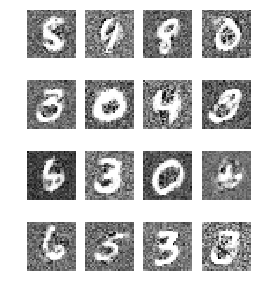

In [107]:

plt.figure(figsize=(4,5))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(gen_imgs.data[i].squeeze().cpu().detach(), cmap='gray')
    plt.axis('off')
    
plt.savefig('../result/GAN/1-GAN/3-fake-images.png', dpi=300)

### 6-4. Model save

In [95]:
torch.save({
    'epoch': num_epochs,
    'model_G_state_dict': generator.state_dict(),
    'model_D_state_dict': discriminator.state_dict(),
    'optimizer_G_state_dict': optimizer_G.state_dict(),
    'optimizer_D_state_dict': optimizer_D.state_dict()
}, '../result/GAN/1-GAN/model_weights.pth')

## 7. Visualization (Interpolation)

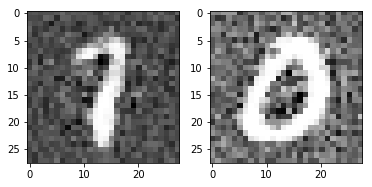

In [109]:
z_opposites = random_sample_z_space(2)
fake_img = generator(z_opposites)

plt.subplot(121); plt.imshow(fake_img[0].squeeze().cpu().detach(), cmap='gray')
plt.subplot(122); plt.imshow(fake_img[1].squeeze().cpu().detach(), cmap='gray')

plt.savefig('../result/GAN/1-GAN/5-side-images.png', dpi=300)

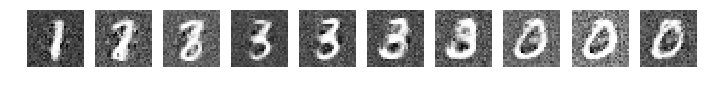

In [111]:
num_interpolation = 10

z_interpolation = Variable(Tensor(np.linspace(z_opposites[0].cpu(), z_opposites[1].cpu(), num_interpolation)))
fake_img = generator(z_interpolation)

plt.figure(figsize=(12,2))
for i in range(num_interpolation):
    plt.subplot(1,num_interpolation,i+1)
    plt.imshow(fake_img[i].squeeze().cpu().detach(), cmap='gray')
    plt.axis('off')
    
plt.savefig('../result/GAN/1-GAN/6-interpolation.png', dpi=300)